# DNA shape features for k-mer nucleotide substitution rate prediction
### Zian Liu
### 11/23/2020


This is the notebook associated with the publication on DNA shape features and substitution rates. 

In this notebook, I will include all the essential code leading to the published figures as well as explanation for why they are in their place.

## Setup

First, import libraries:

In [64]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load, Parallel, delayed
from copy import deepcopy
from collections import Counter
from IPython.display import display
from Bio.Seq import Seq
import eli5
from scipy.stats import pearsonr, fisher_exact, binom_test
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.feature_selection import VarianceThreshold, f_regression
from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoLarsIC, Lasso, lars_path
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

# Print version info
import Bio
import matplotlib
import joblib
import scipy
import sklearn
print("Numpy version: ", np.__version__, "\nPandas version: ", pd.__version__, "\nMatplotlib version: ", matplotlib.__version__, 
      "\nSeaborn version: ", sns.__version__, "\nScipy version: ", scipy.__version__, "\nScikit-learn version: ", sklearn.__version__, 
      "\nBiopython version: ", Bio.__version__, "\nJoblib version: ", joblib.__version__, "\neli5 version: ", eli5.__version__)

Numpy version:  1.19.1 
Pandas version:  1.1.3 
Matplotlib version:  3.3.1 
Seaborn version:  0.11.0 
Scipy version:  1.5.4 
Scikit-learn version:  0.23.2 
Biopython version:  1.78 
Joblib version:  0.17.0 
eli5 version:  0.10.1


Define a few functions. Please see the note in each function for what they do; a few of these are directly copied/adapted from the Aggarwala et al. publication. 

In [2]:
def get_dict_info_file(filename):
    """This function returns the dictionary containing the count of transitions and occurances from the file. 
    The function is from Varun's paper. """
    handle = open(filename, "r")
    dict_rate = {}  # Contains the rate for all pairs for all chromosomes
    acceptable_chr = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13",
        "14", "15", "16", "17", "18", "19", "20", "21", "22", "X"]
    for chrom in acceptable_chr:
        dict_rate[chrom] = {}
    content = handle.readlines()
    handle.close()
    for entry in content[1 : len(content)]:
        entry = entry.split("\t")
        for index in range(2, len(entry)):  # Modified script
            if index % 2 == 0:
                indexchr = int((index / 2) - 1)
                dict_rate[acceptable_chr[indexchr]][(entry[0], entry[1])] = float(entry[index])
            else:
                indexchr = int((index / 2) - 1)
                dict_rate[acceptable_chr[indexchr]][entry[0]] = float(entry[index])
        count_trans = 0
        count_key = 0
        for autosome in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13",
        "14", "15", "16", "17", "18", "19", "20", "21", "22"]:
            count_trans += dict_rate[autosome][(entry[0], entry[1])]
            count_key += dict_rate[autosome][entry[0]]
        if not "combined" in dict_rate:
            dict_rate["combined"] = {}
        dict_rate["combined"][(entry[0], entry[1])] = count_trans
        dict_rate["combined"][entry[0]] = count_key
    return dict_rate


def get_bayesian_dict_rate_file(filename):
    """This will return the IGR rate with uniform prior"""
    acceptable_chr = [
        "1","2","3","4","5","6","7","8","9","10","11","12","13",
        "14","15","16","17","18","19","20","21","22","X"]
    dict_count = get_dict_info_file(filename)
    acceptable_chr.append("combined")
    dict_rate = {}
    for chrom in acceptable_chr:
        if not chrom in dict_rate:
            dict_rate[chrom] = {}
        for entry in dict_count["combined"]:
            if len(entry) == 2:
                dict_rate[chrom][entry] = (dict_count[chrom][entry] + 1) / (
                    dict_count[chrom][entry[0]] + 2
                )
    return dict_rate


def load_files(rate_file, structural_ref_df, cv_no, return_df=['original', 'combined', 'diff', 'all']):
    """This function returns the shape predictors given sequence inputs."""
    # Load the files
    temp_list = list(rate_file[cv_no].keys())
    list_major = [temp_list[_count][0] for _count in range(len(temp_list))]
    list_alter = [temp_list[_count][1] for _count in range(len(temp_list))]
    list_value = np.array(list(rate_file[cv_no].values()))
    # Make the dfs and returns
    df_val_major = structural_ref_df.loc[list_major, :]
    df_val_alter = structural_ref_df.loc[list_alter, :]
    if return_df == 'original':
        return df_val_major, df_val_alter, list_value
    elif return_df == 'combined':
        df_val_join = pd.concat([df_val_major.reset_index(drop=True), df_val_alter.reset_index(drop=True)], axis=1, ignore_index=True)
        colnames = list(df_val_major.columns) + [str(item) + '_r' for item in list(df_val_alter.columns)]
        df_val_join.columns = colnames
        return df_val_join, list_value
    elif return_df == 'diff':
        df_val_diff = df_val_major.reset_index(drop=True).subtract(other = df_val_alter.reset_index(drop=True))
        return df_val_diff, list_value
    elif return_df == 'all':
        df_val_all = pd.concat([
            df_val_major.reset_index(drop=True), 
            df_val_alter.reset_index(drop=True), 
            df_val_major.reset_index(drop=True).subtract(other = df_val_alter.reset_index(drop=True))
        ], axis=1, ignore_index=True)
        return df_val_all, list_value
    
    
def load_file_preprocessed(filename, mode=['sequence', 'shape'], structural_ref_df=None):
    """This function imports the file from Dr. Voight's github."""
    df_import = pd.read_csv(filename, sep='\t', header=2)
    # Predictor
    if mode == 'sequence':
        temp = [list(item)[0:3]+list(item)[4:7] for item in list(df_import['trans'])]
        predictor = pd.DataFrame(temp)
        predictor.columns = ['3L', '2L', '1L', '1R', '2R', '3R']
    elif mode == 'shape':
        temp1 = [item.split(',')[0] for item in list(df_import['trans'])]
        temp2 = [item.split(',')[1] for item in list(df_import['trans'])]
        df_val_major = structural_ref_df.loc[temp1, :]
        df_val_alter = structural_ref_df.loc[temp2, :]
        predictor = pd.concat([df_val_major.reset_index(drop=True), df_val_alter.reset_index(drop=True)], axis=1, ignore_index=True)
        colnames = list(df_val_major.columns) + [str(item) + '_r' for item in list(df_val_alter.columns)]
        predictor.columns = colnames
    # Effector
    effector_train, effector_test = np.array(df_import['train_rate']), np.array(df_import['test_rate'])
    # Index
    index_class = np.zeros(shape=(len(df_import), ), dtype=int)
    g_label = np.array([item[4] for item in list(df_import['trans'])])
    for select in range(1, 6):
        sclass = ['A,G', 'A,T', 'C,A', 'C,G', 'C,T'][select-1]
        index_class[df_import['class'] == sclass] = select
    for select in range(6, 9):
        sclass = ['C,A', 'C,G', 'C,T'][select-6]
        index_class[np.all([df_import['class'] == sclass, g_label == 'G'], axis=0)] = select
    return predictor, effector_train, effector_test, index_class


def make_2dshape_neighbor(shape_df, labels):
    """Custom 2nd degree polynomial that only includes neighbor interactions"""
    temp_posit = [item.split('_')[1] for item in labels]
    temp_df = np.array(deepcopy(shape_df))
    temp_labels = deepcopy(labels)
    for i in range(np.shape(shape_df)[1]):
        for j in range(i, np.shape(shape_df)[1]):
            posit1 = temp_posit[i]
            posit2 = temp_posit[j]
            if posit1 == 'L':
                if posit2 in ['L', 'CL', 'C']:
                    append_arr = np.array(shape_df.iloc[:,i] * shape_df.iloc[:,j]).reshape(-1, 1)
                    temp_df = np.concatenate((temp_df, append_arr), axis=1)
                    temp_labels = np.append(temp_labels, temp_labels[i]+'*'+temp_labels[j])
            elif posit1 == 'CL':
                if posit2 in ['CL', 'C', 'CR']:
                    append_arr = np.array(shape_df.iloc[:,i] * shape_df.iloc[:,j]).reshape(-1, 1)
                    temp_df = np.concatenate((temp_df, append_arr), axis=1)
                    temp_labels = np.append(temp_labels, temp_labels[i]+'*'+temp_labels[j])
            elif posit1 == 'C':
                if posit2 in ['C', 'CR', 'R']:
                    append_arr = np.array(shape_df.iloc[:,i] * shape_df.iloc[:,j]).reshape(-1, 1)
                    temp_df = np.concatenate((temp_df, append_arr), axis=1)
                    temp_labels = np.append(temp_labels, temp_labels[i]+'*'+temp_labels[j])
            elif posit1 == 'CR':
                if posit2 in ['CR', 'R']:
                    append_arr = np.array(shape_df.iloc[:,i] * shape_df.iloc[:,j]).reshape(-1, 1)
                    temp_df = np.concatenate((temp_df, append_arr), axis=1)
                    temp_labels = np.append(temp_labels, temp_labels[i]+'*'+temp_labels[j])
            elif posit1 == 'R':
                if posit2 in ['R']:
                    append_arr = np.array(shape_df.iloc[:,i] * shape_df.iloc[:,j]).reshape(-1, 1)
                    temp_df = np.concatenate((temp_df, append_arr), axis=1)
                    temp_labels = np.append(temp_labels, temp_labels[i]+'*'+temp_labels[j])
    df_strucval_neighbor = pd.DataFrame(temp_df)
    df_strucval_neighbor.columns = temp_labels
    return df_strucval_neighbor


def make_4dshape(predictor_1d, predictor_raw, degree=4, neighbors_only=False):
    """This function makes a 2~4d version of the nucleotide predictor."""
    pred_wide = np.shape(predictor_1d)[1]
    predictor_out = deepcopy(predictor_1d)
    Labels_ref = np.array(['C', 'G', 'T', 'C', 'G', 'T', 'C', 'G', 'T', 'C', 'G', 'T', 'C', 'G', 'T', 'C', 'G', 'T'], dtype=object)
    labels_out = np.array([])
    Labels_raw = np.array(predictor_raw)
    # Add first degree, labels only
    for i in range(pred_wide):
        posit = int(i//3)
        new_label = ['_'] * 6
        new_label[posit] = Labels_ref[i]
        labels_out = np.append(labels_out, ''.join(new_label))
    # Add second degree label
    if degree >= 2:
        for i in range(pred_wide):
            posit1 = int(i//3)
            for j in range(int((posit1+1)*3), pred_wide):
                posit2 = int(j//3)
                if neighbors_only:
                    if (posit2 - posit1) > 1:
                        continue
                new_arr = predictor_1d[:, i] * predictor_1d[:, j]
                new_arr.shape = (len(new_arr), 1)
                new_label = ['_'] * 6
                new_label[posit1] = Labels_ref[i]
                new_label[posit2] = Labels_ref[j]
                predictor_out = np.concatenate((predictor_out, new_arr), axis=1)
                labels_out = np.append(labels_out, ''.join(new_label))
    # Add third degree label
    if degree >= 3:
        for i in range(pred_wide):
            posit1 = int(i//3)
            for j in range(int((posit1+1)*3), pred_wide):
                posit2 = int(j//3)
                if neighbors_only:
                    if (posit2 - posit1) > 1:
                        continue
                for k in range(int((posit2+1)*3), pred_wide):
                    posit3 = int(k//3)
                    if neighbors_only:
                        if (posit3 - posit2) > 1:
                            continue
                    new_arr = predictor_1d[:, i] * predictor_1d[:, j] * predictor_1d[:, k]
                    new_arr.shape = (len(new_arr), 1)
                    new_label = ['_'] * 6
                    new_label[posit1] = Labels_ref[i]
                    new_label[posit2] = Labels_ref[j]
                    new_label[posit3] = Labels_ref[k]
                    predictor_out = np.concatenate((predictor_out, new_arr), axis=1)
                    labels_out = np.append(labels_out, ''.join(new_label))
    # Add fourth degree label
    if degree >= 4:
        for i in range(pred_wide):
            posit1 = int(i//3)
            for j in range(int((posit1+1)*3), pred_wide):
                posit2 = int(j//3)
                if neighbors_only:
                    if (posit2 - posit1) > 1:
                        continue
                for k in range(int((posit2+1)*3), pred_wide):
                    posit3 = int(k//3)
                    if neighbors_only:
                        if (posit3 - posit2) > 1:
                            continue
                    for l in range(int((posit3+1)*3), pred_wide):
                        posit4 = int(l//3)
                        if neighbors_only:
                            if (posit4 - posit3) > 1:
                                continue
                        new_arr = predictor_1d[:, i] * predictor_1d[:, j] * predictor_1d[:, k] * predictor_1d[:, l]
                        new_arr.shape = (len(new_arr), 1)
                        new_label = ['_'] * 6
                        new_label[posit1] = Labels_ref[i]
                        new_label[posit2] = Labels_ref[j]
                        new_label[posit3] = Labels_ref[k]
                        new_label[posit4] = Labels_ref[l]
                        predictor_out = np.concatenate((predictor_out, new_arr), axis=1)
                        labels_out = np.append(labels_out, ''.join(new_label))
    return predictor_out, labels_out
                    
    
def reverse_complement(sequence):
    """This function calculates the reverse-complement of a sequence. Used for rate folding."""
    sequin = Seq(sequence)
    return str(sequin.reverse_complement())


def create_class_index(dict_keys):
    """Create an array of classes from 0 to 8. 
    0-8 map to ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'CpG_C>A', 'CpG_C>G', 'CpG_C>T']"""
    out_array = np.zeros(shape=(len(dict_keys), ), dtype=int)
    for _iter in range(len(dict_keys)):
        temp_1, temp_2 = dict_keys[_iter][0], dict_keys[_iter][1]
        # Set values based on conditions
        if temp_1[3] == 'A':
            if temp_2[3] == 'C':
                pass
            elif temp_2[3] == 'G':
                out_array[_iter] = 1
            elif temp_2[3] == 'T':
                out_array[_iter] = 2
        elif temp_1[3] == 'C':
            if temp_1[4] == 'G':
                if temp_2[3] == 'A':
                    out_array[_iter] = 6
                elif temp_2[3] == 'G':
                    out_array[_iter] = 7
                elif temp_2[3] == 'T':
                    out_array[_iter] = 8         
            else:
                if temp_2[3] == 'A':
                    out_array[_iter] = 3
                elif temp_2[3] == 'G':
                    out_array[_iter] = 4
                elif temp_2[3] == 'T':
                    out_array[_iter] = 5        
        else:
            raise ValueError("Rates are not folded appropriatedly!")   
    return out_array


def plot_scatter_residual(predicted_Y, actual_Y, alpha_value=0.5, use_index=False, index=None, index_name=None, filename=False):
    """Plot scatterplot of actual vs predicted results and residual plot, both in normal and log axes."""
    temp_fig = plt.figure(figsize=[15, 15])
    for _iter in range(1, 5):
        plt.subplot(int(220+_iter))
        plotting_x = actual_Y
        if _iter in [2, 4]:
            plotting_y = actual_Y - predicted_Y
        elif _iter in [1, 3]:
            plotting_y = predicted_Y
        if use_index:
            for _class in set(index):
                plt.scatter(plotting_x[index==_class], plotting_y[index==_class], alpha=alpha_value, s=1)
            plt.legend(index_name)
        else:
            plt.scatter(plotting_x, plotting_y, alpha=alpha_value, s=1)   # X is predicted value, Y is actual
        plt.xlabel("Actual frequencies")
        if _iter in [3, 4]:
            plt.xscale('log')
            plt.xlim(min(plotting_x)*1.05, max(plotting_x)*0.95)
        else:
            plt.xlim(-0.01, max(plotting_x)+0.01)
        if _iter == 1:
            plt.ylim(-0.01, max(plotting_x)+0.01)
        elif _iter == 2:
            plt.ylim(min(plotting_y)*1.05, max(plotting_y)*1.05)
        elif _iter == 3:
            plt.yscale('log')
            plt.ylim(min(plotting_x)*1.05, max(plotting_x)*0.95)
        elif _iter == 4:
            plt.ylim(min(plotting_y)*1.05, max(plotting_y)*1.05)
    plt.show()
    if filename:
        temp_fig.savefig(filename, dpi=300)
        

def standard_cv(model_used, kfold_used, X, y, subclass_index=None, log=False, use_index=False, record_index=False):
    """CV that records k-fold CV R^2 and MSE for train/test. Can change cv number, record by-subclass, 
    and accommodate log-transformed or class-specific models."""
    cv = kfold_used.n_splits
    output_dict = dict()
    output_dict['train_r2'], output_dict['test_r2'] = np.zeros(shape=(cv, )), np.zeros(shape=(cv, ))
    output_dict['train_mse'], output_dict['test_mse'] = np.ones(shape=(cv, )), np.ones(shape=(cv, ))
    if record_index:
        output_dict['train_r2_subclass'], output_dict['test_r2_subclass'] = dict(), dict()
        output_dict['train_mse_subclass'], output_dict['test_mse_subclass'] = dict(), dict()
        for _iter_c in set(subclass_index):
            output_dict['train_r2_subclass'][_iter_c] = np.zeros(shape=(cv, ))
            output_dict['test_r2_subclass'][_iter_c] = np.zeros(shape=(cv, ))
            output_dict['train_mse_subclass'][_iter_c] = np.ones(shape=(cv, ))
            output_dict['test_mse_subclass'][_iter_c] = np.ones(shape=(cv, ))
    _iter = 0
    for train_idx, test_idx in kfold_used.split(X, y):
        # Make train/test splits
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        # Also do this for the subclasses, will be useful for calculating R^2 by class
        if use_index or record_index:
            subclass_train = subclass_index[train_idx]
            subclass_test = subclass_index[test_idx]
        if use_index:
            model_used.fit(X_train, y_train, subclass_index[train_idx])
            temp_tr = model_used.predict(X_train, subclass_index[train_idx])
            temp_tt = model_used.predict(X_test, subclass_index[test_idx])
        else:
            model_used.fit(X_train, y_train)
            temp_tr = model_used.predict(X_train)
            temp_tt = model_used.predict(X_test)
        if log:   # Transform things back with exp
            temp_tr, temp_tt = np.exp(temp_tr), np.exp(temp_tt)
            y_train, y_test = np.exp(y_train), np.exp(y_test)
        # Add predictions
        output_dict['train_r2'][_iter], output_dict['test_r2'][_iter] = r2_score(y_train, temp_tr), r2_score(y_test, temp_tt)
        output_dict['train_mse'][_iter], output_dict['test_mse'][_iter] = mean_squared_error(y_train, temp_tr), mean_squared_error(y_test, temp_tt)
        if record_index:
            for _iter_c in set(subclass_index):
                output_dict['train_r2_subclass'][_iter_c][_iter] = r2_score(y_train[subclass_train==_iter_c], temp_tr[subclass_train==_iter_c])
                output_dict['test_r2_subclass'][_iter_c][_iter] = r2_score(y_test[subclass_test==_iter_c], temp_tt[subclass_test==_iter_c])
                output_dict['train_mse_subclass'][_iter_c][_iter] = mean_squared_error(y_train[subclass_train==_iter_c], temp_tr[subclass_train==_iter_c])
                output_dict['test_mse_subclass'][_iter_c][_iter] = mean_squared_error(y_test[subclass_test==_iter_c], temp_tt[subclass_test==_iter_c])
        _iter += 1
    return output_dict


def plot_CV_subclass_r2(cv_object, filename=None):
    """Makes a simple visualization of the R^2 and MSE of different subclasses and the overall R^2, use in conjunction with standard_cv"""
    temp_trainr, temp_testr = [cv_object['train_r2']], [cv_object['test_r2']]
    for _iter in range(9):
        temp1, temp2 = cv_object['train_r2_subclass'][_iter], cv_object['test_r2_subclass'][_iter]
        temp1[temp1 < 0] = 0
        temp2[temp2 < 0] = 0
        temp_trainr.append(temp1)
        temp_testr.append(temp2)
    temp_fig = plt.figure(figsize=[15, 5])
    plt.subplot(121)
    plt.boxplot(temp_trainr)
    plt.xticks(list(range(1, 11)), ['overall', 'A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'CpG_C>A', 'CpG_C>G', 'CpG_C>T'])
    plt.ylabel("train")
    plt.ylim((-0.05, 1.05))
    plt.subplot(122)
    plt.boxplot(temp_testr)
    plt.xticks(list(range(1, 11)), ['overall', 'A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'CpG_C>A', 'CpG_C>G', 'CpG_C>T'])
    plt.ylabel('test')
    plt.ylim((-0.05, 1.05))
    plt.show()
    if filename:
        temp_fig.savefig(filename, dpi=300)


def r2_adjust(y_true, y_pred, p):
    """Adjusted R^2. Need to define the number of predictors p. """
    _R2 = r2_score(y_true, y_pred)
    n = len(y_true)
    _R2adj = 1 - ((1-_R2) * (n - 1) / ( n - p - 1))
    return _R2adj


def standard_traintestresult_df(pred_output, effector_train, effector_test, index_class, p, display='df'):
    """Makes a df containing R2 and R2-adjust given an input model prediction and number of features."""
    train_r2, test_r2, train_r2adj, test_r2adj = np.zeros(shape=(10,)), np.zeros(shape=(10,)), np.zeros(shape=(10,)), np.zeros(shape=(10,))
    train_r2[9], test_r2[9] = r2_score(effector_train, pred_output), r2_score(effector_test, pred_output)
    if type(p) == int:
        train_r2adj[9], test_r2adj[9] = r2_adjust(effector_train, pred_output, p), r2_adjust(effector_test, pred_output, p)
    else:
        train_r2adj[9], test_r2adj[9] = r2_adjust(effector_train, pred_output, sum(p)), r2_adjust(effector_test, pred_output, sum(p))
    for select in range(9):
        train_r2[select] = r2_score(effector_train[index_class==select], pred_output[index_class==select])
        test_r2[select] = r2_score(effector_test[index_class==select], pred_output[index_class==select])
        if type(p) == int:
            train_r2adj[select] = r2_adjust(effector_train[index_class==select], pred_output[index_class==select], p)
            test_r2adj[select] = r2_adjust(effector_test[index_class==select], pred_output[index_class==select], p)
        else:
            train_r2adj[select] = r2_adjust(effector_train[index_class==select], pred_output[index_class==select], p[select])
            test_r2adj[select] = r2_adjust(effector_test[index_class==select], pred_output[index_class==select], p[select])
    output_df = pd.DataFrame({'train_R2': train_r2, 'train_R2_adj': train_r2adj, 
                             'test_R2': test_r2, 'test_R2_adj': test_r2adj})
    output_df.index = ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'CpG_C>A', 'CpG_C>G', 'CpG_C>T', 'overall']
    return output_df


def L1select_byalpha(X, y, alpha_val_list, index_class, n_jobs, verbose=1, savefile=False, 
                     save_name_model=None, save_name_results=None):
    """Runs L1(Lasso) on different alpha values."""
    dict_out_model, dict_out_results = dict(), dict()
    for select in set(index_class):
        dict_out_model[select], dict_out_results[select] = dict(), dict()
        alpha_val_select = alpha_val_list
        for _iter in range(len(alpha_val_select)):
            alpha_val = alpha_val_select[_iter]
            temp_x = X[index_class == select]
            temp_y = y[index_class == select]
            model_L1 = Lasso(alpha=alpha_val, precompute=True, warm_start=True, selection='random', random_state=42, max_iter=int(1e08)).fit(temp_x, temp_y)
            if np.sum(model_L1.coef_) == 0:
                continue
            elif np.sum(model_L1.coef_) == np.shape(X)[1]:
                break
            else:
                temp_coefs = (model_L1.coef_ != 0)
            dict_out_model[select][alpha_val] = model_L1
            model = LinearRegression(n_jobs=n_jobs)
            temp_x_crop = temp_x[:, temp_coefs]
            dict_out_results[select][alpha_val] = standard_cv(model, Kfoldobj, temp_x_crop, temp_y, index_class, record_index=False)
            if verbose >= 1:
                print("Alpha value "+str(alpha_val)+" done.")
            if _iter > 1:
                if np.mean(dict_out_results[select][alpha_val]['test_mse']) > np.mean(dict_out_results[select][alpha_val_select[_iter-1]]['test_mse']):
                    if np.mean(dict_out_results[select][alpha_val]['test_mse']) > np.mean(dict_out_results[select][alpha_val_select[_iter-2]]['test_mse']):
                        if verbose >= 1:
                            print("Detected rise in test MSE, break loop for class "+str(select)+" at alpha = "+str(alpha_val))
                        break
        if verbose >= 1:
            print("Class "+str(select)+" done.")
    if savefile:
        dump(dict_out_model, save_name_model)
        dump(dict_out_results, save_name_results)
    return dict_out_model, dict_out_results


def load_L1_indices(results_joblib_filename, models_joblib_filename, index_class_range=9):
    """Load the indices generated by the L1 selection algorithm"""
    alpha_list_return, indices_return = [], []
    results_dict_in = load(results_joblib_filename)
    model_dict_in = load(models_joblib_filename)
    for select in range(index_class_range):
        min_loc = np.argmin([np.mean(results_dict_in[select][key]['test_mse']) for key in results_dict_in[select].keys()])
        alpha_list_return.append( list(results_dict_in[select].keys())[min_loc] )
        model_select = model_dict_in[select][alpha_list_return[select]]
        indices_return.append(model_select.coef_ != 0)
        print("Class " + str(select) + ", Number of predictors: " + str(np.sum(indices_return[select])))
    return alpha_list_return, indices_return


def plot_L1_results_outcome(filename, class_count=9, figsize=[15,4], byclass=False):
    """Given a dictionary file of standard_cv objects by class, visualize. Can import by subclass too (provide name list)"""
    if not byclass:
        temp_metrics_all = load(filename)
    for select in range(class_count):
        if byclass:
            try:
                temp_metrics = load(filename[select])
            except:
                continue
        else:
            temp_metrics = temp_metrics_all[select]
        temp_keys = list(temp_metrics.keys())
        temp_plt1 = np.array([np.mean(temp_metrics[item]['train_r2']) for item in temp_metrics])
        temp_plt2 = np.array([np.mean(temp_metrics[item]['test_r2']) for item in temp_metrics])
        temp_plt3 = np.array([np.mean(temp_metrics[item]['train_mse']) for item in temp_metrics])
        temp_plt4 = np.array([np.mean(temp_metrics[item]['test_mse']) for item in temp_metrics])
        temp_plt1[temp_plt1 < 0] = 0
        temp_plt2[temp_plt2 < 0] = 0
        temp_plt3[temp_plt3 > 1] = 1
        temp_plt4[temp_plt4 > 1] = 1
        plt.figure(figsize=figsize)
        plt.subplot(121)
        plt.plot(temp_plt1)
        plt.plot(temp_plt2)
        for iter_ in range(len(temp_plt2)):
            plt.annotate(str(round(temp_plt2[iter_], 5)), xy=(iter_, temp_plt2[iter_]))
        plt.ylim(-0.05, 1.05)
        plt.ylabel("R^2")
        plt.xticks(np.arange(len(temp_keys)), temp_keys, rotation=90)
        plt.legend(['train', 'validation'])
        plt.subplot(122)
        plt.plot(temp_plt3)
        plt.plot(temp_plt4)
        for iter_ in range(len(temp_plt4)):
            plt.annotate(str(round(temp_plt4[iter_], 9)), xy=(iter_, temp_plt4[iter_]))
        plt.ylabel("MSE")
        plt.xticks(np.arange(len(temp_keys)), temp_keys, rotation=90)
        plt.legend(['train', 'validation'])
        plt.suptitle("Train vs test: Class "+str(select))
        plt.show()
        
        
def standard_l1modelfitting(predictor, effector, effector_test, index_class, l1_index_in, kfold_obj, n_jobs=4):
    """Fit a model using a given predictor, selection index, and show the CV results as well as the independent testing result. """
    lin_or_log = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    model_out = linreg_bysubclassall_alin2_rmcor_ind(model_indices=l1_index_in, lin_or_log=lin_or_log, n_jobs=n_jobs)
    model_out.fit(predictor, effector, index_class)
    tmp_out = model_out.predict(predictor, index_class)
    print(r2_score(effector, tmp_out))   # This is the R^2 value
    print(r2_score(effector[index_class!=8], tmp_out[index_class!=8]))   # This is the R^2 value for non CpG C>T
    # Cross validate
    model = linreg_bysubclassall_alin2_rmcor_ind(model_indices=l1_index_in, lin_or_log=lin_or_log, n_jobs=n_jobs)
    cv_out = standard_cv(model, kfold_obj, predictor, effector, index_class, use_index=True, record_index=True)
    plot_CV_subclass_r2(cv_out)
    # Results file
    p_length = [np.sum(l1_index_in[i]) for i in range(9)]
    results_df_out = standard_traintestresult_df(
        tmp_out, effector, effector_test, index_class, p=p_length, display='df')
    display(results_df_out)
    return model_out, cv_out, results_df_out


def return_coefs_df(model, predictor, effector, indices_remove, coef_labels, index_class, index_class_labels, save_filename=None):
    """Saves and displays the coefficient dataframe."""
    df_return = np.zeros(shape=(np.shape(predictor)[1], 9), dtype=float)
    for select in range(9):
        df_return[indices_remove[select], select] = model.model[select].coef_ / \
            ( np.max(effector[index_class == select]) - np.min(effector[index_class == select]) )
    df_return = pd.DataFrame(df_return)
    df_return.index, df_return.columns = coef_labels, index_class_labels
    if save_filename:
        df_return.to_csv(save_filename)
    return df_return

Next, import a few models that we have built. Please forgive me for the somewhat stochastic naming system.

In [3]:
class linreg_bysubclassall_alin2_rmcor_ind():
    """This makes a class of binned regression items with custom model indices and linear/log-linear selection."""
    def __init__(self, model_indices=None, lin_or_log=None, n_jobs=1):
        self.paral = int(n_jobs)
        self.indices = model_indices
        self.model_type = lin_or_log

    def fit(self, X=None, y=None, Subclass_list=None):
        subclass = np.array(Subclass_list)
        self.model = dict()
        for _iter in range(9):
            if self.model_type[_iter] == 0:
                y_i = np.array(y)[subclass == _iter]
            elif self.model_type[_iter] == 1:
                y_i = np.log(y)[subclass == _iter]
            X_i = X[subclass == _iter][:, self.indices[_iter]]
            self.model[_iter] = LinearRegression(n_jobs=self.paral).fit(X_i, y_i)
        return self

    def predict(self, X=None, Subclass_list=None):
        subclass = np.array(Subclass_list)
        if len(X) != len(subclass):
            raise ValueError("Predictor matrix and substitution class identity list are not of same length!")
        tmpout = dict()
        iter_count = dict()
        for _iter in range(9):
            X_i = X[subclass == _iter][:, self.indices[_iter]]
            if self.model_type[_iter] == 0:
                tmpout[_iter] = self.model[_iter].predict(X_i)
            elif self.model_type[_iter] == 1:
                tmpout[_iter] = np.exp(self.model[_iter].predict(X_i))
            iter_count[_iter] = 0
        # Make output
        out = np.zeros(shape=(len(X), ), dtype=float)
        for iter_i in range(len(subclass)):
            model_ind = subclass[iter_i]
            out[iter_i] = tmpout[model_ind][iter_count[model_ind]]
            iter_count[model_ind] += 1
        return out


class linreg_bysubclassall_assign_index():
    """This makes a class of binned regression items where we assign the index instead of training it. 
    Used for Varun's model, we need to have the function to let it compliant with our CV function."""
    def __init__(self, assign_coefs=None, assign_intc=None, n_jobs=1):
        self.paral = int(n_jobs)
        self.coef_ = assign_coefs
        self.intercept_ = assign_intc

    def fit(self, X, y, Subclass_list=None):
        subclass = np.array(Subclass_list)
        self.model = dict()
        for _iter in range(9):
            self.model[_iter] = LinearRegression(n_jobs=self.paral)
            self.model[_iter].coef_ = self.coef_[_iter]
            self.model[_iter].intercept_ = self.intercept_[_iter]
        return self
    
    def predict(self, X=None, Subclass_list=None):
        subclass = np.array(Subclass_list)
        if len(X) != len(subclass):
            raise ValueError("Predictor matrix and substitution class identity list are not of same length!")
        tmpout = dict()
        iter_count = dict()
        for _iter in range(9):
            X_i = X[subclass == _iter]
            tmpout[_iter] = self.model[_iter].predict(X_i)
            iter_count[_iter] = 0
        # Make output
        out = np.zeros(shape=(len(X), ), dtype=float)
        for iter_i in range(len(subclass)):
            model_ind = subclass[iter_i]
            out[iter_i] = tmpout[model_ind][iter_count[model_ind]]
            iter_count[model_ind] += 1
        return out

Next, load the files. 

Note that F_rate7mer is a file containing the counts of each 7-mer and each 7-mer substitution in the African population. The reference dictionaries are made from DNAshapeR, an R library; separate R scripts will be provided. 

Be especially aware that we have assumed if 4th and 5th locations of a 7-mer are 'C' and 'G', then it is methylated; these choices will slightly influence the shape features.

In [4]:
F_strucref = pd.ExcelFile("../DNAshapeR_reference/ref_7mers_structure_cpg.xlsx")
Shapes_name = ['HelT', 'Rise', 'Roll', 'Shift', 'Slide', 'Tilt', 'Buckle', 'Opening', 'ProT', 'Shear', 
                 'Stagger', 'Stretch', 'MGW', 'EP']

DF_strucval = pd.DataFrame()
for item in Shapes_name:
    Temp_df = F_strucref.parse(sheet_name=item, index_col=0)
    if np.shape(Temp_df)[1] == 3:
        Temp_df.rename({'V1': item+'_L', 'V2': item+'_C', 'V3': item+'_R'}, axis='columns', inplace=True)
    else:
        Temp_df.rename({'V1': item+'_L', 'V2': item+'_CL', 'V3': item+'_CR', 'V4': item+'_R'}, axis='columns', inplace=True)
    DF_strucval = pd.concat([DF_strucval, Temp_df], axis=1)

Using the dictionary file, we will parse the counts file and translate the sequences into shape features. 

We also want to create an integer array for classifying the sequence context. The rationale for this will be explained later in the notebook.

The array will have 0-8, corresponding to A>C, A>G, A>T, C>A, C>G, C>T, CpG C>A, CpG C>G, CpG C>T.

Import the rates file directly from Dr. Voight's Github file:

In [4]:
DF_val_join, List_value, Eff_test, Index_class = load_file_preprocessed(
    "data_input/ben_data_7mer_bayesian_test_training_AFR_10", 
    mode='shape', structural_ref_df=DF_strucval)
Index_class_name = ['A>C', 'A>G', 'A>T', 'C>A', 'C>G', 'C>T', 'CpG_C>A', 'CpG_C>G', 'CpG_C>T']

NameError: name 'DF_strucval' is not defined

For the last step, do some preprocessing to create predictors. We will use: 

1) All 1st order DNA shape features (96 of them)

2) All 2nd degree interaction terms, no bias term (4752 total)

Predictors will be min-max scaled. Regularization will be performed separately in individual chunks.

Also set up the stratified k-fold object.

In [6]:
# 1st order shape predictors
Pred_1d = MinMaxScaler(feature_range=(0, 1)).fit_transform(DF_val_join)
print(np.shape(Pred_1d))   # return shape
# 2nd degree interaction terms
Pred_2d = PolynomialFeatures(degree=2, include_bias=False).fit_transform(DF_val_join)
Pred_2d = MinMaxScaler(feature_range=(0, 1)).fit_transform(Pred_2d)
print(np.shape(Pred_2d))   # return shape
# Effector
Eff = np.array(List_value)

# Labels
Labels_2d, temp_labels = list(DF_val_join.columns), DF_val_join.columns
for i in range(np.shape(DF_val_join)[1]):
    for j in range(i, np.shape(DF_val_join)[1]):
        Labels_2d.append(temp_labels[i]+'*'+temp_labels[j])
print(Labels_2d[0:10])
print(len(Labels_2d))

# Stratified k-fold
Kfoldobj = KFold(n_splits=8, shuffle=True, random_state=42)

(24576, 96)
(24576, 4752)
['HelT_L', 'HelT_CL', 'HelT_CR', 'HelT_R', 'Rise_L', 'Rise_CL', 'Rise_CR', 'Rise_R', 'Roll_L', 'Roll_CL']
4752


Remove low-variance predictors in the 2D, and match labels:

In [7]:
# Reduce variance
Var_red = VarianceThreshold(threshold=0.01).fit(Pred_2d)
print(Var_red.get_params())
Pred_2d = Var_red.transform(Pred_2d)
print(np.shape(Pred_2d))

# Labels
Labels_2d = Var_red.transform(np.array(Labels_2d).reshape(1, 4752))[0]
print(len(Labels_2d))

{'threshold': 0.01}
(24576, 4158)
4158


Follow the above framework and make a 2D predictor with only neighboring interactions:

In [8]:
temp_labels = DF_val_join.columns
Pred_2dneibr = make_2dshape_neighbor(DF_val_join, temp_labels)

# Minmax scaling
Labels_2dneibr = Pred_2dneibr.columns
Pred_2dneibr = MinMaxScaler(feature_range=(0, 1)).fit_transform(Pred_2dneibr)
print(np.shape(Pred_2dneibr))

# Reduce variance
Var_red_neibr = VarianceThreshold(threshold=0.01).fit(Pred_2dneibr)
print(Var_red_neibr.get_params())
Pred_2dneibr = Var_red_neibr.transform(Pred_2dneibr)
Labels_2dneibr = Var_red_neibr.transform(np.array(Labels_2dneibr).reshape(1, len(Labels_2dneibr)))[0]
print(np.shape(Pred_2dneibr))

(24576, 2282)
{'threshold': 0.01}
(24576, 2089)


Also, import sequence context predictors. 

In [9]:
Pred_raw, foo, goo, Index_class_sc = load_file_preprocessed(
    "data_input/ben_data_7mer_bayesian_test_training_AFR_10", 
    mode='sequence', structural_ref_df=DF_strucval)

cat = [['C','G','T'], ['C','G','T'],['C','G','T'],['C','G','T'],['C','G','T'],['C','G','T']]
Pred_sc_1d = OneHotEncoder(categories=cat, sparse=True, handle_unknown='ignore').fit_transform(Pred_raw).toarray()

Pred_sc_2d, Labels_sc_2d = make_4dshape(Pred_sc_1d, Pred_raw, degree=2)
Pred_sc_3d, Labels_sc_3d = make_4dshape(Pred_sc_1d, Pred_raw, degree=3)
Pred_sc_4d, Labels_sc_4d = make_4dshape(Pred_sc_1d, Pred_raw, degree=4)

print(np.shape(Pred_sc_4d))
print(Labels_sc_4d[0:10])
display(Pred_sc_4d)

(24576, 1908)
['C_____' 'G_____' 'T_____' '_C____' '_G____' '_T____' '__C___' '__G___'
 '__T___' '___C__']


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Also make 4D sequence context predictors with only neighbors to compare performance:

In [10]:
Pred_sc_2dneibr, Labels_sc_2dneibr = make_4dshape(Pred_sc_1d, Pred_raw, degree=2, neighbors_only=True)
Pred_sc_3dneibr, Labels_sc_3dneibr = make_4dshape(Pred_sc_1d, Pred_raw, degree=3, neighbors_only=True)
Pred_sc_4dneibr, Labels_sc_4dneibr = make_4dshape(Pred_sc_1d, Pred_raw, degree=4, neighbors_only=True)

Save the setup so that we can reload them later: 

In [11]:
dump([DF_val_join, List_value, Eff_test, Index_class, Index_class_name, Pred_1d, Pred_2d, Eff, Labels_2d, 
      Kfoldobj, Pred_2dneibr, Labels_2dneibr, Var_red_neibr, Pred_sc_1d, Pred_sc_2d, Labels_sc_2d, Pred_sc_3d, 
      Labels_sc_3d, Pred_sc_4d, Labels_sc_4d, Index_class_sc, 
      Pred_sc_2dneibr, Labels_sc_2dneibr, Pred_sc_3dneibr, Labels_sc_3dneibr, 
      Pred_sc_4dneibr, Labels_sc_4dneibr], "data_intermediate/import_all_data.joblib")

['data_intermediate/import_all_data.joblib']

Data reload:

In [5]:
DF_val_join, List_value, Eff_test, Index_class, Index_class_name, Pred_1d, Pred_2d, Eff, Labels_2d, \
    Kfoldobj, Pred_2dneibr, Labels_2dneibr, Var_red_neibr, Pred_sc_1d, Pred_sc_2d, Labels_sc_2d, Pred_sc_3d, \
    Labels_sc_3d, Pred_sc_4d, Labels_sc_4d, Index_class_sc, \
    Pred_sc_2dneibr, Labels_sc_2dneibr, Pred_sc_3dneibr, Labels_sc_3dneibr, \
    Pred_sc_4dneibr, Labels_sc_4dneibr = load("data_intermediate/import_all_data.joblib")

This concludes the setup. Next, do some baseline analysis:

## Baseline analysis

Start with analyzing the distribution of mutation rates, draw by class.

In [7]:
F_rateall = get_bayesian_dict_rate_file("data_input/non_coding_all_AFR_before3_after3_folded_all")
foo, List_value_plot = load_files(F_rateall, DF_strucval, 'combined', return_df='combined')
Index_class_rateall = create_class_index(list(F_rateall['combined'].keys()))
del foo

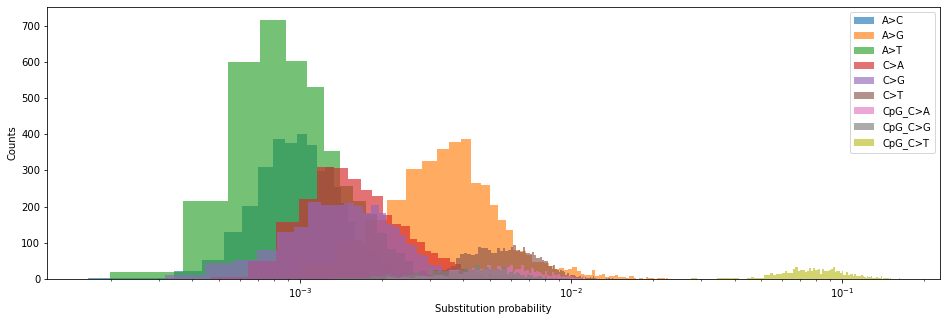

In [8]:
fig_temp = plt.figure(figsize=[16,5])
for item in set(Index_class):
    temp = np.array(List_value_plot)[Index_class_rateall == item]
    plt.hist(temp[temp != 0], bins=100, alpha=0.65)
plt.xlabel("Substitution probability")
plt.xscale('log')
plt.ylabel("Counts")
plt.legend(Index_class_name)
plt.show()
fig_temp.savefig("manuscript/figures/pltout_subprobs.pdf", dpi=300)

Next, find out the distribution of substitution rates in each of the classes:

[[1.19122724e-03 5.19521877e-04 2.69902981e-07]
 [4.88953433e-03 3.26950839e-03 1.06896851e-05]
 [1.16443245e-03 6.20821655e-04 3.85419527e-07]
 [2.15367812e-03 1.26584806e-03 1.60237132e-06]
 [1.87805477e-03 9.83684581e-04 9.67635356e-07]
 [6.26126368e-03 1.85155779e-03 3.42826625e-06]
 [6.20661762e-03 2.13363395e-03 4.55239381e-06]
 [4.87207807e-03 1.70868428e-03 2.91960196e-06]
 [8.63820713e-02 2.31719640e-02 5.36939916e-04]]


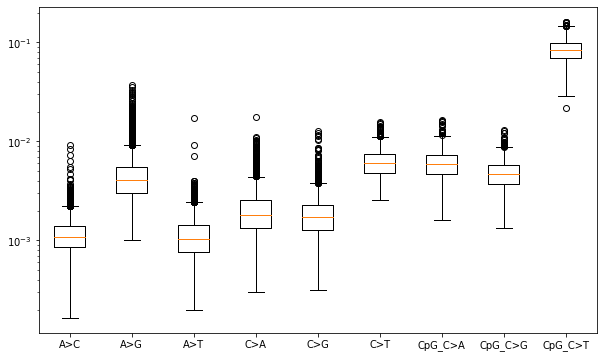

In [9]:
temp_metrics = np.zeros(shape=(9, 3), dtype=float)

fig_temp = plt.figure(figsize=[10, 6])
temp_plt = []
for item in set(Index_class):
    temp_plt.append(np.array(List_value_plot)[Index_class_rateall == item])
    temp_metrics[item] = np.mean(temp_plt[item]), np.std(temp_plt[item]), np.var(temp_plt[item])
print(temp_metrics)
plt.boxplot(temp_plt)
plt.xticks(np.arange(1, 10), Index_class_name)
plt.yscale('log')
plt.show()
fig_temp.savefig("manuscript/figures/pltout_subprobs_bar.pdf", dpi=300)

Next, analyze inter-chromosomal correlation, overall or by subclass:

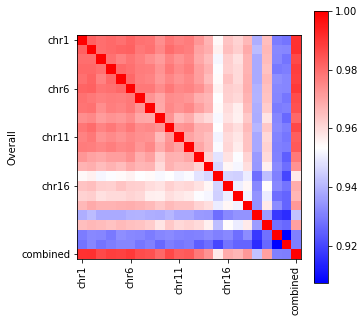

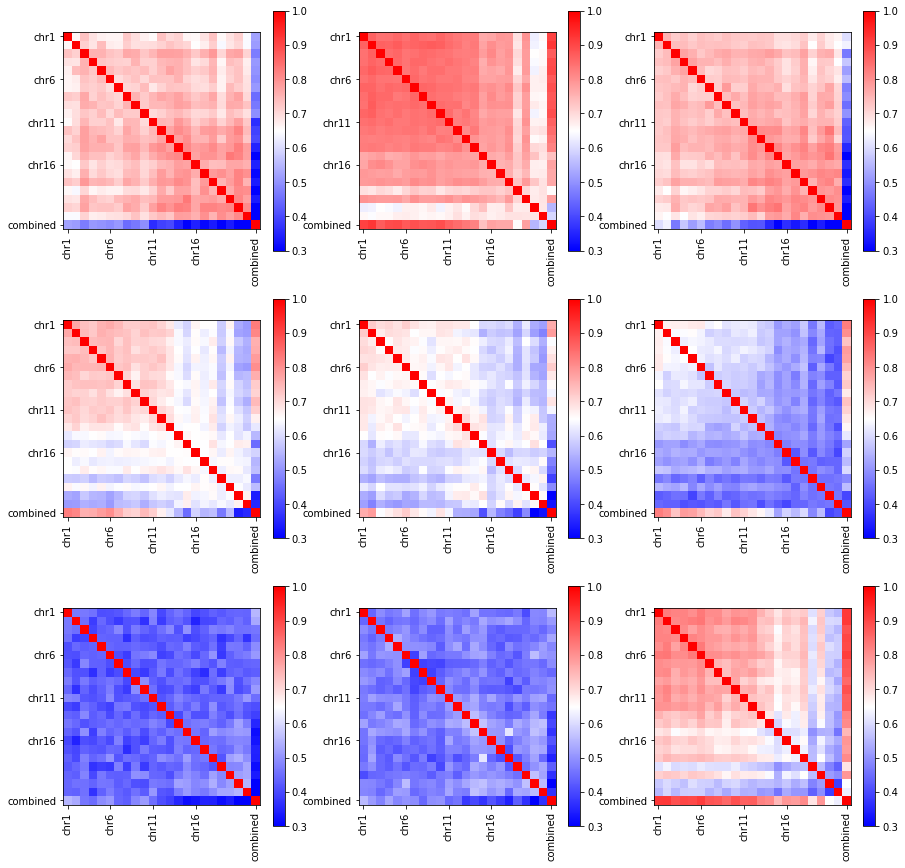

In [10]:
Array_all_chr_values = np.zeros(shape=(23, len(Eff)))
for chr_no in range(1, 24):
    if chr_no != 23:
        Array_all_chr_values[chr_no-1] = np.array(list(F_rateall[str(chr_no)].values()))
    else:
        Array_all_chr_values[chr_no-1] = np.array(list(F_rateall['combined'].values()))

temp_fig1 = plt.figure(figsize=[5,5])
temp = np.corrcoef(Array_all_chr_values)
plt.imshow(temp, cmap='bwr')
plt.colorbar()
plt.xticks([0, 5, 10, 15, 22], ['chr1', 'chr6', 'chr11', 'chr16', 'combined'], rotation=90)
plt.yticks([0, 5, 10, 15, 22], ['chr1', 'chr6', 'chr11', 'chr16', 'combined'])
plt.ylabel("Overall")
plt.show()
temp_fig1.savefig("manuscript/figures/pltout_interchrcorr.pdf", dpi=300)

temp_fig2 = plt.figure(figsize=[15, 15])
for item in set(Index_class_rateall):
    plt.subplot(3,3,item+1)
    temp = np.corrcoef(np.transpose(np.transpose(Array_all_chr_values)[Index_class_rateall == item]))
    plt.imshow(temp, cmap='bwr')
    plt.colorbar()
    plt.clim(0.3, 1)
    plt.xticks([0, 5, 10, 15, 22], ['chr1', 'chr6', 'chr11', 'chr16', 'combined'], rotation=90)
    plt.yticks([0, 5, 10, 15, 22], ['chr1', 'chr6', 'chr11', 'chr16', 'combined'])
plt.show()
temp_fig2.savefig("manuscript/figures/pltout_interchrcorr_byclass.pdf", dpi=300)

We can see that the mutation rates vary a lot across chromosomes; this explains why we want to combine all odds/all evens as testing/training. 

Next, plot correlation between the 96 shape features:

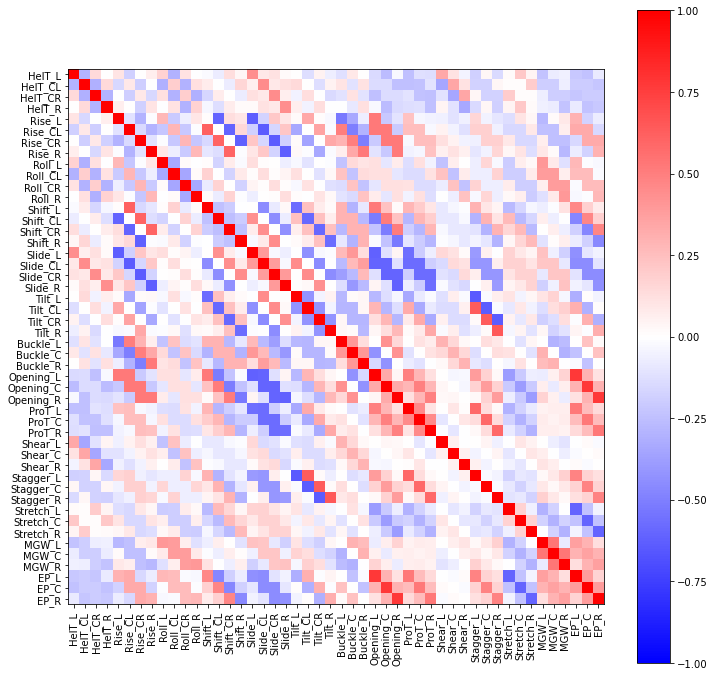

In [11]:
temp_fig = plt.figure(figsize=[12, 12])
temp = np.corrcoef(DF_strucval, rowvar=False)
plt.imshow(temp, cmap='bwr')
plt.colorbar()
plt.clim(-1, 1)
plt.xticks(np.arange(np.shape(DF_strucval)[1]), list(DF_strucval.columns), rotation=90)
plt.yticks(np.arange(np.shape(DF_strucval)[1]), list(DF_strucval.columns))
plt.show()
temp_fig.savefig("manuscript/figures/pltout_shapecorr.pdf", dpi=300)

We can see that the shape features are for the most part pretty independent; the horizontal slashes show how some shapes are correlated.

Next, progress to model building:

## Second degree interaction models

These are intermediate models that use up to all the 2nd degree interaction terms.

Start with linear regression again.

### Least-squares regresion, 2nd degree, log-scaled

Prior results suggested that log-transformed works best for the overall model:

0.9845800822801486
0.9188375008957048


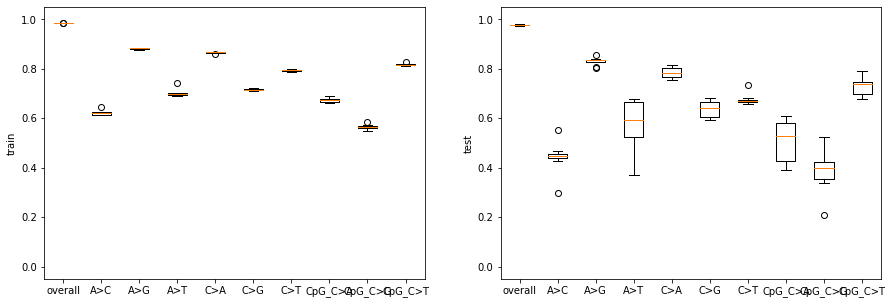

In [6]:
# Model
Model_LRlog2 = LinearRegression(n_jobs=4).fit(Pred_2d, np.log(Eff))
tmp_out = np.exp(Model_LRlog2.predict(Pred_2d))   # Note that we need to use exponential to transform back
print(r2_score(Eff, tmp_out))   # This is the R^2 value
print(r2_score(Eff[Index_class!=8], tmp_out[Index_class!=8]))   # This is the R^2 value for non CpG C>T

# Cross validate
model = LinearRegression(n_jobs=4)
CV_LRlog2 = standard_cv(model, Kfoldobj, Pred_2d, np.log(Eff), Index_class, log=True, record_index=True)
plot_CV_subclass_r2(CV_LRlog2)

How well does this model do in independent testing?

In [7]:
tmp_out = np.exp(Model_LRlog2.predict(Pred_2d))
Result_LRlog2 = standard_traintestresult_df(
    tmp_out, Eff, Eff_test, Index_class, p=4158, display='df')
display(Result_LRlog2)

dump(Model_LRlog2, "data_out/Model_allclass_log.joblib")
dump(CV_LRlog2, "data_out/Results_allclass_log.joblib")
Result_LRlog2.to_csv("data_out/Indtest_allclass_log.csv")

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.608279,26.461844,0.566242,29.194246
A>G,0.879434,8.836779,0.881088,8.729310
A>T,0.689973,21.151731,0.688442,21.251256
C>A,0.862187,1.389350,0.850662,1.421912
C>G,0.709664,1.820258,0.716485,1.800988
C>T,0.791674,1.588564,0.769054,1.652469
CpG_C>A,0.665557,1.109134,0.574010,1.139007
CpG_C>G,0.554150,1.145488,0.464328,1.174798
CpG_C>T,0.819242,1.058984,0.807042,1.062965
overall,0.984580,0.981440,0.984046,0.980797


The adjusted R^2 didn't work out very well due to the number of predictors outnumbering the number of samples...

We have also tried running this with neighboring interactions only, but there is a reduction in R^2 so we didn't show the results here.

Next, use substitution class split. We have shown that using all features would result in overfitting, so we will start with the following.

We have tried AIC but it didn't work out very well. F-regression top k predictors works better, but not as good as L1, so we will only do L1 here.

### Least-squares, L1-regularization

Next, use L1-regularization to select relevant features for each sub model.

We have done this for L1 with all interactions but performance is similar with using neighboring interactions only (with half the predictors), so we will only use neighboring interactions from now. 

In [14]:
alpha_list, Indices_rmL1 = load_L1_indices(
    "data_intermediate/Results_L1_sh1.joblib", "data_intermediate/Models_L1_sh1.joblib", index_class_range=9)

Class 0, Number of predictors: 76
Class 1, Number of predictors: 79
Class 2, Number of predictors: 82
Class 3, Number of predictors: 69
Class 4, Number of predictors: 80
Class 5, Number of predictors: 85
Class 6, Number of predictors: 72
Class 7, Number of predictors: 71
Class 8, Number of predictors: 65


0.9867590157747165
0.8204921399184077


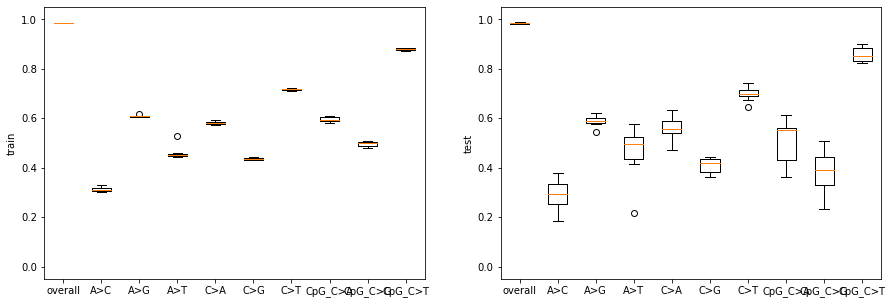

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.309833,0.296781,0.299829,0.286588
A>G,0.607715,0.599998,0.615280,0.607712
A>T,0.457312,0.446223,0.489098,0.478658
C>A,0.580184,0.570535,0.578703,0.569019
C>G,0.434593,0.419470,0.450661,0.435968
C>T,0.716030,0.707946,0.714377,0.706246
CpG_C>A,0.591887,0.560988,0.559250,0.525881
CpG_C>G,0.490682,0.452697,0.440194,0.398444
CpG_C>T,0.878316,0.870060,0.866938,0.857909
overall,0.986759,0.986383,0.986428,0.986042


In [15]:
Model_csplit1rmL1, CV_csplit1rmL1, Result_csplit1rmL1 = standard_l1modelfitting(
    Pred_1d, Eff, Eff_test, Index_class, Indices_rmL1, Kfoldobj, n_jobs=4)

dump(Model_csplit1rmL1, "data_out/Model_sh1.joblib")
dump(CV_csplit1rmL1, "data_out/Results_sh1.joblib")
Result_csplit1rmL1.to_csv("data_out/Indtest_sh1.csv")

In [16]:
alpha_list, Indices_rmL1 = load_L1_indices(
    "data_intermediate/Results_L1_sh2.joblib", "data_intermediate/Models_L1_sh2.joblib", index_class_range=9)
     #"results_lasso/Results_Lassoselect_allclass.joblib", "results_lasso/Models_Lassoselect_allclass.joblib", index_class_range=9)

Class 0, Number of predictors: 418
Class 1, Number of predictors: 822
Class 2, Number of predictors: 367
Class 3, Number of predictors: 805
Class 4, Number of predictors: 840
Class 5, Number of predictors: 523
Class 6, Number of predictors: 110
Class 7, Number of predictors: 135
Class 8, Number of predictors: 128


0.9938046088747585
0.9434849406175337


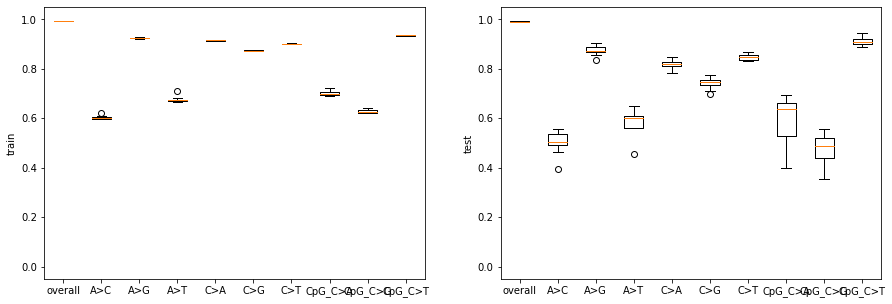

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.597699,0.551966,0.538520,0.486059
A>G,0.922733,0.903328,0.920418,0.900431
A>T,0.670343,0.637890,0.672069,0.639786
C>A,0.910672,0.878938,0.883743,0.842442
C>G,0.867692,0.817876,0.836551,0.775011
C>T,0.898180,0.877280,0.870506,0.843926
CpG_C>A,0.695228,0.658508,0.631292,0.586870
CpG_C>G,0.620062,0.562301,0.532281,0.461175
CpG_C>T,0.934675,0.925332,0.918123,0.906413
overall,0.993805,0.992547,0.992641,0.991147


In [17]:
Model_csplit2rmL1, CV_csplit2rmL1, Result_csplit2rmL1 = standard_l1modelfitting(
    Pred_2d, Eff, Eff_test, Index_class, Indices_rmL1, Kfoldobj, n_jobs=4)

dump(Model_csplit2rmL1, "data_out/Model_sh2.joblib")
dump(CV_csplit2rmL1, "data_out/Results_sh2.joblib")
Result_csplit2rmL1.to_csv("data_out/Indtest_sh2.csv")

### L1 regularization, neighbors interactions only

Use only neighboring interactions instead. We still need to run this on a cloud:

Get the alpha values:

In [18]:
alpha_list, Indices_rmL1neibr = load_L1_indices(
    #"results_L1neighbor/Results_Lassoselect_allclass.joblib", "results_L1neighbor/Models_Lassoselect_allclass.joblib")
     "data_intermediate/Results_L1_sh2neibr.joblib", "data_intermediate/Models_L1_sh2neibr.joblib", index_class_range=9)

Class 0, Number of predictors: 629
Class 1, Number of predictors: 889
Class 2, Number of predictors: 501
Class 3, Number of predictors: 616
Class 4, Number of predictors: 770
Class 5, Number of predictors: 527
Class 6, Number of predictors: 123
Class 7, Number of predictors: 126
Class 8, Number of predictors: 175


0.9944731889669096
0.9440255774648938


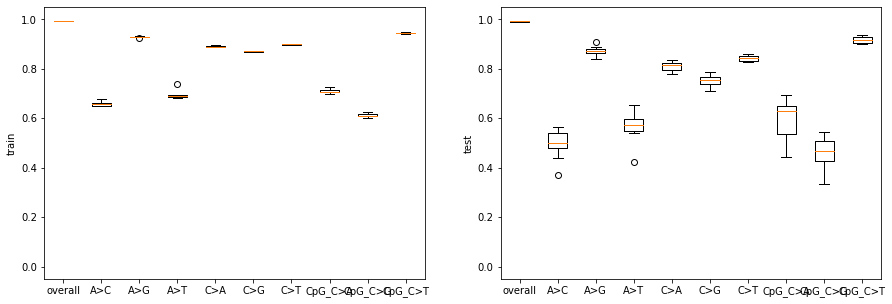

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.648458,0.584661,0.578731,0.502281
A>G,0.926287,0.905847,0.922207,0.900635
A>T,0.686432,0.642721,0.672824,0.627216
C>A,0.886260,0.857721,0.868189,0.835116
C>G,0.864279,0.818862,0.833801,0.778184
C>T,0.896343,0.874869,0.869824,0.842857
CpG_C>A,0.704173,0.663743,0.634640,0.584708
CpG_C>G,0.604332,0.548753,0.517474,0.449695
CpG_C>T,0.943422,0.931746,0.925088,0.909628
overall,0.994473,0.993282,0.993148,0.991672


In [19]:
Model_csplit2rmL1_neibr, CV_csplit2rmL1_neibr, Result_csplit2rmL1_neibr = standard_l1modelfitting(
    Pred_2dneibr, Eff, Eff_test, Index_class, Indices_rmL1neibr, Kfoldobj, n_jobs=4)

dump(Model_csplit2rmL1_neibr, "data_out/Model_sh2neibr.joblib")
dump(CV_csplit2rmL1_neibr, "data_out/Results_sh2neibr.joblib")
Result_csplit2rmL1_neibr.to_csv("data_out/Indtest_sh2neibr.csv")

## Sequence context models

Also try out sequence context models. 

### Varun's model

Import model coefficients directly from Varun's model:

In [20]:
Coefs_Varun = pd.read_excel("./data_input/41588_2016_BFng3511_MOESM210_ESM.xlsx", sheet_name="Supplementary Table 6a", 
                           header=1, index_col=0, usecols="K:R")
Coefs_Varun_cpg = pd.read_excel("./data_input/41588_2016_BFng3511_MOESM210_ESM.xlsx", sheet_name="Supplementary Table 6b", 
                               header=1, index_col=0, usecols="H:L")
# See how the output is like
display(Coefs_Varun[0:10])

Index_Varun = list(Coefs_Varun.index)
Index_Varun = np.array([re.sub('-', '', item) for item in Index_Varun])
Index_Varun_cpg = list(Coefs_Varun_cpg.index)
Index_Varun_cpg = np.array([re.sub('-', '', item) for item in Index_Varun_cpg])
print(Index_Varun[0:10])

,ORDER.1,BETA_AtoC.1,BETA_AtoG.1,BETA_AtoT.1,BETA_CtoA.1,BETA_CtoG.1,BETA_CtoT.1
SEQ_CONTEXT.1,,,,,,,
Intercept,0,0.001270,0.002750,0.000737,0.004180,0.002480,0.005490
C__-___,1,-0.000363,-0.000686,-0.000142,0.000116,-0.000058,0.000088
G__-___,1,-0.000515,0.000109,-0.000108,0.000292,-0.000163,-0.000182
T__-___,1,-0.000381,0.000084,-0.000090,-0.000384,-0.000154,0.000050
_C_-___,1,-0.000059,0.000950,-0.000082,-0.000822,0.000404,0.001170
_G_-___,1,-0.000065,0.000705,-0.000173,-0.000394,-0.000235,0.000380
_T_-___,1,0.000227,0.000327,0.000175,-0.000343,-0.000134,0.003600
__C-___,1,0.000155,0.000648,0.000240,-0.000481,0.000023,-0.001450
__G-___,1,-0.000178,0.000623,0.000093,-0.000383,-0.000400,-0.001260


['Intercept' 'C_____' 'G_____' 'T_____' '_C____' '_G____' '_T____'
 '__C___' '__G___' '__T___']


0.9931632320052356
0.9306113585424256


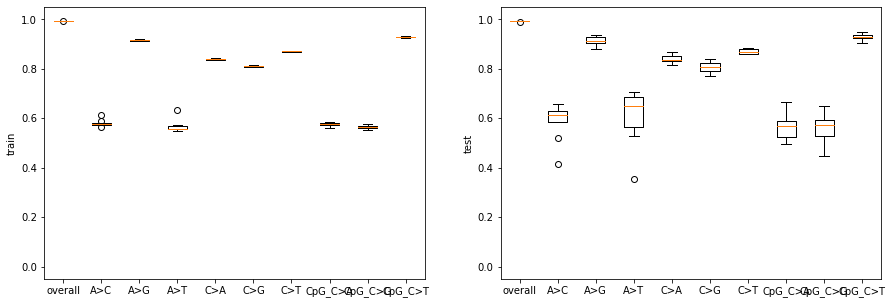

In [21]:
list_coefs_import, list_intc_import = [], []
for select in range(9):
    # Create coefficients
    if select <= 5:
        Coefs_V = np.array(Coefs_Varun.iloc[:, select+1])
        Index_V = deepcopy(Index_Varun)
    else:
        Coefs_V = np.array(Coefs_Varun_cpg.iloc[:, select-5])
        Index_V = deepcopy(Index_Varun_cpg)
    Index_V = Index_V[~np.isnan(Coefs_V)]
    Coefs_V = Coefs_V[~np.isnan(Coefs_V)]
    # Assign model parameters
    list_coefs_import.append(np.zeros(shape=(np.shape(Pred_sc_4d)[1], )))
    list_coefs_import[select][np.isin(Labels_sc_4d, Index_V)] = Coefs_V[1::]
    list_intc_import.append(Coefs_V[0])

Model_Varun = linreg_bysubclassall_assign_index(assign_coefs=list_coefs_import, assign_intc=list_intc_import, n_jobs=4)
Model_Varun.fit(Pred_sc_4d, Eff)
tmp_out = Model_Varun.predict(Pred_sc_4d, Index_class_sc)
print(r2_score(Eff, tmp_out))   # This is the R^2 value
print(r2_score(Eff[Index_class_sc!=8], tmp_out[Index_class_sc!=8]))   # This is the R^2 value for non CpG C>T

# Cross validate
model = linreg_bysubclassall_assign_index(assign_coefs=list_coefs_import, assign_intc=list_intc_import, n_jobs=4)
CV_Varunmod = standard_cv(model, Kfoldobj, Pred_sc_4d, Eff, Index_class_sc, use_index=True, record_index=True)
plot_CV_subclass_r2(CV_Varunmod)

Test data:

In [22]:
tmp_out = Model_Varun.predict(Pred_sc_4d, Index_class_sc)
p_size = [np.sum(Model_Varun.model[select].coef_ != 0) for select in range(9)]
Result_Varunmod = standard_traintestresult_df(
    tmp_out, Eff, Eff_test, Index_class_sc, p=p_size, display='df')
display(Result_Varunmod)

dump(Model_Varun, "data_out/Model_sc4Varun.joblib")
dump(CV_Varunmod, "data_out/Results_sc4Varun.joblib")
Result_Varunmod.to_csv("data_out/Indtest_sc4Varun.csv")

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.580066,0.550893,0.580254,0.551095
A>G,0.915877,0.907620,0.919987,0.912133
A>T,0.566845,0.544954,0.605163,0.585208
C>A,0.839504,0.823276,0.840336,0.824193
C>G,0.810782,0.792690,0.819134,0.801841
C>T,0.870864,0.859220,0.875378,0.864141
CpG_C>A,0.576305,0.565255,0.553423,0.541777
CpG_C>G,0.564764,0.520209,0.530545,0.482486
CpG_C>T,0.930057,0.922813,0.932358,0.925353
overall,0.993163,0.992607,0.993584,0.993062


### L1 selection with sequence context only

Do L1 selection on 2nd to 4th degree transform of sequence context:

Sequence context: 2 degree
Class 0, Number of predictors: 121
Class 1, Number of predictors: 125
Class 2, Number of predictors: 107
Class 3, Number of predictors: 117
Class 4, Number of predictors: 121
Class 5, Number of predictors: 131
Class 6, Number of predictors: 81
Class 7, Number of predictors: 79
Class 8, Number of predictors: 113


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9911686272104046
0.869922877611137


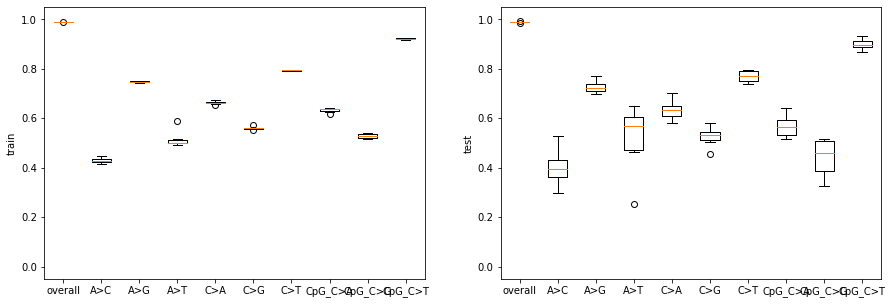

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.426719,0.409264,0.413254,0.395388
A>G,0.746094,0.738099,0.755598,0.747903
A>T,0.510145,0.497002,0.543133,0.530875
C>A,0.661170,0.647750,0.666181,0.652959
C>G,0.557901,0.539767,0.571532,0.553957
C>T,0.791988,0.782719,0.784710,0.775118
CpG_C>A,0.632004,0.600361,0.587290,0.551802
CpG_C>G,0.521883,0.481871,0.484295,0.441137
CpG_C>T,0.922001,0.912315,0.907726,0.896268
overall,0.991169,0.990796,0.990474,0.990072


Sequence context: 3 degree
Class 0, Number of predictors: 278
Class 1, Number of predictors: 419
Class 2, Number of predictors: 245
Class 3, Number of predictors: 307
Class 4, Number of predictors: 290
Class 5, Number of predictors: 348
Class 6, Number of predictors: 180
Class 7, Number of predictors: 175
Class 8, Number of predictors: 314


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9948984073268107
0.9315995372802914


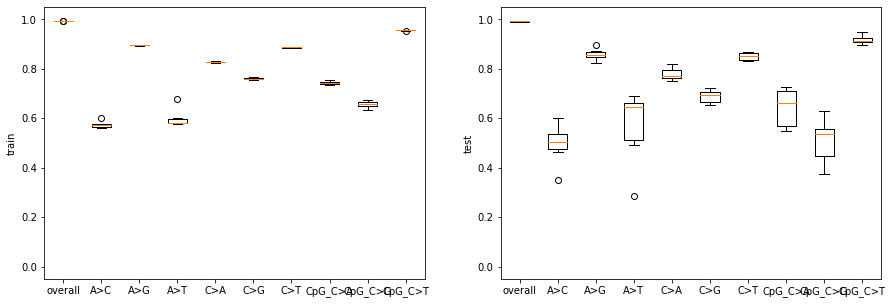

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.568934,0.537539,0.527979,0.493601
A>G,0.893989,0.881905,0.894514,0.882490
A>T,0.592268,0.566322,0.596595,0.570924
C>A,0.825176,0.805758,0.816076,0.795647
C>G,0.755344,0.729831,0.757107,0.731778
C>T,0.884995,0.870298,0.869194,0.852477
CpG_C>A,0.738058,0.682127,0.607113,0.523222
CpG_C>G,0.656114,0.585147,0.535023,0.439067
CpG_C>T,0.952884,0.932017,0.927502,0.895394
overall,0.994898,0.994306,0.993065,0.992260


Sequence context: 4 degree
Class 0, Number of predictors: 368
Class 1, Number of predictors: 578
Class 2, Number of predictors: 213
Class 3, Number of predictors: 685
Class 4, Number of predictors: 521
Class 5, Number of predictors: 583
Class 6, Number of predictors: 251
Class 7, Number of predictors: 285
Class 8, Number of predictors: 500


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9961767179548515
0.9515687651397196


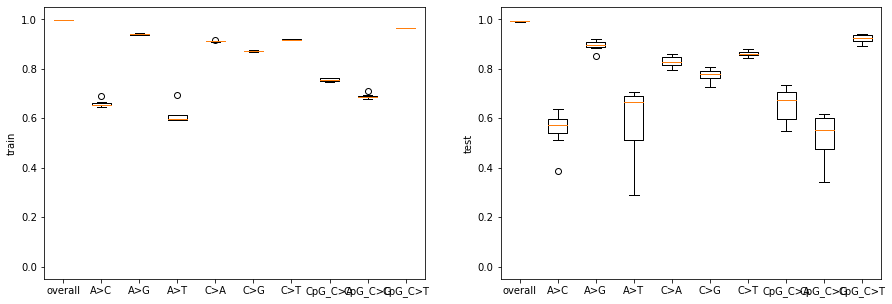

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.653274,0.619039,0.581512,0.540191
A>G,0.937805,0.927583,0.929313,0.917695
A>T,0.606204,0.584597,0.591188,0.568757
C>A,0.907601,0.881074,0.876613,0.841190
C>G,0.867100,0.839947,0.841049,0.808573
C>T,0.915258,0.895400,0.877599,0.848918
CpG_C>A,0.753092,0.672815,0.610416,0.483751
CpG_C>G,0.689576,0.569696,0.526647,0.343849
CpG_C>T,0.963826,0.929242,0.931482,0.865978
overall,0.996177,0.995437,0.993644,0.992415


In [23]:
pred_all = [None, None, Pred_sc_2d, Pred_sc_3d, Pred_sc_4d]

for i in range(2, 5):
    dsc = str(i)
    print("Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1 = load_L1_indices(
    "data_intermediate/Results_L1_sc"+dsc+".joblib", "data_intermediate/Models_L1_sc"+dsc+".joblib")

    Model, CV_L1, Result = standard_l1modelfitting(
    pred_all[i], Eff, Eff_test, Index_class, Indices_rmL1, Kfoldobj, n_jobs=4)

    dump(Model, "data_out/Model_sc"+dsc+".joblib")
    dump(CV_L1, "data_out/Results_sc"+dsc+".joblib")
    Result.to_csv("data_out/Indtest_sc"+dsc+".csv")

Same as above, but with neighboring interactions only:

Sequence context: 2 degree
Class 0, Number of predictors: 48
Class 1, Number of predictors: 55
Class 2, Number of predictors: 60
Class 3, Number of predictors: 52
Class 4, Number of predictors: 48
Class 5, Number of predictors: 49
Class 6, Number of predictors: 36
Class 7, Number of predictors: 41
Class 8, Number of predictors: 45


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9857315312708516
0.8278373196040594


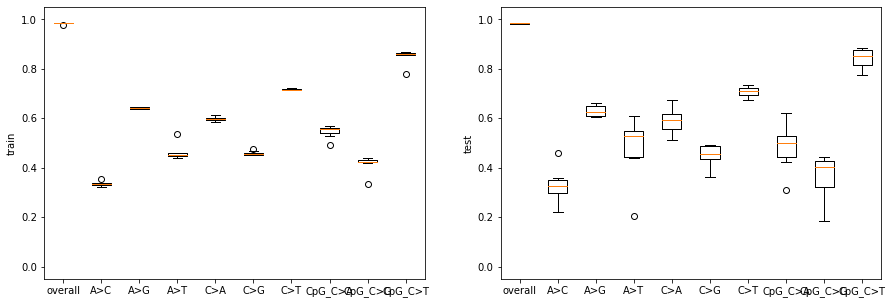

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.334714,0.326823,0.326221,0.318230
A>G,0.640797,0.635906,0.649499,0.644727
A>T,0.459333,0.451294,0.495868,0.488372
C>A,0.597710,0.590781,0.607692,0.600935
C>G,0.457661,0.449050,0.475512,0.467184
C>T,0.715998,0.711393,0.718508,0.713944
CpG_C>A,0.557412,0.541269,0.526544,0.509275
CpG_C>G,0.425060,0.401056,0.396678,0.371488
CpG_C>T,0.862377,0.856045,0.850136,0.843240
overall,0.985732,0.985475,0.985396,0.985134


Sequence context: 3 degree
Class 0, Number of predictors: 119
Class 1, Number of predictors: 142
Class 2, Number of predictors: 129
Class 3, Number of predictors: 106
Class 4, Number of predictors: 106
Class 5, Number of predictors: 118
Class 6, Number of predictors: 71
Class 7, Number of predictors: 71
Class 8, Number of predictors: 90


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9894424979363942
0.8673045897412942


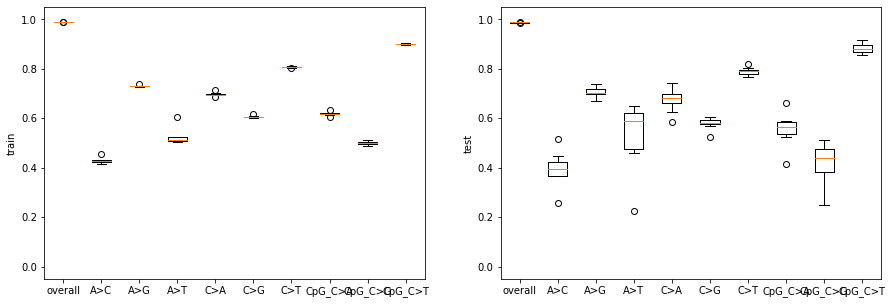

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.427025,0.409877,0.407497,0.389764
A>G,0.729320,0.719597,0.739321,0.729957
A>T,0.520594,0.505000,0.550692,0.536077
C>A,0.696137,0.685274,0.701824,0.691164
C>G,0.604991,0.590869,0.618433,0.604792
C>T,0.805945,0.798191,0.801224,0.793281
CpG_C>A,0.615573,0.586902,0.571355,0.539386
CpG_C>G,0.496727,0.459193,0.457568,0.417113
CpG_C>T,0.899792,0.890125,0.888878,0.878159
overall,0.989442,0.989017,0.989051,0.988610


Sequence context: 4 degree
Class 0, Number of predictors: 163
Class 1, Number of predictors: 164
Class 2, Number of predictors: 181
Class 3, Number of predictors: 225
Class 4, Number of predictors: 154
Class 5, Number of predictors: 178
Class 6, Number of predictors: 108
Class 7, Number of predictors: 107
Class 8, Number of predictors: 155


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9915101807293831
0.8796703026898356


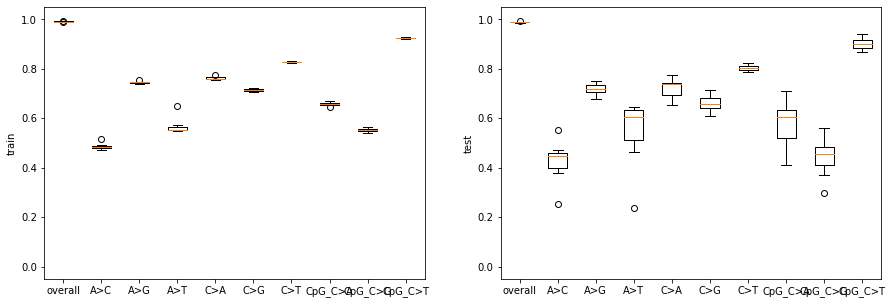

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.482667,0.461222,0.446439,0.423491
A>G,0.743922,0.733238,0.750784,0.740387
A>T,0.562553,0.542324,0.572760,0.553003
C>A,0.760988,0.742093,0.765171,0.746606
C>G,0.711299,0.696058,0.717907,0.703014
C>T,0.826944,0.816296,0.818741,0.807588
CpG_C>A,0.656902,0.616405,0.594880,0.547063
CpG_C>G,0.548841,0.496140,0.497089,0.438343
CpG_C>T,0.923577,0.909930,0.912177,0.896495
overall,0.991510,0.990984,0.990966,0.990406


In [24]:
pred_all = [None, None, Pred_sc_2dneibr, Pred_sc_3dneibr, Pred_sc_4dneibr]

for i in range(2, 5):
    dsc = str(i)
    print("Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_neibr = load_L1_indices(
    "data_intermediate/Results_L1_sc"+dsc+"neibr.joblib", "data_intermediate/Models_L1_sc"+dsc+"neibr.joblib")

    Model, CV_L1, Result = standard_l1modelfitting(
    pred_all[i], Eff, Eff_test, Index_class, Indices_rmL1_neibr, Kfoldobj, n_jobs=4)

    dump(Model, "data_out/Model_sc"+dsc+"neibr.joblib")
    dump(CV_L1, "data_out/Results_sc"+dsc+"neibr.joblib")
    Result.to_csv("data_out/Indtest_sc"+dsc+"neibr.csv")

As shown, the neighboring only interactions appear to have lower efficacy compared to all sequence context interactions.

## Combination models

Mix shape features and sequence context to obtain more accurate predictions.

### Binning lower degree sequence context to lower degree shapes

What if we use lower dimension shapes and sequences?

Some basic analysis suggests that 2nd-3rd degree sequence context + 1st degree shapes is the sweet spot; we can increase it to 4th degree sequence context + 1st degree shape or any degree sequence context + 2nd degree shape, but that would start to lead to overfitting (although it also leads to better models). 

We will approach it by sequentially building more and more complex models and use L1-regularization on them. 

Integrate 1st degree shape features with 1st to 3rd degree sequence context sequentially by applying L1 regularization. 

### Binned predictors, optimal models from L1 selections

Do this as a sequential model-building exercise. 

#### 1st degree shape + 1-4 degree sequence context

Shape 1 degree; Sequence context: 1 degree
Class 0, Number of predictors: 76
Class 1, Number of predictors: 95
Class 2, Number of predictors: 92
Class 3, Number of predictors: 83
Class 4, Number of predictors: 98
Class 5, Number of predictors: 105
Class 6, Number of predictors: 78
Class 7, Number of predictors: 67
Class 8, Number of predictors: 92


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9888568601005785
0.837526100236741


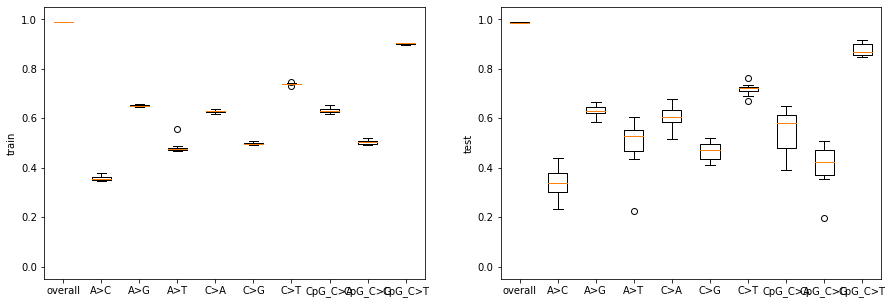

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.355153,0.342959,0.341260,0.328804
A>G,0.650088,0.641778,0.658699,0.650593
A>T,0.482227,0.470327,0.514254,0.503091
C>A,0.626443,0.616066,0.624594,0.614166
C>G,0.496007,0.479394,0.512664,0.496600
C>T,0.737985,0.728709,0.735687,0.726330
CpG_C>A,0.628761,0.598119,0.578570,0.543786
CpG_C>G,0.499291,0.464200,0.448816,0.410187
CpG_C>T,0.901078,0.891303,0.889348,0.878413
overall,0.988857,0.988489,0.988423,0.988040


Shape 1 degree; Sequence context: 2 degree
Class 0, Number of predictors: 198
Class 1, Number of predictors: 220
Class 2, Number of predictors: 135
Class 3, Number of predictors: 214
Class 4, Number of predictors: 201
Class 5, Number of predictors: 206
Class 6, Number of predictors: 69
Class 7, Number of predictors: 76
Class 8, Number of predictors: 135


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9923334759036522
0.8875690790485792


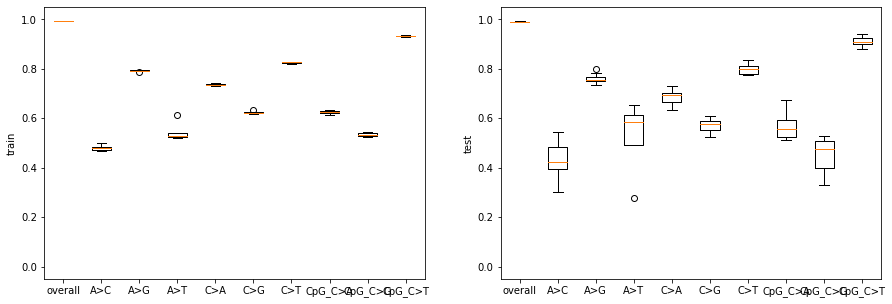

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.475929,0.449301,0.455424,0.427755
A>G,0.790398,0.778498,0.800481,0.789154
A>T,0.536283,0.520475,0.569259,0.554574
C>A,0.732724,0.712704,0.730663,0.710488
C>G,0.618944,0.592256,0.627984,0.601930
C>T,0.825249,0.812684,0.816539,0.803348
CpG_C>A,0.624187,0.597005,0.574152,0.543351
CpG_C>G,0.531282,0.493665,0.490520,0.449632
CpG_C>T,0.932139,0.921823,0.916414,0.903707
overall,0.992333,0.991851,0.991479,0.990943


Shape 1 degree; Sequence context: 3 degree
Class 0, Number of predictors: 278
Class 1, Number of predictors: 409
Class 2, Number of predictors: 246
Class 3, Number of predictors: 506
Class 4, Number of predictors: 290
Class 5, Number of predictors: 352
Class 6, Number of predictors: 184
Class 7, Number of predictors: 225
Class 8, Number of predictors: 316


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9951679727108452
0.9333022679864588


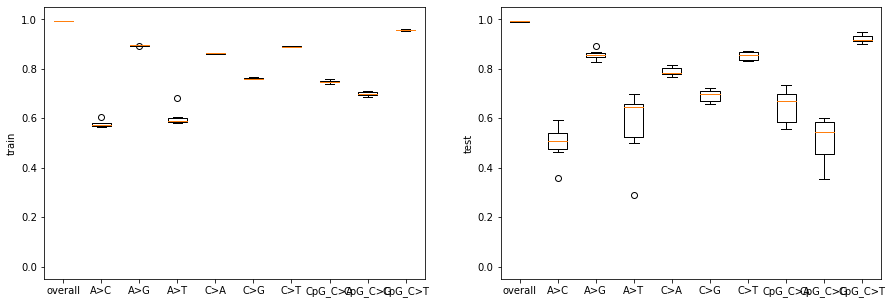

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.572164,0.541004,0.532820,0.498794
A>G,0.892448,0.880513,0.893368,0.881536
A>T,0.596943,0.571182,0.603209,0.577849
C>A,0.858301,0.830348,0.845032,0.814462
C>G,0.757272,0.731961,0.758253,0.733044
C>T,0.886914,0.872274,0.871354,0.854699
CpG_C>A,0.745102,0.689201,0.618078,0.534319
CpG_C>G,0.687284,0.599113,0.528789,0.395929
CpG_C>T,0.955957,0.936272,0.930460,0.899378
overall,0.995168,0.994545,0.993304,0.992441


Shape 1 degree; Sequence context: 4 degree
Class 0, Number of predictors: 450
Class 1, Number of predictors: 628
Class 2, Number of predictors: 275
Class 3, Number of predictors: 603
Class 4, Number of predictors: 517
Class 5, Number of predictors: 584
Class 6, Number of predictors: 259
Class 7, Number of predictors: 285
Class 8, Number of predictors: 516


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.9963314321575026
0.9527705810694679


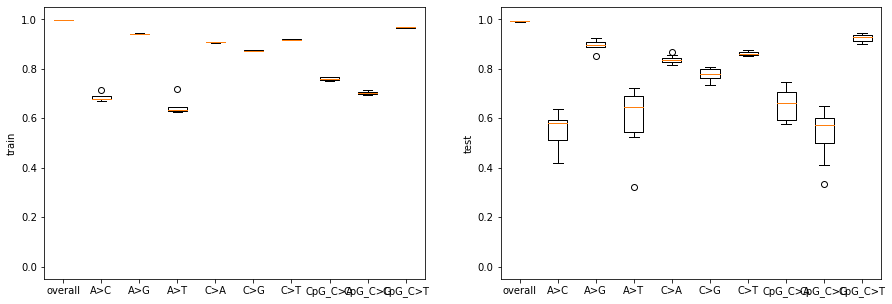

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.677261,0.637417,0.586199,0.535113
A>G,0.939826,0.928926,0.930415,0.917811
A>T,0.638922,0.612928,0.610173,0.582110
C>A,0.904129,0.880705,0.877821,0.847969
C>G,0.868681,0.842099,0.842336,0.810420
C>T,0.915523,0.895686,0.877930,0.849266
CpG_C>A,0.754992,0.671933,0.609131,0.476624
CpG_C>G,0.695658,0.578127,0.526087,0.343072
CpG_C>T,0.965521,0.930430,0.932331,0.863460
overall,0.996331,0.995593,0.993718,0.992454


In [25]:
pred_binned_all = [None, 
    np.concatenate((Pred_1d, Pred_sc_1d), axis=1), np.concatenate((Pred_1d, Pred_sc_2d), axis=1), 
    np.concatenate((Pred_1d, Pred_sc_3d), axis=1), np.concatenate((Pred_1d, Pred_sc_4d), axis=1)
]

for i in range(1, 5):
    dsc = str(i)
    print("Shape 1 degree; Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_bin = load_L1_indices(
        "data_intermediate/Results_L1_sh1_sc"+dsc+".joblib", "data_intermediate/Models_L1_sh1_sc"+dsc+".joblib")
    Model, CV_L1, Result = standard_l1modelfitting(
        pred_binned_all[i], Eff, Eff_test, Index_class, Indices_rmL1_bin, Kfoldobj, n_jobs=3)
    dump(Model, "data_out/Model_sh1_sc"+dsc+".joblib")
    dump(CV_L1, "data_out/Results_sh1_sc"+dsc+".joblib")
    Result.to_csv("data_out/Indtest_sh1_sc"+dsc+".csv")

These conclude the performances of the 1st degree shape, nth degree sc models. 

#### 2nd degree shape, 1-4 degree sequence context

Shape 2 degree; Sequence context: 1 degree
Class 0, Number of predictors: 623
Class 1, Number of predictors: 840
Class 2, Number of predictors: 301
Class 3, Number of predictors: 709
Class 4, Number of predictors: 896
Class 5, Number of predictors: 624
Class 6, Number of predictors: 110
Class 7, Number of predictors: 93
Class 8, Number of predictors: 185
0.9946384804302345
0.9430249580125458


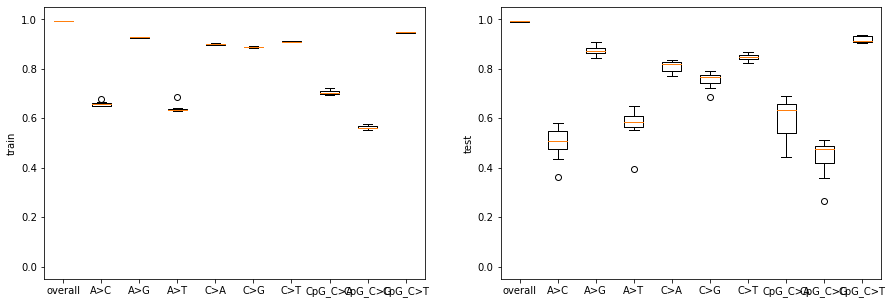

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.649310,0.586384,0.579134,0.503616
A>G,0.924084,0.904493,0.920586,0.900092
A>T,0.634905,0.605940,0.650158,0.622403
C>A,0.896176,0.865011,0.872901,0.834750
C>G,0.881823,0.833139,0.843934,0.779641
C>T,0.907683,0.884142,0.872579,0.840086
CpG_C>A,0.698754,0.662459,0.626211,0.581176
CpG_C>G,0.557023,0.512725,0.480210,0.428231
CpG_C>T,0.945931,0.933994,0.926038,0.909710
overall,0.994638,0.993475,0.993192,0.991715


Shape 2 degree; Sequence context: 2 degree
Class 0, Number of predictors: 524
Class 1, Number of predictors: 673
Class 2, Number of predictors: 273
Class 3, Number of predictors: 666
Class 4, Number of predictors: 655
Class 5, Number of predictors: 524
Class 6, Number of predictors: 101
Class 7, Number of predictors: 74
Class 8, Number of predictors: 175
0.9943601281661438
0.9382535455670626


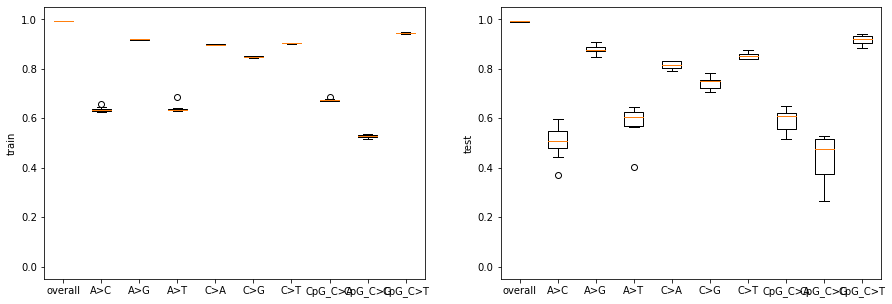

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.628268,0.573721,0.568701,0.505413
A>G,0.917537,0.901319,0.915870,0.899324
A>T,0.635332,0.609284,0.653108,0.628329
C>A,0.893558,0.864082,0.872418,0.837088
C>G,0.843522,0.801099,0.824286,0.776648
C>T,0.901042,0.880683,0.874477,0.848653
CpG_C>A,0.663348,0.626469,0.602914,0.559415
CpG_C>G,0.531491,0.494958,0.492968,0.453431
CpG_C>T,0.943677,0.932054,0.926926,0.911846
overall,0.994360,0.993372,0.993213,0.992023


Shape 2 degree; Sequence context: 3 degree
Class 0, Number of predictors: 295
Class 1, Number of predictors: 850
Class 2, Number of predictors: 197
Class 3, Number of predictors: 656
Class 4, Number of predictors: 344
Class 5, Number of predictors: 407
Class 6, Number of predictors: 154
Class 7, Number of predictors: 167
Class 8, Number of predictors: 312


C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.995444054225345
0.9432292255298282


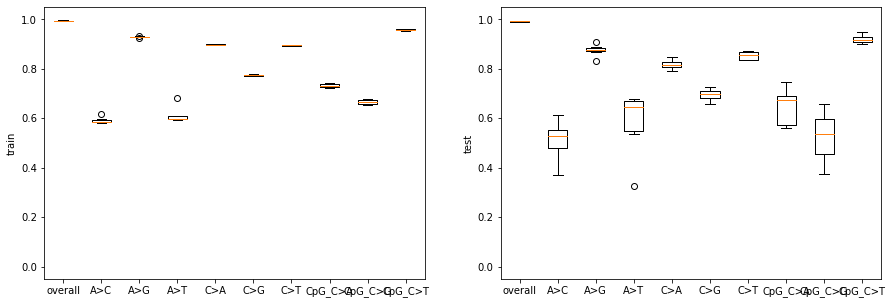

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.585846,0.553695,0.543395,0.507948
A>G,0.927085,0.907986,0.923850,0.903903
A>T,0.605188,0.585235,0.615676,0.596253
C>A,0.893377,0.864415,0.874875,0.840886
C>G,0.769698,0.740647,0.768128,0.738879
C>T,0.893491,0.877219,0.875983,0.857036
CpG_C>A,0.729806,0.681923,0.614639,0.546347
CpG_C>G,0.660036,0.593711,0.530183,0.438524
CpG_C>T,0.956606,0.937564,0.930121,0.899457
overall,0.995444,0.994717,0.993486,0.992446


Shape 2 degree; Sequence context: 4 degree
Class 0, Number of predictors: 373
Class 1, Number of predictors: 643
Class 2, Number of predictors: 286
Class 3, Number of predictors: 617
Class 4, Number of predictors: 550
Class 5, Number of predictors: 600
Class 6, Number of predictors: 207
Class 7, Number of predictors: 233
Class 8, Number of predictors: 527
0.9965973921612629
0.9525510954764077


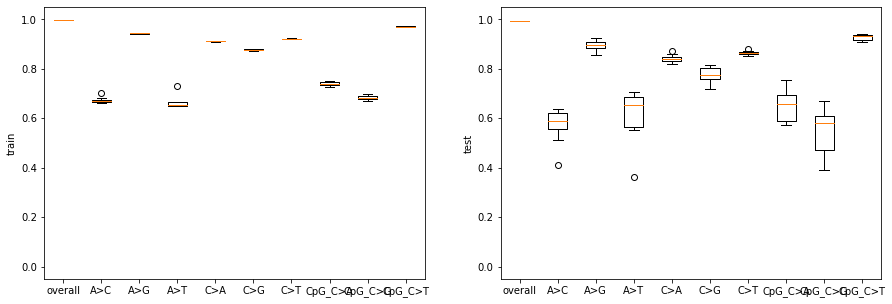

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.667510,0.634189,0.591645,0.550722
A>G,0.940950,0.929951,0.931424,0.918650
A>T,0.658313,0.632658,0.631481,0.603811
C>A,0.907886,0.884726,0.882470,0.852920
C>G,0.872036,0.844119,0.843659,0.809551
C>T,0.918519,0.898734,0.882117,0.853493
CpG_C>A,0.736823,0.670061,0.610559,0.511767
CpG_C>G,0.676010,0.580454,0.523936,0.383527
CpG_C>T,0.969133,0.936337,0.934214,0.864316
overall,0.996597,0.995929,0.993876,0.992673


In [90]:
pred_binned_all = [
    np.concatenate((Pred_2dneibr, Pred_sc_1d), axis=1), np.concatenate((Pred_2dneibr, Pred_sc_2d), axis=1), 
    np.concatenate((Pred_2dneibr, Pred_sc_3d), axis=1), np.concatenate((Pred_2dneibr, Pred_sc_4d), axis=1)
]

# Note:
# Currently, load "results_binned/Models_bin_n2_allclass.joblib" and "results_binned/Results_bin_n2_allclass.joblib"

for i in range(1, 5):
    dsc = str(i)
    print("Shape 2 degree; Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_bin = load_L1_indices(
        "data_intermediate/Results_L1_sh2neibr_sc"+dsc+".joblib", "data_intermediate/Models_L1_sh2neibr_sc"+dsc+".joblib")
    Model, CV_L1, Result = standard_l1modelfitting(
        pred_binned_all[i-1], Eff, Eff_test, Index_class, Indices_rmL1_bin, Kfoldobj, n_jobs=3)
    dump(Model, "data_out/Model_sh2neibr_sc"+dsc+".joblib")
    dump(CV_L1, "data_out/Results_sh2neibr_sc"+dsc+".joblib")
    Result.to_csv("data_out/Indtest_sh2neibr_sc"+dsc+".csv")

### Neighboring only interactions in seqcon?

What if we run neighboring interactions only with seqcon combined with neighboring only shapes?

#### 1st order shape + 2nd to 4th degree sequence context (neighbors only)

Use 1st order shape features plus different sequence context predictors.

Shape 1 degree; Sequence context: 2 degree
Class 0, Number of predictors: 114
Class 1, Number of predictors: 128
Class 2, Number of predictors: 128
Class 3, Number of predictors: 136
Class 4, Number of predictors: 132
Class 5, Number of predictors: 41
Class 6, Number of predictors: 43
Class 7, Number of predictors: 69
Class 8, Number of predictors: 108
0.9908033530237688
0.854359035030396


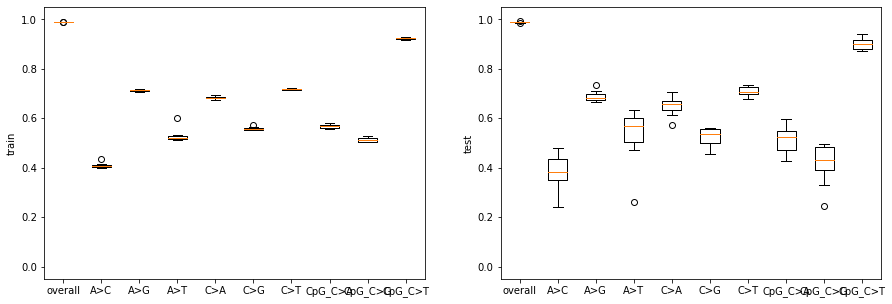

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.406553,0.389559,0.386242,0.368667
A>G,0.711991,0.702699,0.720573,0.711557
A>T,0.526355,0.511072,0.555155,0.540801
C>A,0.681077,0.666299,0.683429,0.668760
C>G,0.556230,0.536299,0.569222,0.549874
C>T,0.716180,0.712339,0.718338,0.714527
CpG_C>A,0.568499,0.549566,0.538631,0.518387
CpG_C>G,0.508900,0.473380,0.455661,0.416290
CpG_C>T,0.921884,0.912664,0.909344,0.898644
overall,0.990803,0.990454,0.990260,0.989890


Shape 1 degree; Sequence context: 3 degree
Class 0, Number of predictors: 200
Class 1, Number of predictors: 228
Class 2, Number of predictors: 209
Class 3, Number of predictors: 191
Class 4, Number of predictors: 181
Class 5, Number of predictors: 143
Class 6, Number of predictors: 114
Class 7, Number of predictors: 88
Class 8, Number of predictors: 147
0.9920958991702474
0.8907023263293267


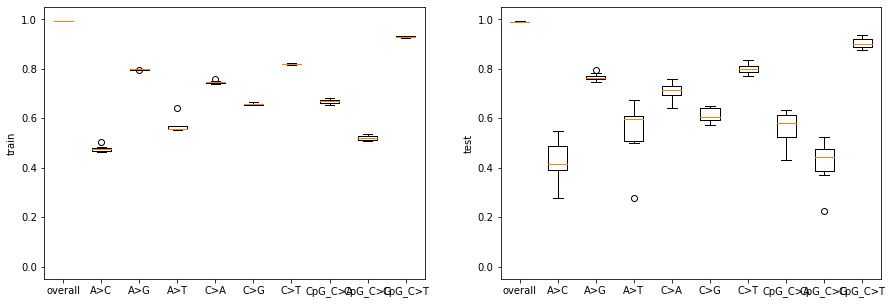

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.472877,0.445810,0.448014,0.419670
A>G,0.795752,0.783709,0.803383,0.791791
A>T,0.564369,0.540939,0.592190,0.570256
C>A,0.743767,0.726774,0.742636,0.725568
C>G,0.654954,0.633343,0.664440,0.643424
C>T,0.818727,0.809874,0.816211,0.807235
CpG_C>A,0.662389,0.620048,0.605201,0.555688
CpG_C>G,0.516532,0.471030,0.466227,0.415989
CpG_C>T,0.928016,0.915936,0.915369,0.901167
overall,0.992096,0.991582,0.991455,0.990900


Shape 1 degree; Sequence context: 4 degree
Class 0, Number of predictors: 381
Class 1, Number of predictors: 475
Class 2, Number of predictors: 344
Class 3, Number of predictors: 317
Class 4, Number of predictors: 255
Class 5, Number of predictors: 183
Class 6, Number of predictors: 144
Class 7, Number of predictors: 110
Class 8, Number of predictors: 161
0.992732489083073
0.9126044346969515


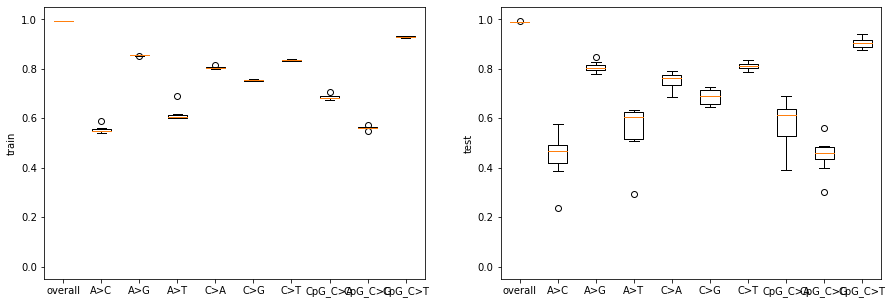

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.547494,0.501073,0.502069,0.450988
A>G,0.852671,0.833339,0.854458,0.835361
A>T,0.608706,0.572821,0.610134,0.574380
C>A,0.801819,0.779007,0.801000,0.778094
C>G,0.749747,0.727086,0.753540,0.731223
C>T,0.833373,0.822815,0.825432,0.814371
CpG_C>A,0.680597,0.628271,0.616246,0.553378
CpG_C>G,0.556518,0.503087,0.494583,0.433690
CpG_C>T,0.929813,0.916704,0.917333,0.901893
overall,0.992732,0.991957,0.992009,0.991156


In [27]:
pred_binned_all = [None, None, 
    np.concatenate((Pred_1d, Pred_sc_2dneibr), axis=1), 
    np.concatenate((Pred_1d, Pred_sc_3dneibr), axis=1), np.concatenate((Pred_1d, Pred_sc_4dneibr), axis=1)
]

for i in range(2, 5):
    dsc = str(i)
    print("Shape 1 degree; Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_bin_neibr = load_L1_indices(
        "data_intermediate/Results_L1_sh1_sc"+dsc+"neibr.joblib", "data_intermediate/Models_L1_sh1_sc"+dsc+"neibr.joblib")
    Model, CV_L1, Result = standard_l1modelfitting(
        pred_binned_all[i], Eff, Eff_test, Index_class, Indices_rmL1_bin_neibr, Kfoldobj, n_jobs=3)
    dump(Model, "data_out/Model_sh1_sc"+dsc+"neibr.joblib")
    dump(CV_L1, "data_out/Results_sh1_sc"+dsc+"neibr.joblib")
    Result.to_csv("data_out/Indtest_sh1_sc"+dsc+"neibr.csv")

#### 2nd order shape + 2nd to 4th degree sequence context (neighbors only)

Shape 1 degree; Sequence context: 2 degree
Class 0, Number of predictors: 611
Class 1, Number of predictors: 701
Class 2, Number of predictors: 293
Class 3, Number of predictors: 727
Class 4, Number of predictors: 601
Class 5, Number of predictors: 479
Class 6, Number of predictors: 145
Class 7, Number of predictors: 88
Class 8, Number of predictors: 196
0.9946617947611877
0.9395942252955375


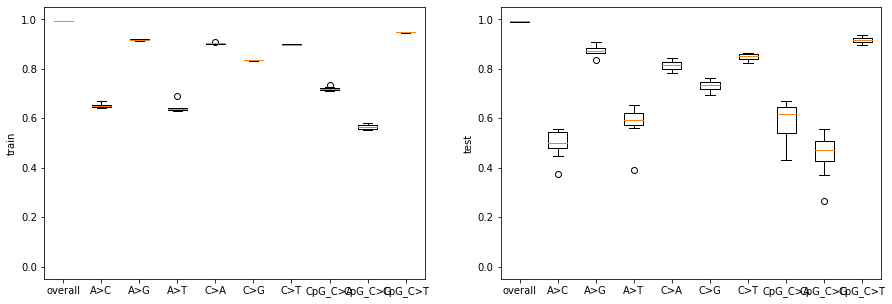

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.642507,0.579813,0.573556,0.498769
A>G,0.915612,0.898182,0.913580,0.895731
A>T,0.636878,0.608894,0.653401,0.626690
C>A,0.899618,0.868484,0.874676,0.835806
C>G,0.829834,0.788429,0.815706,0.770864
C>T,0.895194,0.875826,0.869850,0.845798
CpG_C>A,0.712564,0.665094,0.632356,0.571640
CpG_C>G,0.559440,0.517976,0.496807,0.449447
CpG_C>T,0.947289,0.934796,0.926101,0.908586
overall,0.994662,0.993673,0.993154,0.991886


Shape 1 degree; Sequence context: 3 degree
Class 0, Number of predictors: 711
Class 1, Number of predictors: 654
Class 2, Number of predictors: 451
Class 3, Number of predictors: 418
Class 4, Number of predictors: 926
Class 5, Number of predictors: 424
Class 6, Number of predictors: 64
Class 7, Number of predictors: 114
Class 8, Number of predictors: 130
0.9931227650484108
0.9363012006971858


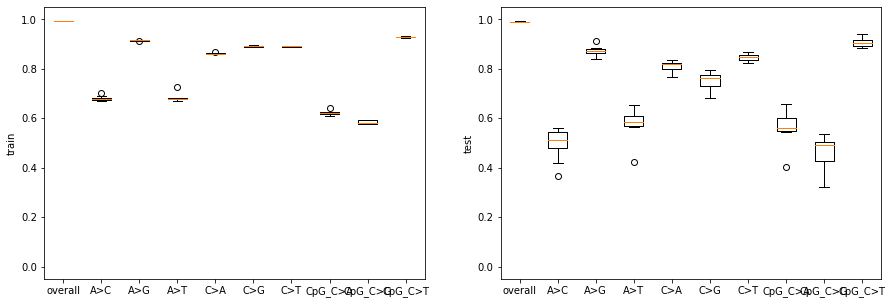

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.669924,0.600573,0.591071,0.505152
A>G,0.912970,0.896429,0.912557,0.895938
A>T,0.676068,0.635976,0.674641,0.634373
C>A,0.859411,0.837261,0.850684,0.827158
C>G,0.884457,0.834577,0.845683,0.779063
C>T,0.888539,0.870685,0.867767,0.846585
CpG_C>A,0.616744,0.591167,0.566166,0.537214
CpG_C>G,0.577464,0.524473,0.506067,0.444121
CpG_C>T,0.927780,0.917266,0.913764,0.901210
overall,0.993123,0.991829,0.992208,0.990742


Shape 1 degree; Sequence context: 4 degree
Class 0, Number of predictors: 507
Class 1, Number of predictors: 698
Class 2, Number of predictors: 134
Class 3, Number of predictors: 422
Class 4, Number of predictors: 393
Class 5, Number of predictors: 456
Class 6, Number of predictors: 105
Class 7, Number of predictors: 94
Class 8, Number of predictors: 173
0.9937173769484154
0.9343961277698566


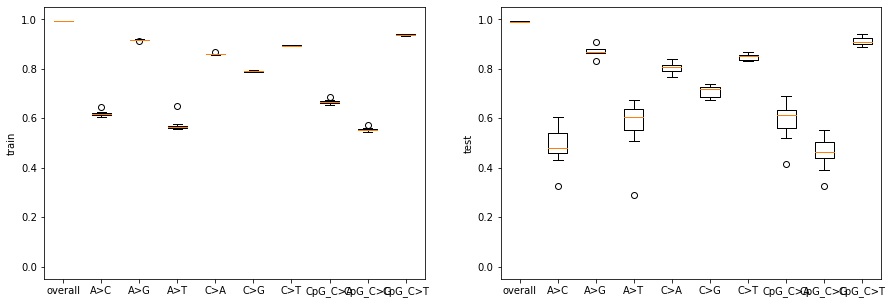

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.611937,0.557102,0.554667,0.491739
A>G,0.914442,0.896863,0.914195,0.896564
A>T,0.570018,0.555472,0.589862,0.575987
C>A,0.856662,0.833828,0.849809,0.825883
C>G,0.785950,0.754537,0.787083,0.755837
C>T,0.891258,0.872296,0.870296,0.847679
CpG_C>A,0.664291,0.625893,0.606178,0.561133
CpG_C>G,0.554134,0.509019,0.489954,0.438345
CpG_C>T,0.936287,0.923320,0.921877,0.905977
overall,0.993717,0.992850,0.992785,0.991788


In [28]:
pred_binned_all = [None, None, 
    np.concatenate((Pred_2dneibr, Pred_sc_2dneibr), axis=1), 
    np.concatenate((Pred_2dneibr, Pred_sc_3dneibr), axis=1), np.concatenate((Pred_2dneibr, Pred_sc_4dneibr), axis=1)
]

for i in range(2, 5):
    dsc = str(i)
    print("Shape 1 degree; Sequence context: "+dsc+" degree")
    alpha_list, Indices_rmL1_bin_neibr = load_L1_indices(
        "data_intermediate/Results_L1_sh2neibr_sc"+dsc+"neibr.joblib", "data_intermediate/Models_L1_sh2neibr_sc"+dsc+"neibr.joblib")
    Model, CV_L1, Result = standard_l1modelfitting(
        pred_binned_all[i], Eff, Eff_test, Index_class, Indices_rmL1_bin_neibr, Kfoldobj, n_jobs=3)
    dump(Model, "data_out/Model_sh2neibr_sc"+dsc+"neibr.joblib")
    dump(CV_L1, "data_out/Results_sh2neibr_sc"+dsc+"neibr.joblib")
    Result.to_csv("data_out/Indtest_sh2neibr_sc"+dsc+"neibr.csv")

## Model comparison

Compare all the models we've had so far:

In [91]:
# This chunk imports the saved results csvs
import_name = ["sc4Varun", "sh1", "sh2neibr", "sc4", "sh1_sc1", "sh1_sc2", "sh1_sc3", "sh1_sc4", 
               "sh2neibr_sc1", "sh2neibr_sc2", "sh2neibr_sc3", "sh2neibr_sc4"]
display_name = ["Aggarwala", "sh1", "sh2neibr", "sc4", "sh1_sc1", "sh1_sc2", "sh1_sc3", "sh1_sc4",
                "sh2neibr_sc1", "sh2neibr_sc2", "sh2neibr_sc3", "sh2neibr_sc4"]

r2_baseline = np.zeros(shape=(10,), dtype=float)
for select in range(9):
    r2_baseline[select] = r2_score(Eff_test[Index_class==select], Eff[Index_class==select])
r2_baseline[9] = r2_score(Eff_test, Eff)

temp_disp_r2train, temp_disp_r2test = pd.DataFrame({'baseline': [1,1,1,1,1,1,1,1,1,1]}), pd.DataFrame({'baseline': r2_baseline})

chnameflag = True
for i in range(len(import_name)):
    import_df = pd.read_csv("data_out/Indtest_" + import_name[i] + ".csv", index_col=0)
    if chnameflag:
        temp_disp_r2train.index, temp_disp_r2test.index = import_df.index, import_df.index
        chnameflag = False
    temp_disp_r2train[display_name[i]] = import_df['train_R2']
    temp_disp_r2test[display_name[i]] = import_df['test_R2']

temp_disp_r2train.to_csv("data_out/Results_compar_bin_train.csv")
temp_disp_r2test.to_csv("data_out/Results_compar_bin_test.csv")

display(temp_disp_r2train)
display(temp_disp_r2test)

,baseline,Aggarwala,sh1,sh2neibr,sc4,sh1_sc1,sh1_sc2,sh1_sc3,sh1_sc4,sh2neibr_sc1,sh2neibr_sc2,sh2neibr_sc3,sh2neibr_sc4
A>C,1,0.580066,0.309833,0.648458,0.653274,0.355153,0.475929,0.572164,0.677261,0.649310,0.628268,0.585846,0.667510
A>G,1,0.915877,0.607715,0.926287,0.937805,0.650088,0.790398,0.892448,0.939826,0.924084,0.917537,0.927085,0.940950
A>T,1,0.566845,0.457312,0.686432,0.606204,0.482227,0.536283,0.596943,0.638922,0.634905,0.635332,0.605188,0.658313
C>A,1,0.839504,0.580184,0.886260,0.907601,0.626443,0.732724,0.858301,0.904129,0.896176,0.893558,0.893377,0.907886
C>G,1,0.810782,0.434593,0.864279,0.867100,0.496007,0.618944,0.757272,0.868681,0.881823,0.843522,0.769698,0.872036
C>T,1,0.870864,0.716030,0.896343,0.915258,0.737985,0.825249,0.886914,0.915523,0.907683,0.901042,0.893491,0.918519
CpG_C>A,1,0.576305,0.591887,0.704173,0.753092,0.628761,0.624187,0.745102,0.754992,0.698754,0.663348,0.729806,0.736823
CpG_C>G,1,0.564764,0.490682,0.604332,0.689576,0.499291,0.531282,0.687284,0.695658,0.557023,0.531491,0.660036,0.676010
CpG_C>T,1,0.930057,0.878316,0.943422,0.963826,0.901078,0.932139,0.955957,0.965521,0.945931,0.943677,0.956606,0.969133
overall,1,0.993163,0.986759,0.994473,0.996177,0.988857,0.992333,0.995168,0.996331,0.994638,0.994360,0.995444,0.996597


,baseline,Aggarwala,sh1,sh2neibr,sc4,sh1_sc1,sh1_sc2,sh1_sc3,sh1_sc4,sh2neibr_sc1,sh2neibr_sc2,sh2neibr_sc3,sh2neibr_sc4
A>C,0.666291,0.580254,0.299829,0.578731,0.581512,0.341260,0.455424,0.532820,0.586199,0.579134,0.568701,0.543395,0.591645
A>G,0.961144,0.919987,0.615280,0.922207,0.929313,0.658699,0.800481,0.893368,0.930415,0.920586,0.915870,0.923850,0.931424
A>T,0.749556,0.605163,0.489098,0.672824,0.591188,0.514254,0.569259,0.603209,0.610173,0.650158,0.653108,0.615676,0.631481
C>A,0.905103,0.840336,0.578703,0.868189,0.876613,0.624594,0.730663,0.845032,0.877821,0.872901,0.872418,0.874875,0.882470
C>G,0.866793,0.819134,0.450661,0.833801,0.841049,0.512664,0.627984,0.758253,0.842336,0.843934,0.824286,0.768128,0.843659
C>T,0.863786,0.875378,0.714377,0.869824,0.877599,0.735687,0.816539,0.871354,0.877930,0.872579,0.874477,0.875983,0.882117
CpG_C>A,0.533678,0.553423,0.559250,0.634640,0.610416,0.578570,0.574152,0.618078,0.609131,0.626211,0.602914,0.614639,0.610559
CpG_C>G,0.416735,0.530545,0.440194,0.517474,0.526647,0.448816,0.490520,0.528789,0.526087,0.480210,0.492968,0.530183,0.523936
CpG_C>T,0.934435,0.932358,0.866938,0.925088,0.931482,0.889348,0.916414,0.930460,0.932331,0.926038,0.926926,0.930121,0.934214
overall,0.993994,0.993584,0.986428,0.993148,0.993644,0.988423,0.991479,0.993304,0.993718,0.993192,0.993213,0.993486,0.993876


Plot them out:

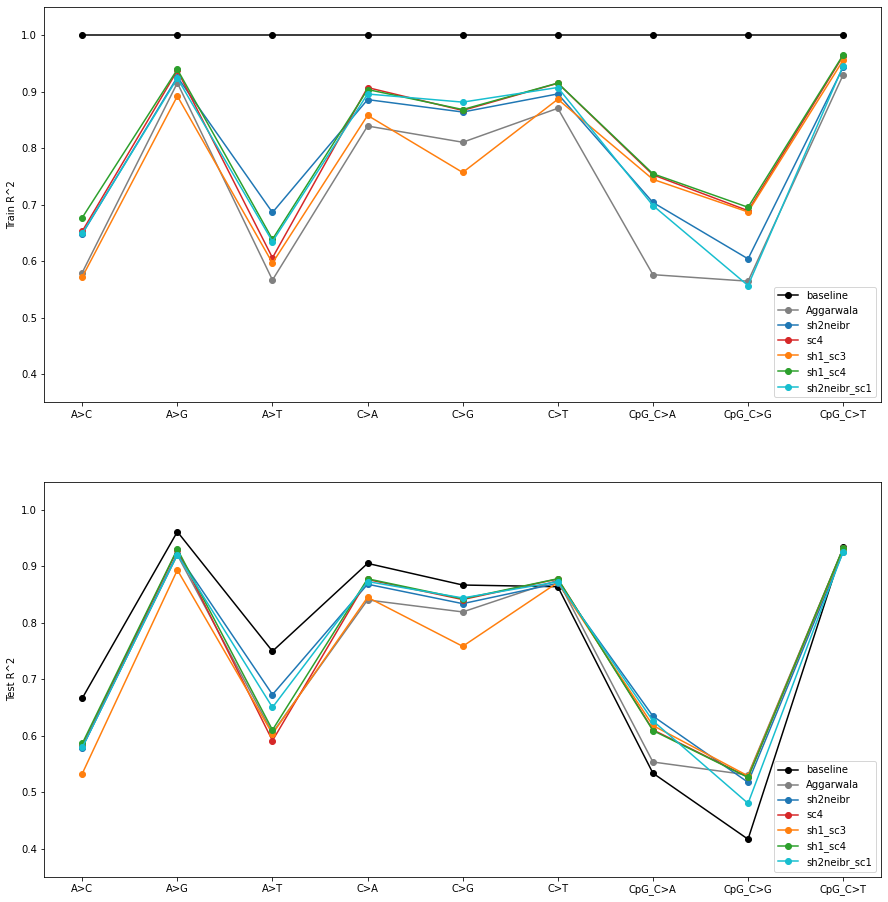

In [92]:
temp_fig = plt.figure(figsize=[15, 16])
legends = ['baseline', 'Aggarwala', 'sh2neibr', "sc4", "sh1_sc3", "sh1_sc4", "sh2neibr_sc1"]
colors = ['k', 'gray', 'tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:cyan']
plt.subplot(211)
for i in range(len(legends)):
    plt.plot(np.array(temp_disp_r2train[legends[i]].iloc[0:9]), marker='o', color=colors[i])
plt.legend(legends, loc='lower right')
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylim(0.35, 1.05)
plt.ylabel("Train R^2")
plt.subplot(212)
for i in range(len(legends)):
    plt.plot(np.array(temp_disp_r2test[legends[i]].iloc[0:9]), marker='o', color=colors[i])
plt.legend(legends, loc='lower right')
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylim(0.35, 1.05)
plt.ylabel("Test R^2")
plt.show()
#temp_fig.savefig("manuscript/figures/pltout_fig1a")

How do the neighbor-only models fare against all-interaction models?

In [93]:
import_name = ["sh1", "sh2", "sh2neibr", "sc2", "sc2neibr", "sc3", "sc3neibr", "sc4", "sc4neibr", 
               "sh1_sc2", "sh1_sc2neibr", "sh1_sc3", "sh1_sc3neibr", 
               "sh1_sc4", "sh1_sc4neibr",
               "sh2neibr_sc2", "sh2neibr_sc2neibr", "sh2neibr_sc3", "sh2neibr_sc3neibr", 
               "sh2neibr_sc4", "sh2neibr_sc4neibr"]

r2_baseline = np.zeros(shape=(10,), dtype=float)
for select in range(9):
    r2_baseline[select] = r2_score(Eff_test[Index_class==select], Eff[Index_class==select])
r2_baseline[9] = r2_score(Eff_test, Eff)

temp_disp_r2train, temp_disp_r2test = pd.DataFrame({'baseline': [1,1,1,1,1,1,1,1,1,1]}), pd.DataFrame({'baseline': r2_baseline})

chnameflag = True
for i in range(len(import_name)):
    import_df = pd.read_csv("data_out/Indtest_" + import_name[i] + ".csv", index_col=0)
    if chnameflag:
        temp_disp_r2train.index, temp_disp_r2test.index = import_df.index, import_df.index
        chnameflag = False
    temp_disp_r2train[import_name[i]] = import_df['train_R2']
    temp_disp_r2test[import_name[i]] = import_df['test_R2']

temp_disp_r2train.to_csv("data_out/Results_compar_neighbor_train.csv")
temp_disp_r2test.to_csv("data_out/Results_compar_neighbor_test.csv")

display(temp_disp_r2train)
display(temp_disp_r2test)

,baseline,sh1,sh2,sh2neibr,sc2,sc2neibr,sc3,sc3neibr,sc4,sc4neibr,...,sh1_sc3,sh1_sc3neibr,sh1_sc4,sh1_sc4neibr,sh2neibr_sc2,sh2neibr_sc2neibr,sh2neibr_sc3,sh2neibr_sc3neibr,sh2neibr_sc4,sh2neibr_sc4neibr
A>C,1,0.309833,0.597699,0.648458,0.426719,0.334714,0.568934,0.427025,0.653274,0.482667,...,0.572164,0.472877,0.677261,0.547494,0.628268,0.642507,0.585846,0.669924,0.667510,0.611937
A>G,1,0.607715,0.922733,0.926287,0.746094,0.640797,0.893989,0.729320,0.937805,0.743922,...,0.892448,0.795752,0.939826,0.852671,0.917537,0.915612,0.927085,0.912970,0.940950,0.914442
A>T,1,0.457312,0.670343,0.686432,0.510145,0.459333,0.592268,0.520594,0.606204,0.562553,...,0.596943,0.564369,0.638922,0.608706,0.635332,0.636878,0.605188,0.676068,0.658313,0.570018
C>A,1,0.580184,0.910672,0.886260,0.661170,0.597710,0.825176,0.696137,0.907601,0.760988,...,0.858301,0.743767,0.904129,0.801819,0.893558,0.899618,0.893377,0.859411,0.907886,0.856662
C>G,1,0.434593,0.867692,0.864279,0.557901,0.457661,0.755344,0.604991,0.867100,0.711299,...,0.757272,0.654954,0.868681,0.749747,0.843522,0.829834,0.769698,0.884457,0.872036,0.785950
C>T,1,0.716030,0.898180,0.896343,0.791988,0.715998,0.884995,0.805945,0.915258,0.826944,...,0.886914,0.818727,0.915523,0.833373,0.901042,0.895194,0.893491,0.888539,0.918519,0.891258
CpG_C>A,1,0.591887,0.695228,0.704173,0.632004,0.557412,0.738058,0.615573,0.753092,0.656902,...,0.745102,0.662389,0.754992,0.680597,0.663348,0.712564,0.729806,0.616744,0.736823,0.664291
CpG_C>G,1,0.490682,0.620062,0.604332,0.521883,0.425060,0.656114,0.496727,0.689576,0.548841,...,0.687284,0.516532,0.695658,0.556518,0.531491,0.559440,0.660036,0.577464,0.676010,0.554134
CpG_C>T,1,0.878316,0.934675,0.943422,0.922001,0.862377,0.952884,0.899792,0.963826,0.923577,...,0.955957,0.928016,0.965521,0.929813,0.943677,0.947289,0.956606,0.927780,0.969133,0.936287
overall,1,0.986759,0.993805,0.994473,0.991169,0.985732,0.994898,0.989442,0.996177,0.991510,...,0.995168,0.992096,0.996331,0.992732,0.994360,0.994662,0.995444,0.993123,0.996597,0.993717


,baseline,sh1,sh2,sh2neibr,sc2,sc2neibr,sc3,sc3neibr,sc4,sc4neibr,...,sh1_sc3,sh1_sc3neibr,sh1_sc4,sh1_sc4neibr,sh2neibr_sc2,sh2neibr_sc2neibr,sh2neibr_sc3,sh2neibr_sc3neibr,sh2neibr_sc4,sh2neibr_sc4neibr
A>C,0.666291,0.299829,0.538520,0.578731,0.413254,0.326221,0.527979,0.407497,0.581512,0.446439,...,0.532820,0.448014,0.586199,0.502069,0.568701,0.573556,0.543395,0.591071,0.591645,0.554667
A>G,0.961144,0.615280,0.920418,0.922207,0.755598,0.649499,0.894514,0.739321,0.929313,0.750784,...,0.893368,0.803383,0.930415,0.854458,0.915870,0.913580,0.923850,0.912557,0.931424,0.914195
A>T,0.749556,0.489098,0.672069,0.672824,0.543133,0.495868,0.596595,0.550692,0.591188,0.572760,...,0.603209,0.592190,0.610173,0.610134,0.653108,0.653401,0.615676,0.674641,0.631481,0.589862
C>A,0.905103,0.578703,0.883743,0.868189,0.666181,0.607692,0.816076,0.701824,0.876613,0.765171,...,0.845032,0.742636,0.877821,0.801000,0.872418,0.874676,0.874875,0.850684,0.882470,0.849809
C>G,0.866793,0.450661,0.836551,0.833801,0.571532,0.475512,0.757107,0.618433,0.841049,0.717907,...,0.758253,0.664440,0.842336,0.753540,0.824286,0.815706,0.768128,0.845683,0.843659,0.787083
C>T,0.863786,0.714377,0.870506,0.869824,0.784710,0.718508,0.869194,0.801224,0.877599,0.818741,...,0.871354,0.816211,0.877930,0.825432,0.874477,0.869850,0.875983,0.867767,0.882117,0.870296
CpG_C>A,0.533678,0.559250,0.631292,0.634640,0.587290,0.526544,0.607113,0.571355,0.610416,0.594880,...,0.618078,0.605201,0.609131,0.616246,0.602914,0.632356,0.614639,0.566166,0.610559,0.606178
CpG_C>G,0.416735,0.440194,0.532281,0.517474,0.484295,0.396678,0.535023,0.457568,0.526647,0.497089,...,0.528789,0.466227,0.526087,0.494583,0.492968,0.496807,0.530183,0.506067,0.523936,0.489954
CpG_C>T,0.934435,0.866938,0.918123,0.925088,0.907726,0.850136,0.927502,0.888878,0.931482,0.912177,...,0.930460,0.915369,0.932331,0.917333,0.926926,0.926101,0.930121,0.913764,0.934214,0.921877
overall,0.993994,0.986428,0.992641,0.993148,0.990474,0.985396,0.993065,0.989051,0.993644,0.990966,...,0.993304,0.991455,0.993718,0.992009,0.993213,0.993154,0.993486,0.992208,0.993876,0.992785


### Combine different model settings for each substitution class

For each subclass, use the model that 1) gives the best predictive power, and 2) the simplest model. 

In [16]:
class linreg_subclass_binpred():
    """This makes a class of binned regression items with custom predictor selection."""
    def __init__(self, pred_used=None, model_indices=None, lin_or_log=None, n_jobs=1):
        self.paral = int(n_jobs)
        self.preduse = pred_used
        self.indices = model_indices
        self.model_type = lin_or_log

    def fit(self, Xlist=None, y=None, Subclass_list=None):
        subclass = np.array(Subclass_list)
        self.model = dict()
        for _iter in set(Subclass_list):
            if self.model_type[_iter] == 0:
                y_i = np.array(y)[subclass == _iter]
            elif self.model_type[_iter] == 1:
                y_i = np.log(y)[subclass == _iter]
            X_i = Xlist[self.preduse[_iter]][subclass == _iter][:, self.indices[_iter]]
            self.model[_iter] = LinearRegression(n_jobs=self.paral).fit(X_i, y_i)
        return self

    def predict(self, Xlist=None, Subclass_list=None):
        subclass = np.array(Subclass_list)
        tmpout = dict()
        iter_count = dict()
        for _iter in set(Subclass_list):
            X_i = Xlist[self.preduse[_iter]][subclass == _iter][:, self.indices[_iter]]
            if self.model_type[_iter] == 0:
                tmpout[_iter] = self.model[_iter].predict(X_i)
            elif self.model_type[_iter] == 1:
                tmpout[_iter] = np.exp(self.model[_iter].predict(X_i))
            iter_count[_iter] = 0
        # Make output
        out = np.zeros(shape=(len(Xlist[0]), ), dtype=float)
        for iter_i in range(len(subclass)):
            model_ind = subclass[iter_i]
            out[iter_i] = tmpout[model_ind][iter_count[model_ind]]
            iter_count[model_ind] += 1
        return out

In [17]:
model_info = ['sh2neibr', 'sh2neibr_sc1', 'sh1_sc3', 'sh1_sc4']
model_use = [3, 0, 0, 1, 1, 3, 0, 2, 2]

all_models = [load("data_intermediate/Models_L1_" + str(item) + ".joblib") for item in model_info]
results = [load("data_intermediate/Results_L1_" + str(item) + ".joblib") for item in model_info]
pred_list = [Pred_2dneibr, 
             np.concatenate((Pred_2dneibr, Pred_sc_1d), axis=1),
             np.concatenate((Pred_1d, Pred_sc_3d), axis=1),
             np.concatenate((Pred_1d, Pred_sc_4d), axis=1)]

Indices_rmL1_binpred, alpha_list = [], []
for select in range(9):
    min_loc = np.argmin(
        [np.mean(results[model_use[select]][select][key]['test_mse']) for key in results[model_use[select]][select].keys()]
    )
    alpha_list.append( list(results[model_use[select]][select].keys())[min_loc] )
    temp_pred = pred_list[model_use[select]][Index_class==select]
    Indices_rmL1_binpred.append( all_models[model_use[select]][select][alpha_list[select]].coef_ != 0 )
    print(np.sum(Indices_rmL1_binpred[select]))

Model_bin_L1_final = linreg_subclass_binpred(pred_used=model_use, model_indices=Indices_rmL1_binpred, lin_or_log=[0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                             n_jobs=4)
Model_bin_L1_final.fit(pred_list, Eff, Index_class)
tmp_out = Model_bin_L1_final.predict(pred_list, Index_class)
print(r2_score(Eff, tmp_out))   # This is the R^2 value
print(r2_score(Eff[Index_class!=8], tmp_out[Index_class!=8]))   # This is the R^2 value for non CpG C>T

# Save model
dump(Model_bin_L1_final, "data_out/Model_final.joblib")

C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


450
889
501
709
896
584
123
225
316
0.9955053314881283
0.9480289497085643


['data_out/Model_final.joblib']

In [18]:
p_length = [np.sum(Indices_rmL1_binpred[i]) for i in range(9)]
Result_bin_L1_final = standard_traintestresult_df(tmp_out, Eff, Eff_test, Index_class, p=p_length, display='df')
display(Result_bin_L1_final)
Result_bin_L1_final.to_csv("data_out/Indtest_final.csv")

# Save data
temp_df_save = pd.DataFrame({'Predicted': tmp_out,'Train': Eff, 'Test': Eff_test, 'Subclass': Index_class})
temp_df_save.to_csv("data_out/Model_final_plottingresults.csv", index=None)

,train_R2,train_R2_adj,test_R2,test_R2_adj
A>C,0.677261,0.637417,0.586199,0.535113
A>G,0.926287,0.905847,0.922207,0.900635
A>T,0.686432,0.642721,0.672824,0.627216
C>A,0.896176,0.865011,0.872901,0.834750
C>G,0.881823,0.833139,0.843934,0.779641
C>T,0.915523,0.895686,0.877930,0.849266
CpG_C>A,0.704173,0.663743,0.634640,0.584708
CpG_C>G,0.692423,0.605700,0.528725,0.395847
CpG_C>T,0.955957,0.936272,0.930460,0.899378
overall,0.995505,0.994444,0.993565,0.992046


Plot the training and testing scatterplots, return them for manuscript:

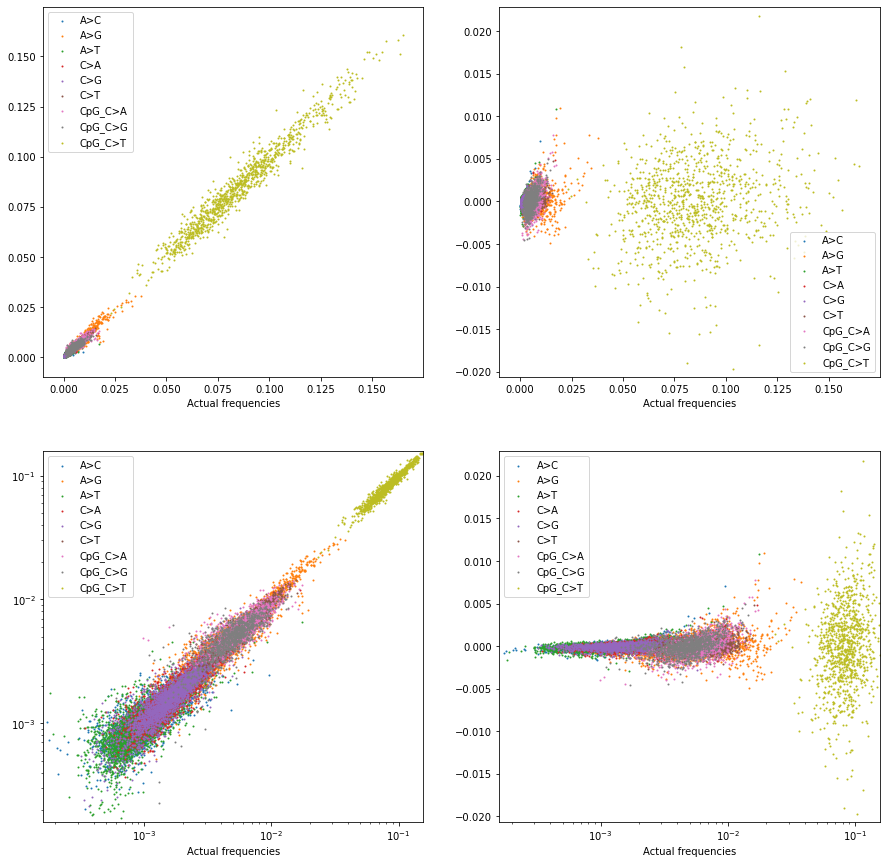

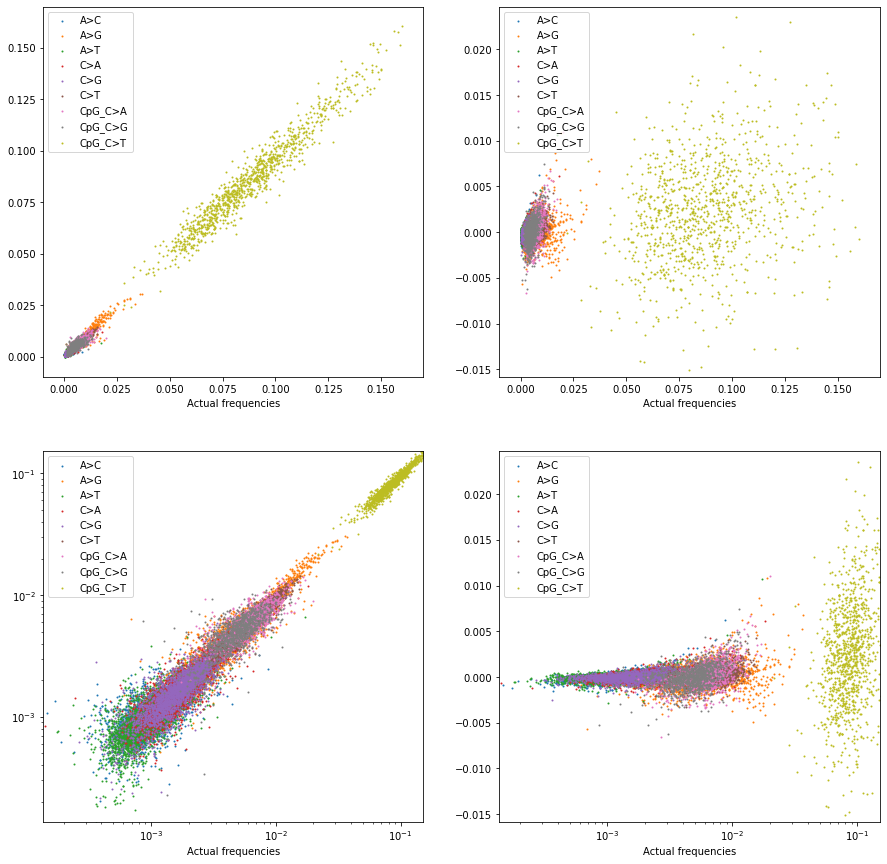

In [97]:
plot_scatter_residual(tmp_out, Eff, 1, use_index=True, index=Index_class, index_name=Index_class_name, 
                     filename="manuscript/figures/pltout_model_final_train.pdf")
plot_scatter_residual(tmp_out, Eff_test, 1, use_index=True, index=Index_class, index_name=Index_class_name, 
                     filename="manuscript/figures/pltout_fig2b_model_final_test.pdf")

Show plot difference between this, Varun's model, and the 4th degree sequence context:

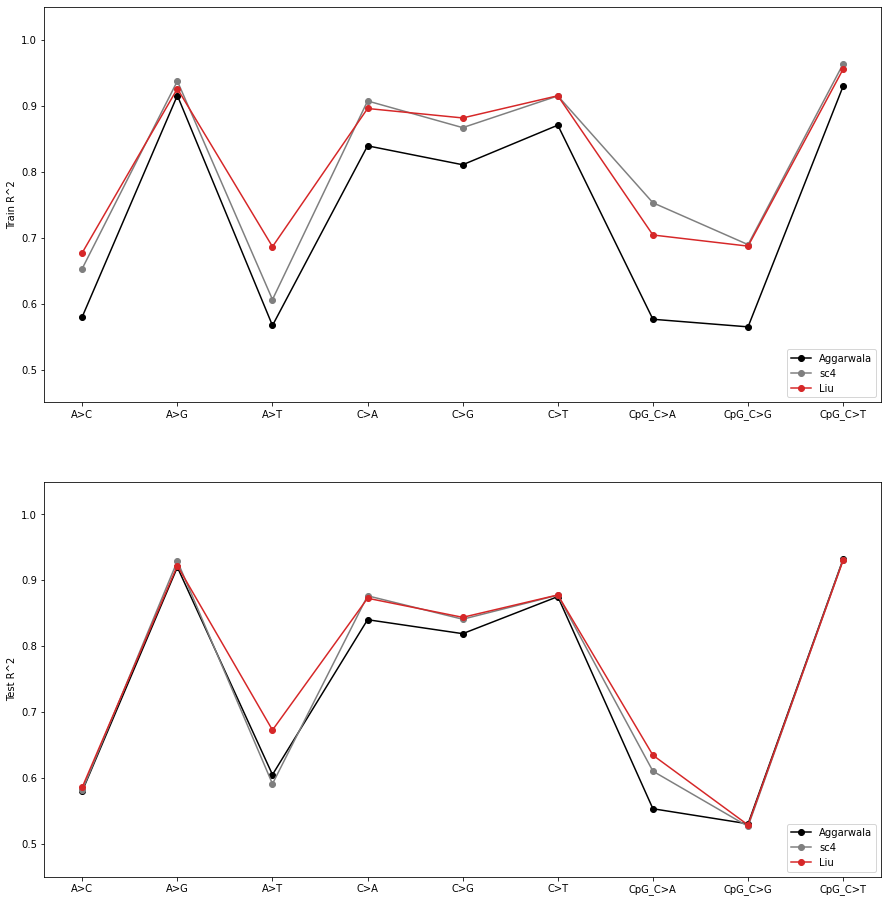

,Aggarwala,sc4,Liu
A>C,0.580254,0.581512,0.586199
A>G,0.919987,0.929313,0.922207
A>T,0.605163,0.591188,0.672824
C>A,0.840336,0.876613,0.872901
C>G,0.819134,0.841049,0.843934
C>T,0.875378,0.877599,0.877930
CpG_C>A,0.553423,0.610416,0.634640
CpG_C>G,0.530545,0.526647,0.528789
CpG_C>T,0.932358,0.931482,0.930460


In [98]:
temp_fig = plt.figure(figsize=[15, 16])
legends = ['Aggarwala', 'sc4', 'Liu']
# The six columns are Aggarwala train, Aggarwala test, sc4 train, sc4 test, final model train, final model test
temp_plt = [
    pd.read_csv("data_out/Results_compar_bin_train.csv", index_col=0)['Aggarwala'],
    pd.read_csv("data_out/Results_compar_bin_test.csv", index_col=0)['Aggarwala'],
    pd.read_csv("data_out/Results_compar_bin_train.csv", index_col=0)['sc4'],
    pd.read_csv("data_out/Results_compar_bin_test.csv", index_col=0)['sc4'],
    np.array(Result_bin_L1_final['train_R2']), np.array(Result_bin_L1_final['test_R2'])
]
plt.subplot(211)
plt.plot(temp_plt[0][0:9], marker='o', color='k')
plt.plot(temp_plt[2][0:9], marker='o', color='tab:gray')
plt.plot(temp_plt[4][0:9], marker='o', color='tab:red')
"""for i in range(9):
    plt.annotate(str(round(temp_plt[0][i], 3)), xy=(i, temp_plt[0][i]-0.05))
    plt.annotate(str(round(temp_plt[2][i], 3)), xy=(i, temp_plt[2][i]+0.05))"""
plt.legend(legends, loc='lower right')
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylim(0.45, 1.05)
plt.ylabel("Train R^2")
plt.subplot(212)
plt.plot(temp_plt[1][0:9], marker='o', color='k')
plt.plot(temp_plt[3][0:9], marker='o', color='tab:gray')
plt.plot(temp_plt[5][0:9], marker='o', color='tab:red')
"""for i in range(9):
    plt.annotate(str(round(temp_plt[1][i], 3)), xy=(i, temp_plt[1][i]-0.05))
    plt.annotate(str(round(temp_plt[3][i], 3)), xy=(i, temp_plt[3][i]+0.05))"""
plt.legend(legends, loc='lower right')
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylim(0.45, 1.05)
plt.ylabel("Test R^2")
plt.show()
temp_fig.savefig("manuscript/figures/pltout_fig2a_finalmodelcompar.pdf", dpi=300)

pd.DataFrame(
    {'Aggarwala': temp_plt[1][0:9], 'sc4': temp_plt[3][0:9], 'Liu': temp_plt[5][0:9]}
)

We can get the train/test results as above. 

#### Cross-mutation class analysis?

How does the best-performing model performs across mutation classes?

In [23]:
model_info = ['sh2neibr', 'sh2neibr_sc1', 'sh1_sc3', 'sh1_sc4']
model_use = [3, 0, 0, 1, 1, 3, 0, 2, 2]

all_models = [load("data_intermediate/Models_L1_" + str(item) + ".joblib") for item in model_info]
results = [load("data_intermediate/Results_L1_" + str(item) + ".joblib") for item in model_info]
pred_list = [Pred_2dneibr, 
             np.concatenate((Pred_2dneibr, Pred_sc_1d), axis=1),
             np.concatenate((Pred_1d, Pred_sc_3d), axis=1),
             np.concatenate((Pred_1d, Pred_sc_4d), axis=1)]

Indices_rmL1_binpred, alpha_list = [], []
for select in range(9):
    min_loc = np.argmin(
        [np.mean(results[model_use[select]][select][key]['test_mse']) for key in results[model_use[select]][select].keys()]
    )
    alpha_list.append( list(results[model_use[select]][select].keys())[min_loc] )
    temp_pred = pred_list[model_use[select]][Index_class==select]
    Indices_rmL1_binpred.append( all_models[model_use[select]][select][alpha_list[select]].coef_ != 0 )

Model_bin_L1_final = linreg_subclass_binpred(pred_used=model_use, model_indices=Indices_rmL1_binpred, lin_or_log=[0, 0, 0, 0, 0, 0, 0, 0, 0], 
                                             n_jobs=4)
Model_bin_L1_final.fit(pred_list, Eff, Index_class)

C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [24]:
# Make results
Results_predict_class = dict()
for select in range(9):
    Results_predict_class[select] = Model_bin_L1_final.predict(pred_list, np.full(shape=np.shape(Index_class), fill_value=select))
# Comparison results
results_allmodel = Model_bin_L1_final.predict(pred_list, Index_class)

For sanity check, see if results from our per-class results generation is the same as what we would get from using all models. The lists of equal values should be 4096*3, 3072*3, and 1024*3.

In [25]:
for select in range(9):
    print(np.sum( Results_predict_class[select] == results_allmodel ))

4096
4096
4096
3072
3072
3072
1024
1024
417


Something is wrong with class 8 (CpG C>T)?

In [35]:
print(Results_predict_class[8][Index_class==8])
print(results_allmodel[Index_class==8])
print(r2_score(Results_predict_class[8][Index_class==8], results_allmodel[Index_class==8]))

[0.11379864 0.09269574 0.10933545 ... 0.08167317 0.07037594 0.08003857]
[0.11379864 0.09269192 0.1093507  ... 0.08167317 0.07037594 0.08006909]
0.9999999322903333


Looks like there are some very minute floating-point changes for some reason. The R^2 value is high enough to ignore the differences.

Make the plot and R^2 table:

In [36]:
plotting_trio = np.empty(shape=(9, 9, 3), dtype=object)

for i in range(9):
    for j in range(9):
        plotting_trio[i, j, 0] = Results_predict_class[i][Index_class == j]
        plotting_trio[i, j, 1] = Eff[Index_class == j]
        plotting_trio[i, j, 2] = Eff_test[Index_class == j]

In [44]:
# Make the R^2 comparison tables
cross_model_r2table_train, cross_model_r2table_test = np.empty(shape=(9, 9), dtype=float), np.empty(shape=(9, 9), dtype=float)
for i in range(9):
    for j in range(9):
        cross_model_r2table_train[i, j] = r2_score(plotting_trio[i, j, 1], plotting_trio[i, j, 0])
        cross_model_r2table_test[i, j] = r2_score(plotting_trio[i, j, 2], plotting_trio[i, j, 0])
# Trim off below 0 values
cross_model_r2table_train[cross_model_r2table_train < 0] = 0
cross_model_r2table_test[cross_model_r2table_test < 0] = 0
# Beautify and formatting
cross_model_r2table_train = pd.DataFrame(cross_model_r2table_train)
cross_model_r2table_test = pd.DataFrame(cross_model_r2table_test)
tmp_index, tmp_col = ["Model_class_"+str(select) for select in range(9)], ["Data_class_"+str(select) for select in range(9)]
cross_model_r2table_train.index, cross_model_r2table_test.index = tmp_index, tmp_index
cross_model_r2table_train.columns, cross_model_r2table_test.columns = tmp_col, tmp_col
# Add 10th column as "reference":
cross_model_r2table_train['reference'] = [r2_score( plotting_trio[select, select, 1], results_allmodel[Index_class==select] ) for select in range(9)]
cross_model_r2table_test['reference'] = [r2_score( plotting_trio[select, select, 2], results_allmodel[Index_class==select] ) for select in range(9)]

display(cross_model_r2table_train)
display(cross_model_r2table_test)
# Save tables
with pd.ExcelWriter(path="data_out/Results_crossmodeltest.xlsx", mode='w') as savexcel:
    cross_model_r2table_train.to_excel(savexcel, sheet_name='train')
    cross_model_r2table_test.to_excel(savexcel, sheet_name='test')

,Data_class_0,Data_class_1,Data_class_2,Data_class_3,Data_class_4,Data_class_5,Data_class_6,Data_class_7,Data_class_8,reference
Model_class_0,0.677261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.677261
Model_class_1,0.000000,0.926287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.926287
Model_class_2,0.000000,0.000000,0.686432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.686432
Model_class_3,0.000000,0.000000,0.000000,0.896176,0.000000,0.000000,0.000000,0.000000,0.000000,0.896176
Model_class_4,0.000000,0.000000,0.000000,0.000000,0.881823,0.000000,0.000000,0.000000,0.000000,0.881823
Model_class_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.915523,0.000000,0.000000,0.000000,0.915523
Model_class_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.704173,0.000000,0.000000,0.704173
Model_class_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.692423,0.000000,0.692423
Model_class_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955956,0.955957


,Data_class_0,Data_class_1,Data_class_2,Data_class_3,Data_class_4,Data_class_5,Data_class_6,Data_class_7,Data_class_8,reference
Model_class_0,0.586199,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.586199
Model_class_1,0.000000,0.922207,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.922207
Model_class_2,0.000000,0.000000,0.672824,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.672824
Model_class_3,0.000000,0.000000,0.000000,0.872901,0.000000,0.00000,0.00000,0.000000,0.000000,0.872901
Model_class_4,0.000000,0.000000,0.000000,0.000000,0.843934,0.00000,0.00000,0.000000,0.000000,0.843934
Model_class_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.87793,0.00000,0.000000,0.000000,0.877930
Model_class_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.63464,0.000000,0.000000,0.634640
Model_class_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.528725,0.000000,0.528725
Model_class_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.930454,0.930460


As we can see, the models tend to perform poorly in other mutation classes.

## Coefficient analysis

Next, we will identify the top coefficients in our best performing models. Do this for each model, and then bin the outputs.

For comparison purposes, the coefficients are divided by the range of effectors ( max(Eff) - min(Eff) ) to ensure equal comparison.

We have done this for a few other models, but for interpretability reasons, we'll just do 2nd order shape.

In [45]:
# shape 2
temp_index = list(Labels_2dneibr)
alpha_list, Indices_rmL1_bin = load_L1_indices(
    "data_intermediate/Results_L1_sh2neibr.joblib", "data_intermediate/Models_L1_sh2neibr.joblib")
Model_bin_L1_02 = load("data_out/Model_sh2neibr.joblib")

DF_02_topcoefs = return_coefs_df(Model_bin_L1_02, Pred_2dneibr, Eff, Indices_rmL1_bin, temp_index, index_class=Index_class, 
                                index_class_labels=Index_class_name, save_filename="data_out/Coefs_sh2neibr.csv")
display(DF_02_topcoefs)

Class 0, Number of predictors: 629
Class 1, Number of predictors: 889
Class 2, Number of predictors: 501
Class 3, Number of predictors: 616
Class 4, Number of predictors: 770
Class 5, Number of predictors: 527
Class 6, Number of predictors: 123
Class 7, Number of predictors: 126
Class 8, Number of predictors: 175


,A>C,A>G,A>T,C>A,C>G,C>T,CpG_C>A,CpG_C>G,CpG_C>T
HelT_L,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HelT_CL,0.00000,0.000000,0.000000,1.387339,0.000000,0.000000,0.000000,0.000000,0.000000
HelT_CR,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051239
HelT_R,0.00000,0.000000,0.000000,0.000000,-0.003336,0.473789,-5.473866,0.000000,0.000000
Rise_L,0.28753,0.343765,0.000000,0.463717,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
MGW_R_r*MGW_R_r,0.00000,-0.215245,0.000000,0.666864,0.000000,0.000000,-0.302775,0.000000,0.000000
MGW_R_r*EP_R_r,-0.01217,0.000000,0.000000,0.547368,0.000000,0.000000,0.000000,0.193074,-0.958992
EP_L_r*EP_L_r,0.00000,0.000000,0.000000,0.000000,0.000000,-0.254604,0.000000,0.000000,0.000000
EP_C_r*EP_C_r,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Importing data

Next, re-import the coefficients from the shape 2 model:

In [46]:
DF_final_topcoefs = pd.read_csv("data_out/Coefs_sh2neibr.csv", index_col=0)
DF_final_topcoefs = DF_final_topcoefs[(DF_final_topcoefs.T != 0).any()]

display(DF_final_topcoefs)

,A>C,A>G,A>T,C>A,C>G,C>T,CpG_C>A,CpG_C>G,CpG_C>T
HelT_CL,0.00000,0.000000,0.000000,1.387339,0.000000,0.000000,0.000000,0.000000,0.000000
HelT_CR,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051239
HelT_R,0.00000,0.000000,0.000000,0.000000,-0.003336,0.473789,-5.473866,0.000000,0.000000
Rise_L,0.28753,0.343765,0.000000,0.463717,0.000000,0.000000,0.000000,0.000000,0.000000
Rise_CR,0.00000,0.000000,0.000000,0.730196,-4.785950,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
MGW_C_r*EP_R_r,0.44413,1.430056,0.040061,-0.176225,-1.286641,0.000000,0.000000,0.000000,0.803849
MGW_R_r*MGW_R_r,0.00000,-0.215245,0.000000,0.666864,0.000000,0.000000,-0.302775,0.000000,0.000000
MGW_R_r*EP_R_r,-0.01217,0.000000,0.000000,0.547368,0.000000,0.000000,0.000000,0.193074,-0.958992
EP_L_r*EP_L_r,0.00000,0.000000,0.000000,0.000000,0.000000,-0.254604,0.000000,0.000000,0.000000


Show the R^2 values (explained variance) when fitting L1 models:

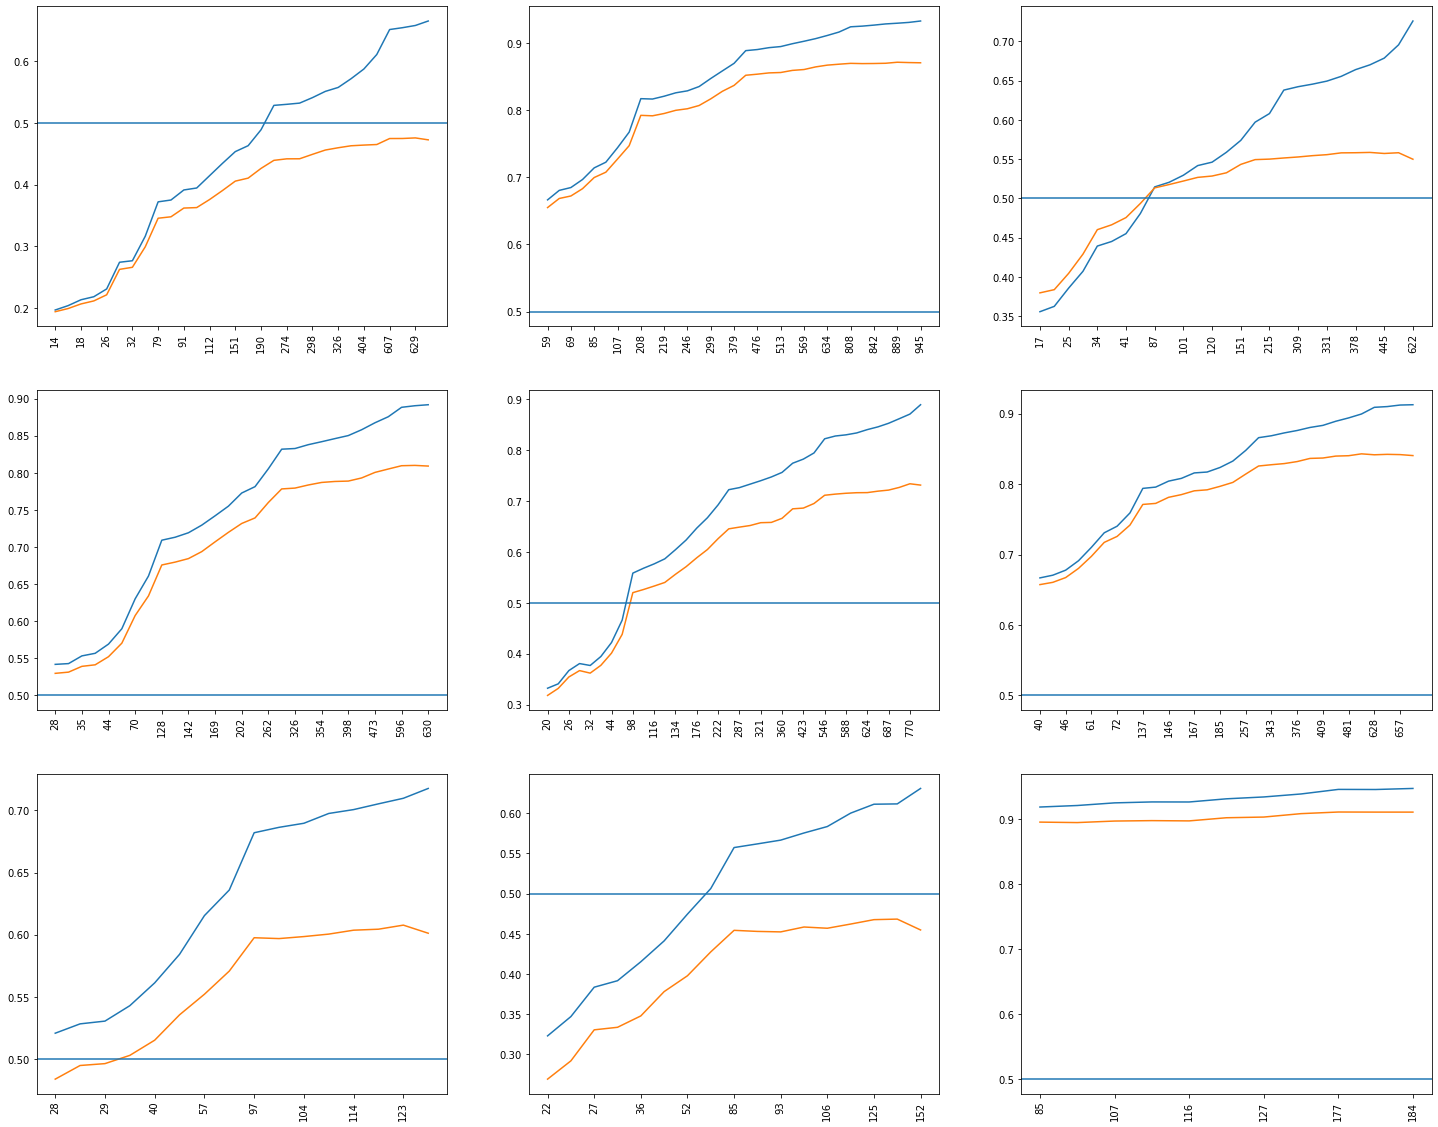

In [47]:
results_cv_sh2 = load("data_intermediate/Results_L1_sh2neibr.joblib")
models_cv_sh2 = load("data_intermediate/Models_L1_sh2neibr.joblib")

plt.figure(figsize=[25, 20])
for select in range(9):
    plt.subplot(int(331 + select))
    list_r2_train = [np.mean(results_cv_sh2[select][alpha]['train_r2']) for alpha in results_cv_sh2[select].keys()]
    list_r2_test = [np.mean(results_cv_sh2[select][alpha]['test_r2']) for alpha in results_cv_sh2[select].keys()]
    list_coef_len = [np.sum(models_cv_sh2[select][alpha].coef_ != 0) for alpha in models_cv_sh2[select].keys()]
    plt.plot(list_r2_train)
    plt.plot(list_r2_test)
    plt.xticks(np.arange(0, len(list_coef_len), 2), list_coef_len[::2], rotation='vertical')
    plt.axhline(0.5)
plt.show()

We can see that typically the top 100 features with the largest coefficients should contribute sufficiently to R^2 prediction. 

For each column, get the top indices and show their identities. Then, get their respective ranks in other models:

In [50]:
Sorted_index = dict()
for select in range(9):
    Sorted_index[select] = list(DF_final_topcoefs.abs().sort_values(by=list(DF_final_topcoefs.columns)[select], ascending=False).index)

display(pd.DataFrame(Sorted_index).iloc[0:10])

,0,1,2,3,4,5,6,7,8
0,Slide_L*Slide_CL,ProT_L*MGW_L_r,Shift_CR*HelT_R_r,Rise_L*Shear_L_r,HelT_L*Shift_L,Roll_L*Slide_L_r,HelT_R*HelT_R,Roll_R_r*Stagger_R_r,Rise_L*Rise_L_r
1,Roll_CL*HelT_CR_r,HelT_L*Roll_L,ProT_C*Stretch_R_r,Stretch_L*Slide_CL_r,HelT_L_r*Stagger_L_r,Shear_C*Stretch_C_r,HelT_R,Stagger_R_r*Stagger_R_r,Rise_L_r*Rise_L_r
2,HelT_CL*Slide_CL,Shift_L_r,Shift_CR*Rise_CR_r,EP_C*Buckle_R_r,Rise_CL*Rise_CR,MGW_L*Stretch_L_r,Buckle_R*Roll_R_r,MGW_C*MGW_R,Rise_L*Rise_L
3,HelT_CR_r*Shift_CR_r,MGW_C*Stretch_C_r,ProT_L*EP_C,Shear_C*Roll_CR_r,Slide_CR_r*ProT_R_r,Shear_C*Opening_R_r,Roll_CL*Tilt_CR,HelT_CR*Slide_R,Shear_R*Shear_R_r
4,ProT_C*EP_R,Rise_L*Roll_L,HelT_L_r*HelT_L_r,HelT_L*Shear_L,Shear_L*HelT_L_r,Roll_R*Roll_R_r,Buckle_R*MGW_R_r,Stagger_C_r*Stretch_R_r,Shear_R*Shear_R
5,Slide_R_r*Shear_R_r,Tilt_L*Rise_L_r,EP_L*Slide_CL_r,Rise_CL_r*Opening_C_r,Slide_L*HelT_L_r,Roll_L*EP_C,Roll_L*Roll_CL,Shift_L*Stretch_L_r,Shear_R_r*Shear_R_r
6,Slide_CL*Shift_CR_r,Slide_CR_r*Opening_R_r,ProT_L_r*EP_C_r,Shift_CL_r*Slide_CR_r,HelT_L_r*Shift_L_r,Stagger_C*HelT_R_r,Stagger_C*Roll_R_r,Tilt_CL_r*ProT_C_r,Shift_R*Slide_R
7,HelT_R*Stagger_R,Slide_CR_r*Slide_CR_r,Roll_L_r*Shear_C_r,Stretch_C*MGW_R_r,Buckle_L_r*EP_L_r,HelT_L*Tilt_L,Slide_L_r*MGW_L_r,Tilt_L_r*Opening_L_r,Shift_R*Slide_R_r
8,ProT_R*HelT_R_r,HelT_L*ProT_C_r,ProT_R*Shift_R_r,HelT_L*Shift_CL_r,HelT_CR_r*Tilt_CR_r,MGW_C*MGW_C,Stretch_R*Stagger_R_r,Roll_CR*Stretch_R,Slide_L*Slide_L_r
9,Opening_L*HelT_L_r,HelT_L_r*Roll_L_r,HelT_L_r,Slide_CL*Roll_CR_r,ProT_C_r*Shear_C_r,HelT_L_r*Buckle_L_r,Tilt_R_r*Opening_R_r,Slide_R*Slide_R_r,Slide_L*Slide_L


Plot the relative shape importances using this framework: 

Define each feature as a combination of 1st order features: one shape feature or one nucleotide. Discard shape feature's location information, while encode each of the 6 possible nucleotide locations along with 4 possible nucleotides into 24 elementary features.

Then, apply this framework to the top indices and see which indices are most common.

In [51]:
Index_all = list(DF_final_topcoefs.index)

# Make shape indices
Index_all_scoring_shape = np.zeros(shape=(len(Index_all), ), dtype=object)
for i in range(len(Index_all)):
    item = Index_all[i].split('*')
    if len(item) == 2:
        shape1, shape2 = item[0].split('_'), item[1].split('_')
        if shape1[0] == shape2[0]:
            Index_all_scoring_shape[i] = shape1[0]
        else:
            Index_all_scoring_shape[i] = [shape1[0], shape2[0]]
    else:
        Index_all_scoring_shape[i] = item[0].split("_")[0]

In [52]:
# Make location indices
Index_all_scoring_loc = np.zeros(shape=(len(Index_all), ), dtype=object)
for i in range(len(Index_all)):
    item = Index_all[i].split('*')
    if len(item) == 2:
        shape1, shape2 = item[0].split('_'), item[1].split('_')
        if shape1[1] == shape2[1]:
            Index_all_scoring_loc[i] = shape1[1]
        else:
            Index_all_scoring_loc[i] = [shape1[1], shape2[1]]
    else:
        Index_all_scoring_loc[i] = item[0].split("_")[1]

In [53]:
# Make ref/alt indices
Index_all_scoring_seq = np.zeros(shape=(len(Index_all), ), dtype=object)
for i in range(len(Index_all)):
    item = Index_all[i].split('*')
    if len(item) == 2:
        shape1, shape2 = item[0].split('_'), item[1].split('_')
        if (len(shape1) == 3) and (len(shape2) == 3):
            Index_all_scoring_seq[i] = "alt"
        elif (len(shape1) == 2) and (len(shape2) == 2):
            Index_all_scoring_seq[i] = "ref"
        else:
            Index_all_scoring_seq[i] = "ref|alt"
    else:
        if len(item[0].split("_")) == 3:
            Index_all_scoring_seq[i] = "alt"
        else:
            Index_all_scoring_seq[i] = "ref"

In [54]:
DF_final_topcoefs_reorganize = np.zeros(shape=np.shape(DF_final_topcoefs), dtype=float)
for select in range(9):
    sorting = np.array(np.argsort(DF_final_topcoefs.iloc[:, select].abs()))[::-1]
    DF_final_topcoefs_reorganize[:, select] = np.array(DF_final_topcoefs.iloc[:, select][sorting])

display(pd.DataFrame(DF_final_topcoefs_reorganize).iloc[0:10])

,0,1,2,3,4,5,6,7,8
0,2.701142,-6.387052,0.954368,-3.655144,12.963580,-4.624624,5.671074,1.610373,63.811838
1,-2.665312,-5.979868,0.918944,3.272408,11.178948,-3.618203,-5.473866,1.478881,-35.751741
2,2.492799,-5.630602,-0.881250,2.959975,10.177397,-2.900401,-1.482926,1.439003,-29.250765
3,2.263676,5.439248,0.618496,2.754262,9.734766,2.839511,-1.333337,1.280878,-19.650485
4,1.949494,5.064717,-0.537939,-2.472391,9.184808,2.798779,-1.039065,-1.244104,10.938673
5,-1.900036,4.962406,-0.494423,2.366656,-9.165985,2.731869,1.032367,1.202468,10.217282
6,1.791473,4.903760,0.481942,2.282291,-9.149649,2.668632,1.006513,1.198069,-4.245735
7,1.768363,4.841774,0.479380,2.231997,9.075953,-2.665872,-0.969450,1.162940,3.629629
8,-1.708989,4.782936,-0.478186,2.180987,-8.930943,-2.618413,-0.966303,-1.153440,-2.669738
9,-1.654459,4.745634,0.455339,2.149300,-8.871446,-2.522587,-0.919988,1.055686,2.059640


In [55]:
Sorted_index_scoring_shape, Sorted_index_scoring_loc, Sorted_index_scoring_seq = dict(), dict(), dict()
for select in range(9):
    sorting = np.array(np.argsort(DF_final_topcoefs.iloc[:, select].abs()))[::-1]
    Sorted_index_scoring_shape[select] = Index_all_scoring_shape[sorting]
    Sorted_index_scoring_loc[select] = Index_all_scoring_loc[sorting]
    Sorted_index_scoring_seq[select] = Index_all_scoring_seq[sorting]

Plot an annotated heatmap. Note that we will use the native labels as well as the individual labels as above. We will only show the first 10 rows due to space availability. 

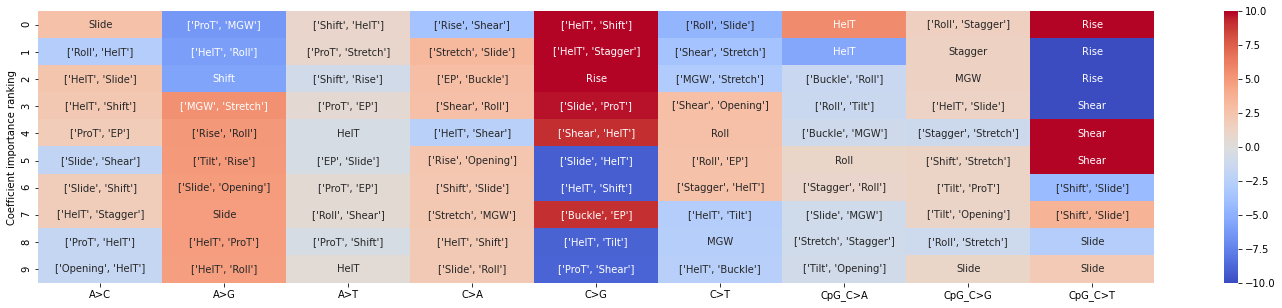

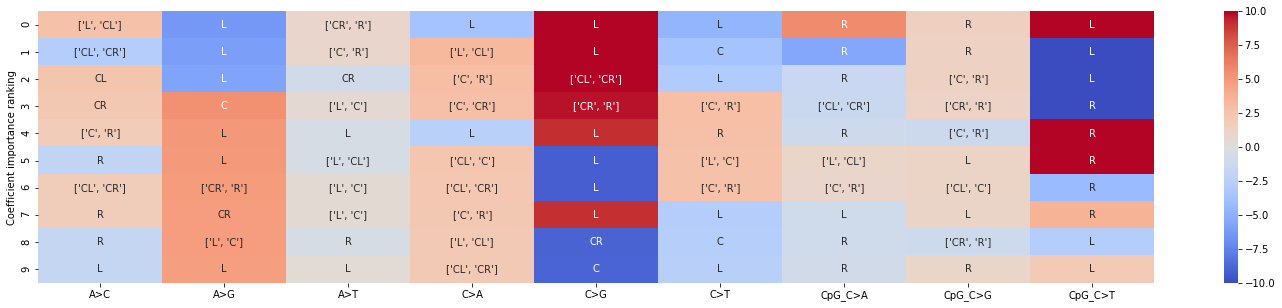

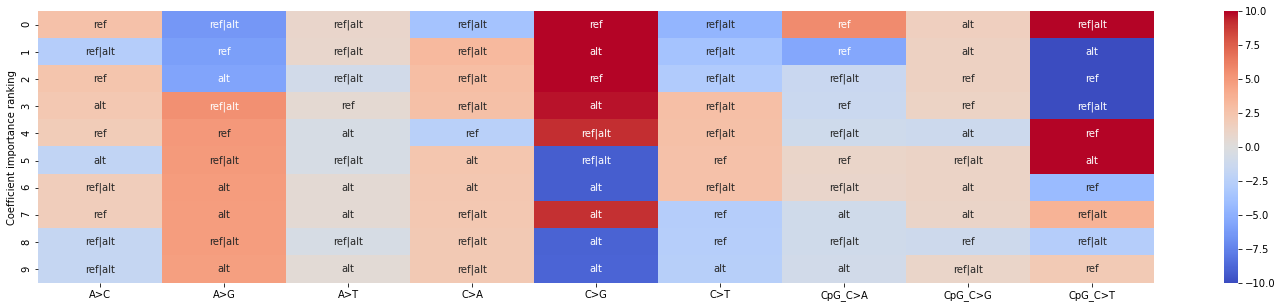

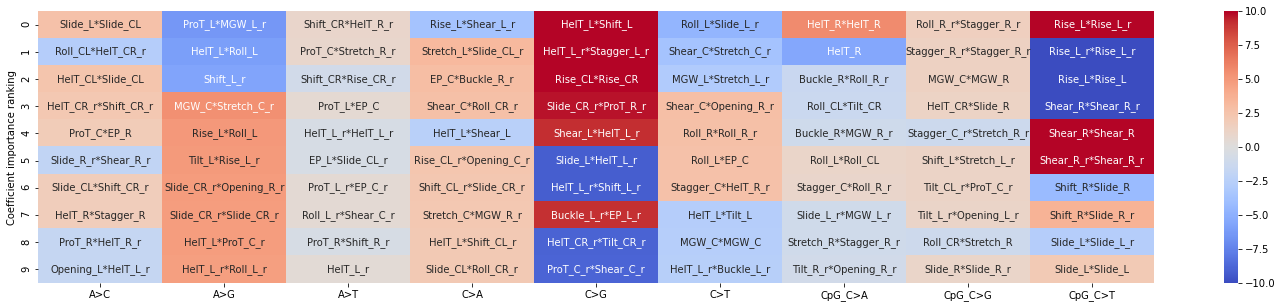

In [57]:
for sortindex in [Sorted_index_scoring_shape, Sorted_index_scoring_loc, Sorted_index_scoring_seq, 42]:
    if type(sortindex) != dict:
        annot_labels = np.array(pd.DataFrame(Sorted_index))
    else:
        annot_labels = np.array(pd.DataFrame(sortindex))

    fig_out = plt.figure(figsize=[25, 5])
    sns.heatmap(DF_final_topcoefs_reorganize[0:10], vmin=-10, vmax=10, cmap="coolwarm", annot=annot_labels[0:10], fmt='')
    plt.ylabel("Coefficient importance ranking")
    plt.xticks(np.arange(0, 9)+0.5, Index_class_name)
    plt.show()

Next, count the number of occurences of each of the features:

Interacting features will be treated as 1/(total interaction length); if an interaction is HelT x HelT it will be 1 x HelT, but if it's HelT x Roll it will be 0.5 HelT and 0.5 Roll.

In [58]:
Feature_occur_counter_weight = dict()

for select in range(9):
    print(np.sum(DF_final_topcoefs_reorganize[:, select] != 0))
    index_counter = dict()
    for i in range(np.sum(DF_final_topcoefs_reorganize[:, select] != 0)):
        obj = Sorted_index_scoring_shape[select][i]
        if type(obj) == list:
            for item in obj:
                if item not in index_counter:
                    index_counter[item] = 0
                index_counter[item] += 1/len(obj)
        else:
            if obj not in index_counter:
                index_counter[obj] = 0
            index_counter[obj] += 1
    Feature_occur_counter_weight[select] = index_counter
    
Feature_occur_df_weight = pd.DataFrame(Feature_occur_counter_weight, dtype=float).fillna(0)
display(Feature_occur_df_weight)

629
889
501
616
770
527
123
126
175


,0,1,2,3,4,5,6,7,8
Slide,33.5,49.0,21.5,33.0,54.0,29.0,4.0,11.5,12.5
Roll,67.0,86.5,58.0,66.5,76.5,60.0,11.0,13.5,17.5
HelT,24.5,40.0,16.0,19.5,33.0,15.5,5.5,4.0,9.5
Shift,71.0,84.5,55.5,71.0,79.5,60.0,13.5,10.5,21.0
ProT,55.0,70.0,37.0,42.0,61.5,36.0,6.5,6.5,8.5
EP,27.0,43.5,22.0,31.0,29.0,21.0,1.5,3.5,3.5
Shear,48.0,68.0,39.5,44.5,59.0,38.5,10.5,9.0,13.5
Stagger,50.0,64.5,37.5,49.5,59.0,43.5,10.0,13.0,12.5
Opening,26.0,45.5,28.0,29.0,30.5,25.0,3.0,3.0,3.0
MGW,38.0,67.0,32.0,45.5,55.5,33.5,6.5,11.0,10.0


In [59]:
Feature_occur_counter_weight_n = dict()

for n in [0.05, 0.1, 0.25, 0.5, 0.75]:
    Feature_occur_counter_weight_n[n] = dict()
    for select in range(9):
        index_counter = dict()
        for i in range(int(np.sum(DF_final_topcoefs_reorganize[:, select] != 0) * n)):
            obj = Sorted_index_scoring_shape[select][i]
            if type(obj) == list:
                for item in obj:
                    if item not in index_counter:
                        index_counter[item] = 0
                    index_counter[item] += 1/len(obj)
            else:
                if obj not in index_counter:
                    index_counter[obj] = 0
                index_counter[obj] += 1
        Feature_occur_counter_weight_n[n][select] = Counter(index_counter)
    Feature_occur_counter_weight_n[n] = pd.DataFrame(Feature_occur_counter_weight_n[n], dtype=int).fillna(0)

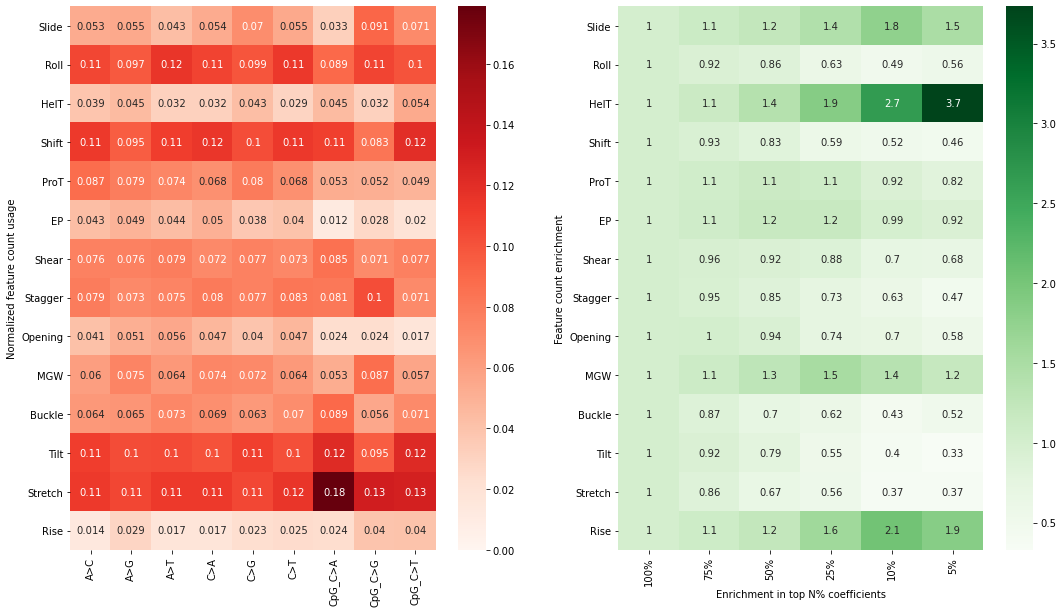

In [60]:
display_df_1 = Feature_occur_df_weight / np.sum(Feature_occur_df_weight, axis=0)
display_df_2 = np.zeros(shape=(14, 6), dtype=float)
display_df_2[:, 0] = np.ones(shape=(14, ), dtype=float)
for i in range(5):
    n = [0.75, 0.5, 0.25, 0.1, 0.05][i]
    display_df_2[:, i+1] = np.sum(Feature_occur_counter_weight_n[n], axis=1) / np.sum(Feature_occur_df_weight, axis=1)
display_df_2 = display_df_2 / np.mean(display_df_2, axis=0)

fig_out = plt.figure(figsize=[18, 10])
plt.subplot(121)
sns.heatmap(display_df_1, vmin=0, cmap="Reds", annot=True)
plt.ylabel("Normalized feature count usage")
plt.yticks(np.arange(len(display_df_1))+0.5, Feature_occur_df_weight.index, rotation='horizontal')
plt.xticks(np.arange(0, 9)+0.5, Index_class_name, rotation='vertical')
plt.subplot(122)
sns.heatmap(display_df_2, cmap="Greens", annot=True)
plt.ylabel("Feature count enrichment")
plt.xlabel("Enrichment in top N% coefficients")
plt.yticks(np.arange(len(display_df_2))+0.5, Feature_occur_counter_weight_n[0.75].index, rotation='horizontal')
plt.xticks(np.arange(0, 6)+0.5, ['100%', '75%', '50%', '25%', '10%', '5%'], rotation='vertical')
plt.show()
fig_out.savefig("manuscript/figures/pltout_fig3b_weighedcount.pdf", dpi=300)

Try doing statistical tests. 

Look at the usage of shapes, whether it is uniform, and whether this changes in smaller Ns.

In [61]:
total_ft_count = Counter([item.split('_')[0] for item in Labels_2d])
total_ft_count_df = pd.DataFrame(np.repeat(list(total_ft_count.values()), 9).reshape(-1, 9))
total_ft_count_df.index = total_ft_count.keys()

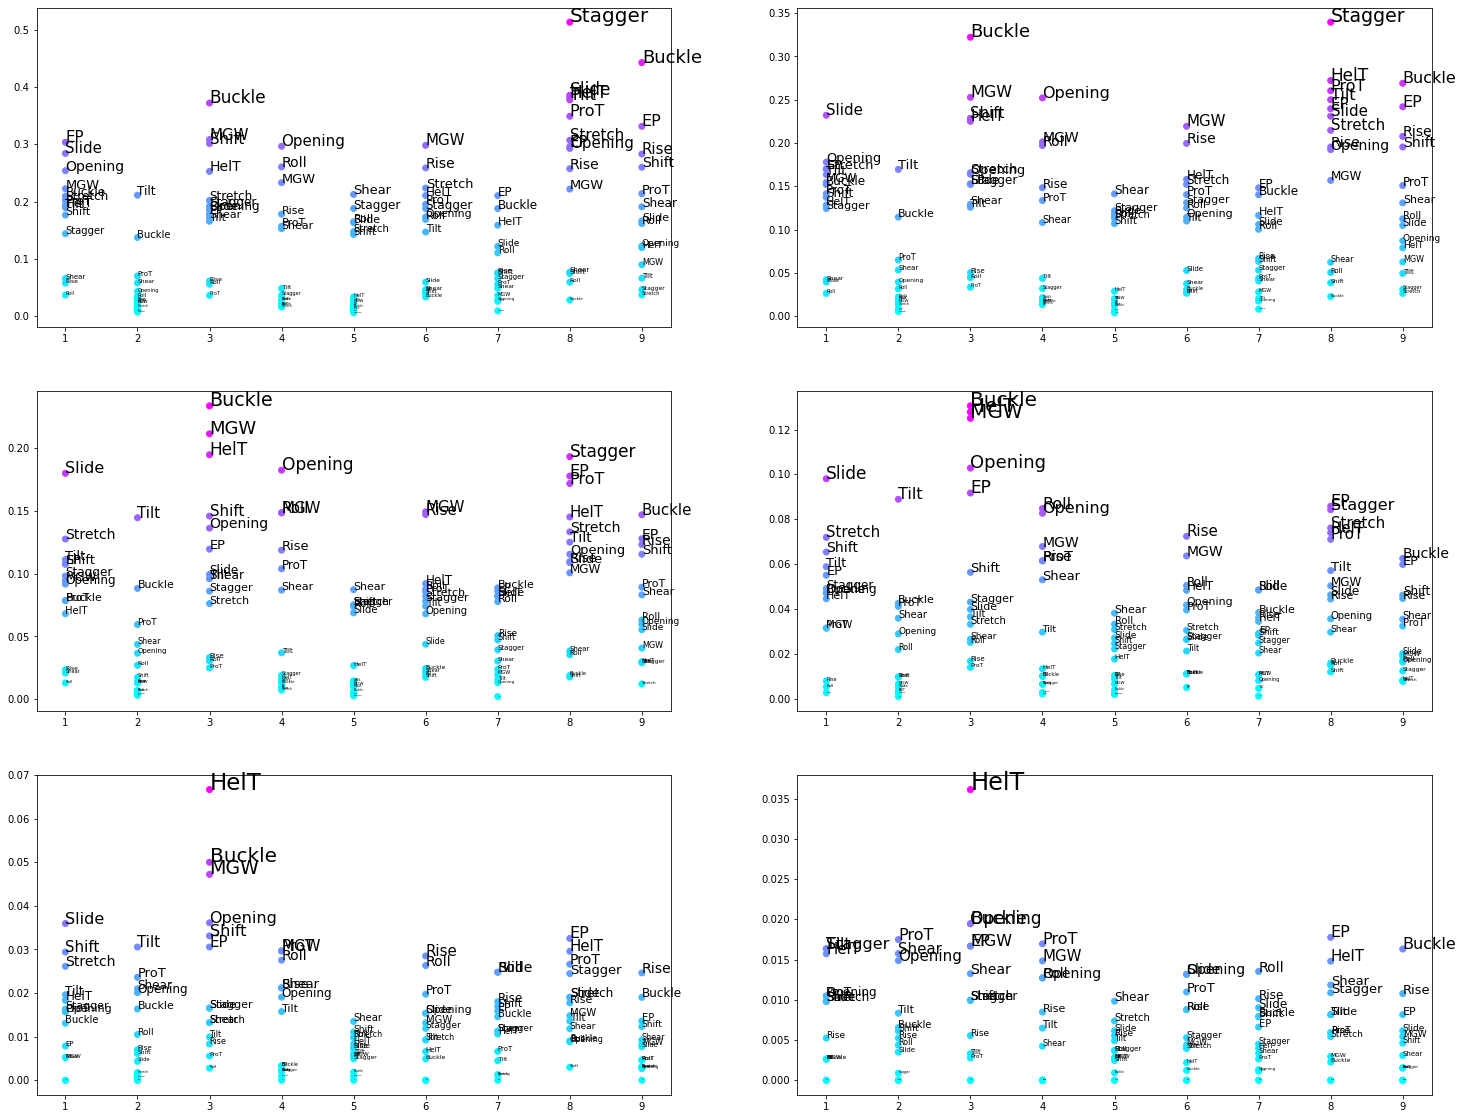

In [62]:
Total_ft_usage = dict()
plt.figure(figsize=[25, 20])

for i in range(6):
    n = [1, 0.75, 0.5, 0.25, 0.1, 0.05][i]
    if i == 0:
        input_df = Feature_occur_df_weight
    else:
        input_df = Feature_occur_counter_weight_n[n]
    Total_ft_usage[n] = input_df.divide(total_ft_count_df, axis=0)
    
    plt.subplot(int(321+i))
    xplot = np.repeat(np.arange(1, 10), len(Total_ft_usage[n]))
    yplot = np.array(Total_ft_usage[n]).reshape(-1, )
    mplot = list(Total_ft_usage[n].index) * np.shape(Total_ft_usage[n])[1]
    plt.scatter(x=xplot, y=yplot, c=yplot, cmap='cool')
    for i in range(len(xplot)):
        plt.text(x=xplot[i], y=yplot[i], s=mplot[i], fontsize=int(np.sqrt(800*yplot[i]/n)))

plt.show()

#### Fisher's exact test for enrichment

For each shape such as HelT, find out four numbers: 1) the number of HelT in top N% features, 2) the number of non-HelT in top N% features, 3) the number of HelT not in top N% features, and 4) the number of non HelT not in top N% features. Then, test to see whether this shape is enriched in the top N% features. 

Note that p-values are adjusted by BH FDR; since each test involves 14 shapes, the adjustment factor is within these shapes.

Compare across shapes. 

In [79]:
n = 0.1

DF_oddsratio, DF_pval = np.empty(shape=np.shape(Feature_occur_df_weight), dtype=float), np.empty(shape=np.shape(Feature_occur_df_weight), dtype=float)

for select in range(9):
    for i in range(len(Feature_occur_df_weight)):
        shape = list(Feature_occur_df_weight.index)[i]
        sum_shcount = float(Feature_occur_df_weight.iloc[i, select])   # Sum of 1 and 3
        #sum_shcount = total_ft_count[shape]   # Sum of 1 and 3, alternative (use all possible fts)
        sum_n_all = np.sum(Feature_occur_counter_weight_n[n].iloc[:, select])   # Sum of 1 and 2
        sum_all = np.sum(Feature_occur_df_weight.iloc[:, select])   # Sum of 1, 2, 3, 4
        #sum_all = np.sum(list(total_ft_count.values()))   # Sum of 1, 2, 3, 4, alternative (use all possible fts)
        num_1 = Feature_occur_counter_weight_n[n].iloc[i, select]   # Number 1, count of shape in top N%
        num_2 = sum_n_all - num_1   # Number 2, count of not shape in top N%
        num_3 = sum_shcount - num_1   # Number 3, count of shape not in top N%
        num_4 = sum_all - sum_n_all - num_3   # Number 4, count of not shape not in top N%
        DF_oddsratio[i, select], DF_pval[i, select] = fisher_exact([[num_1, num_2], [num_3, num_4]], alternative='greater')
# Multiple testing adjustment
_, DF_pval_adj, _, _ = multipletests(pvals=DF_pval.flatten(), alpha=0.05, method='fdr_bh', is_sorted=False)
DF_pval_adj = DF_pval_adj.reshape(np.shape(DF_pval))

DF_oddsratio, DF_pval, DF_pval_adj = pd.DataFrame(DF_oddsratio), pd.DataFrame(DF_pval), pd.DataFrame(DF_pval_adj)
DF_oddsratio.index, DF_pval.index, DF_pval_adj.index = Feature_occur_df_weight.index, Feature_occur_df_weight.index, Feature_occur_df_weight.index
temp_col = ["Class_" + str(int(select)) for select in range(9)]
DF_oddsratio.columns, DF_pval.columns, DF_pval_adj.columns = temp_col, temp_col, temp_col

with pd.ExcelWriter("./data_out/Stats_fishers_coefs_10perc.xlsx", mode='w') as export_df:
    DF_oddsratio.to_excel(export_df, sheet_name='odds_ratio')
    DF_pval.to_excel(export_df, sheet_name='p_values')
    DF_pval_adj.to_excel(export_df, sheet_name='p_values_adj')
    
display(DF_oddsratio)
display(DF_pval)
display(DF_pval_adj)

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
Slide,3.205926,2.868421,3.013889,2.794717,2.519380,1.999113,0.000000,2.311111,5.730769
Roll,0.551724,0.542005,0.665828,0.403120,0.222703,0.623512,2.833333,1.854545,0.000000
HelT,9.375385,5.229730,3.181159,4.539860,5.907692,2.411458,8.000000,0.000000,1.164062
Shift,0.531632,0.317460,0.500418,0.683916,0.716573,0.623512,0.000000,0.000000,1.103175
ProT,1.376136,0.544949,2.284496,1.250000,0.994286,1.523679,0.000000,0.000000,0.000000
EP,1.735247,1.224326,0.965286,1.372320,1.040021,1.034014,0.000000,0.000000,0.000000
Shear,0.188406,0.399638,0.751812,0.919643,1.054945,1.801630,0.000000,0.000000,3.415385
Stagger,1.059253,0.756586,0.505775,0.179025,0.656379,0.664286,1.275000,1.872727,0.000000
Opening,0.754167,1.144578,0.723404,0.700265,0.632381,0.392174,0.000000,0.000000,0.000000
MGW,1.489955,1.459406,1.853147,3.866419,1.617021,2.212346,1.909091,1.155556,0.000000


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
Slide,0.010851,0.005869,0.048318,0.028318,0.013183,0.146508,1.000000,0.284666,0.019202
Roll,0.918942,0.941636,0.839771,0.971902,0.997783,0.870819,0.225651,0.361989,1.000000
HelT,0.000003,0.000031,0.064866,0.007230,0.000027,0.170086,0.063893,1.000000,0.612674
Shift,0.930498,0.993234,0.927550,0.842137,0.829284,0.870819,1.000000,1.000000,0.578077
ProT,0.291442,0.924750,0.062935,0.404078,0.574020,0.275742,1.000000,1.000000,1.000000
EP,0.240482,0.415251,0.630646,0.368820,0.568796,0.596544,1.000000,1.000000,1.000000
Shear,0.993307,0.974277,0.761050,0.641935,0.522531,0.160761,1.000000,1.000000,0.103107
Stagger,0.530226,0.782770,0.898554,0.994747,0.848685,0.823160,0.588971,0.358012,1.000000
Opening,0.747519,0.466589,0.766445,0.780392,0.822590,0.918812,1.000000,1.000000,1.000000
MGW,0.286179,0.207970,0.177416,0.000668,0.164777,0.087926,0.470116,0.619503,1.000000


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
Slide,0.151919,0.105642,0.468317,0.297339,0.166102,0.839090,1.00000,1.0,0.219954
Roll,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.000000
HelT,0.000349,0.001321,0.498410,0.113871,0.001321,0.857234,0.49841,1.0,1.000000
Shift,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.000000
ProT,1.000000,1.000000,0.498410,1.000000,1.000000,1.000000,1.00000,1.0,1.000000
EP,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.000000
Shear,1.000000,1.000000,1.000000,1.000000,1.000000,0.857234,1.00000,1.0,0.649573
Stagger,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.000000
Opening,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.0,1.000000
MGW,1.000000,0.970527,0.859787,0.021038,0.857234,0.583091,1.00000,1.0,1.000000


Do it again with N=5%:

In [82]:
n = 0.05

DF_oddsratio, DF_pval = np.empty(shape=np.shape(Feature_occur_df_weight), dtype=float), np.empty(shape=np.shape(Feature_occur_df_weight), dtype=float)

for select in range(9):
    for i in range(len(Feature_occur_df_weight)):
        shape = list(Feature_occur_df_weight.index)[i]
        sum_shcount = float(Feature_occur_df_weight.iloc[i, select])   # Sum of 1 and 3
        #sum_shcount = total_ft_count[shape]   # Sum of 1 and 3, alternative (use all possible fts)
        sum_n_all = np.sum(Feature_occur_counter_weight_n[n].iloc[:, select])   # Sum of 1 and 2
        sum_all = np.sum(Feature_occur_df_weight.iloc[:, select])   # Sum of 1, 2, 3, 4
        #sum_all = np.sum(list(total_ft_count.values()))   # Sum of 1, 2, 3, 4, alternative (use all possible fts)
        num_1 = Feature_occur_counter_weight_n[n].iloc[i, select]   # Number 1, count of shape in top N%
        num_2 = sum_n_all - num_1   # Number 2, count of not shape in top N%
        num_3 = sum_shcount - num_1   # Number 3, count of shape not in top N%
        num_4 = sum_all - sum_n_all - num_3   # Number 4, count of not shape not in top N%
        DF_oddsratio[i, select], DF_pval[i, select] = fisher_exact([[num_1, num_2], [num_3, num_4]], alternative='greater')
# Multiple testing adjustment
_, DF_pval_adj, _, _ = multipletests(pvals=DF_pval.flatten(), alpha=0.05, method='fdr_bh', is_sorted=False)
DF_pval_adj = DF_pval_adj.reshape(np.shape(DF_pval))

DF_oddsratio, DF_pval, DF_pval_adj = pd.DataFrame(DF_oddsratio), pd.DataFrame(DF_pval), pd.DataFrame(DF_pval_adj)
DF_oddsratio.index, DF_pval.index, DF_pval_adj.index = Feature_occur_df_weight.index, Feature_occur_df_weight.index, Feature_occur_df_weight.index
temp_col = ["Class_" + str(int(select)) for select in range(9)]
DF_oddsratio.columns, DF_pval.columns, DF_pval_adj.columns = temp_col, temp_col, temp_col

with pd.ExcelWriter("./data_out/Stats_fishers_coefs_05perc.xlsx", mode='w') as export_df:
    DF_oddsratio.to_excel(export_df, sheet_name='odds_ratio')
    DF_pval.to_excel(export_df, sheet_name='p_values')
    DF_pval_adj.to_excel(export_df, sheet_name='p_values_adj')
    
display(DF_oddsratio)
display(DF_pval)
display(DF_pval_adj)

,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
Slide,3.018568,2.944920,0.991304,2.212202,1.604706,1.462963,0.000000,0.000000,2.012987
Roll,0.282228,0.929268,0.306287,0.604167,0.243333,1.016018,6.000000,0.000000,0.000000
HelT,13.227273,7.990196,4.856643,2.479303,9.155172,5.556818,18.833333,0.000000,0.000000
Shift,0.528736,0.218589,0.339775,0.846405,0.486085,0.317529,0.000000,0.000000,1.050000
ProT,1.189542,0.849654,2.556999,0.975000,0.994581,0.532571,0.000000,0.000000,0.000000
EP,0.788966,0.455215,2.181818,0.684729,1.549451,0.962000,0.000000,0.000000,0.000000
Shear,0.000000,0.270045,1.662879,0.959436,0.657895,1.074074,0.000000,0.000000,9.360000
Stagger,1.256079,0.616050,0.000000,0.000000,0.314073,0.436190,0.000000,4.954545,0.000000
Opening,1.649425,0.433442,0.000000,0.738095,0.673372,0.000000,0.000000,0.000000,0.000000
MGW,0.537356,0.929762,2.101881,3.658863,1.119231,2.140909,0.000000,2.200000,0.000000


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
Slide,0.065615,0.029027,0.651732,0.187170,0.272966,0.426232,1.000000,1.000000,0.442314
Roll,0.967327,0.633225,0.957453,0.839955,0.980717,0.586219,0.089731,1.000000,1.000000
HelT,0.000004,0.000009,0.039982,0.224097,0.000011,0.029583,0.018993,1.000000,1.000000
Shift,0.885568,0.987512,0.943153,0.694695,0.910562,0.952884,1.000000,1.000000,0.648370
ProT,0.487317,0.690642,0.103558,0.622598,0.594889,0.848392,1.000000,1.000000,1.000000
EP,0.727893,0.887838,0.267582,0.774133,0.395415,0.661669,1.000000,1.000000,1.000000
Shear,1.000000,0.972471,0.308092,0.630790,0.806596,0.575627,1.000000,1.000000,0.014821
Stagger,0.454531,0.833010,1.000000,1.000000,0.955297,0.897135,1.000000,0.116515,1.000000
Opening,0.370844,0.898970,1.000000,0.749979,0.778798,1.000000,1.000000,1.000000,1.000000
MGW,0.845828,0.635752,0.208957,0.014386,0.521388,0.201529,1.000000,0.428703,1.000000


,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8
Slide,0.751587,0.414167,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Roll,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.942181,1.000000,1.000000
HelT,0.000453,0.000453,0.503776,1.000000,0.000453,0.414167,0.341876,1.000000,1.000000
Shift,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ProT,1.000000,1.000000,0.978729,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
EP,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Shear,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.311248
Stagger,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.978729,1.000000
Opening,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
MGW,1.000000,1.000000,1.000000,0.311248,1.000000,1.000000,1.000000,1.000000,1.000000


#### Binomial test for enrichment

For each model, count the number of occurrences of each shape in 10% incremental bins.

Then, test its binomial p-value using the size of each bin and p = 1/number of features.

In [83]:
Feature_occur_counter_weight_bin = dict()

for select in np.arange(9):
    Feature_occur_counter_weight_bin[select] = dict()
    rangeint = np.sum(DF_final_topcoefs_reorganize[:, select] != 0)
    for j in np.arange(10):
        n_low = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0][j]
        n_high = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1][j]
        index_counter = dict()
        for i in np.arange(int(rangeint*n_low), int(rangeint*n_high)):
            obj = Sorted_index_scoring_shape[select][i]
            if type(obj) == list:
                for item in obj:
                    if item not in index_counter:
                        index_counter[item] = 0
                    index_counter[item] += 1/len(obj)
            else:
                if obj not in index_counter:
                    index_counter[obj] = 0
                index_counter[obj] += 1
        Feature_occur_counter_weight_bin[select][j] = Counter(index_counter)
    Feature_occur_counter_weight_bin[select] = pd.DataFrame(Feature_occur_counter_weight_bin[select], dtype=int).fillna(0)

In [93]:
def parallel_binom(array_success, pval_array, include_adj=False):
    if type(array_success) != pd.DataFrame:
        array_success = pd.DataFrame(array_success)
    n_array = np.array(np.sum(array_success, axis=0))   # creates the n array
    # Note: the following requires the binom_test function from scipy.stats
    array_out = np.empty(shape=np.shape(array_success), dtype=float)
    for _i in range(len(array_out)):
        array_out[_i] = np.array([binom_test(array_success.iloc[_i, _j], n_array[_j], pval_array[_j], alternative='greater') 
                                  for _j in range(np.shape(array_out)[1])], dtype=object)
    if include_adj:
        _, array_out_adj, _, _ = multipletests(pvals=array_out.flatten(), alpha=0.05, method='fdr_bh', is_sorted=False)
        array_out_adj = pd.DataFrame(array_out_adj.reshape(np.shape(array_out)))
        array_out_adj.index = array_success.index
    array_out = pd.DataFrame(array_out)
    array_out.index = array_success.index
    if include_adj:
        return array_out, array_out_adj
    else:
        return array_out

Do the binomial test as the following:

In [94]:
DF_binompval, DF_binompval_adj = dict(), dict()
for select in range(9):
    pval_array = np.array(list(Feature_occur_counter_weight[select].values())) / np.sum(list(Feature_occur_counter_weight[select].values()))
    DF_binompval[select], DF_binompval_adj[select] = parallel_binom(Feature_occur_counter_weight_bin[select], pval_array, include_adj=True)
    DF_binompval[select].columns = [str(int(perc)) + "%tile" for perc in np.arange(10, 110, 10)]
    DF_binompval_adj[select].columns = [str(int(perc)) + "%tile_adj" for perc in np.arange(10, 110, 10)]

Return results, save as excel table.

In [97]:
with pd.ExcelWriter("./data_out/Stats_binom_coefs_bin10perc.xlsx", mode='w') as export_df:
    for select in range(9):
        DF_binompval[select].to_excel(export_df, sheet_name="Class_"+str(select), header=True, index=True)
        DF_binompval_adj[select].to_excel(export_df, sheet_name="Class_"+str(select)+"_adj", header=True, index=True)
# Display one class for example
display( DF_binompval[0] )
display( DF_binompval_adj[0] )

,10%tile,20%tile,30%tile,40%tile,50%tile,60%tile,70%tile,80%tile,90%tile,100%tile
Roll,0.018354,0.129242,0.011168,0.935302,0.311604,0.053023,0.049023,0.568245,0.118935,0.520141
Stretch,0.001749,0.014310,0.000726,0.093659,0.311604,0.053023,0.717769,0.994583,0.263022,0.731195
Shift,0.000458,0.674198,0.098723,0.278108,0.096594,0.001432,0.530972,0.232753,0.739909,0.520141
Tilt,0.244202,0.224653,0.000005,0.728930,0.182912,0.018161,0.203439,0.385393,0.045625,0.979007
Stagger,0.433966,0.969945,0.446633,0.852800,0.812109,0.133433,0.348870,0.232753,0.118935,0.319979
ProT,0.855454,0.992947,0.230263,0.728930,0.812109,0.053023,0.020457,0.568245,0.015069,0.079495
Shear,0.118234,0.969945,0.011168,0.935302,0.654615,0.285368,0.530972,0.747688,0.045625,0.979007
Buckle,0.658851,0.814471,0.230263,0.852800,0.311604,0.758851,0.958233,0.965112,0.118935,0.895317
MGW,0.855454,0.992947,0.446633,0.999472,0.977929,0.758851,0.868503,0.125419,0.045625,0.319979
EP,0.855454,0.992947,0.446633,0.999472,0.977929,0.758851,0.958233,0.886218,0.263022,0.520141


,10%tile_adj,20%tile_adj,30%tile_adj,40%tile_adj,50%tile_adj,60%tile_adj,70%tile_adj,80%tile_adj,90%tile_adj,100%tile_adj
Roll,0.214125,0.565434,0.195436,1.000000,0.878372,0.353487,0.353487,1.000000,0.555030,1.000000
Stretch,0.040808,0.210962,0.033888,0.552848,0.878372,0.353487,1.000000,1.000000,0.856352,1.000000
Shift,0.032093,1.000000,0.552848,0.868512,0.552848,0.040089,1.000000,0.814635,1.000000,1.000000
Tilt,0.833860,0.814635,0.000712,1.000000,0.753165,0.214125,0.813756,1.000000,0.353487,1.000000
Stagger,1.000000,1.000000,1.000000,1.000000,1.000000,0.566079,0.939266,0.814635,0.555030,0.878372
ProT,1.000000,1.000000,0.814635,1.000000,1.000000,0.353487,0.220308,1.000000,0.210962,0.505877
Shear,0.555030,1.000000,0.195436,1.000000,1.000000,0.868512,1.000000,1.000000,0.353487,1.000000
Buckle,1.000000,1.000000,0.814635,1.000000,0.878372,1.000000,1.000000,1.000000,0.555030,1.000000
MGW,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.565434,0.353487,0.878372
EP,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.856352,1.000000


Do it again, but this time in 20% bin increments:

In [114]:
Feature_occur_counter_weight_bin = dict()

for select in np.arange(9):
    Feature_occur_counter_weight_bin[select] = dict()
    rangeint = np.sum(DF_final_topcoefs_reorganize[:, select] != 0)
    for j in np.arange(5):
        n_low = [0.8, 0.6, 0.4, 0.2, 0][j]
        n_high = [1, 0.8, 0.6, 0.4, 0.2][j]
        index_counter = dict()
        for i in np.arange(int(rangeint*n_low), int(rangeint*n_high)):
            obj = Sorted_index_scoring_shape[select][i]
            if type(obj) == list:
                for item in obj:
                    if item not in index_counter:
                        index_counter[item] = 0
                    index_counter[item] += 1/len(obj)
            else:
                if obj not in index_counter:
                    index_counter[obj] = 0
                index_counter[obj] += 1
        Feature_occur_counter_weight_bin[select][j] = Counter(index_counter)
    Feature_occur_counter_weight_bin[select] = pd.DataFrame(Feature_occur_counter_weight_bin[select], dtype=int).fillna(0)

In [115]:
DF_binompval, DF_binompval_adj = dict(), dict()
for select in range(9):
    pval_array = np.array(list(Feature_occur_counter_weight[select].values())) / np.sum(list(Feature_occur_counter_weight[select].values()))
    DF_binompval[select], DF_binompval_adj[select] = parallel_binom(Feature_occur_counter_weight_bin[select], pval_array, include_adj=True)
    DF_binompval[select].columns = [str(int(perc)) + "%tile" for perc in np.arange(20, 101, 20)]
    DF_binompval_adj[select].columns = [str(int(perc)) + "%tile_adj" for perc in np.arange(20, 101, 20)]

In [116]:
with pd.ExcelWriter("./data_out/Stats_binom_coefs_bin20perc.xlsx", mode='w') as export_df:
    for select in range(9):
        DF_binompval[select].to_excel(export_df, sheet_name="Class_"+str(select), header=True, index=True)
        DF_binompval_adj[select].to_excel(export_df, sheet_name="Class_"+str(select)+"_adj", header=True, index=True)
# Display one class for example
display( DF_binompval[0] )
display( DF_binompval_adj[0] )

,20%tile,40%tile,60%tile,80%tile,100%tile
MGW,8.065324e-01,0.999533,0.727303,0.773794,0.411908
EP,9.079631e-01,0.999533,0.727303,0.999040,0.773859
Shift,1.309375e-04,0.475722,0.000002,0.675894,0.927712
Tilt,7.416945e-03,0.121572,0.000124,0.566656,0.927712
Stretch,2.206608e-07,0.045312,0.000422,0.996766,0.927712
Opening,6.673057e-01,0.999912,0.367516,0.990930,0.999093
Stagger,5.093558e-01,0.964550,0.025923,0.566656,0.661624
Roll,1.309375e-04,0.797616,0.001333,0.566656,0.773859
Slide,9.665986e-01,0.994106,0.546407,0.996766,0.298154
Shear,2.295692e-01,0.701151,0.025923,0.954108,0.927712


,20%tile_adj,40%tile_adj,60%tile_adj,80%tile_adj,100%tile_adj
MGW,1.000000,1.000000,1.000000,1.0,1.000000
EP,1.000000,1.000000,1.000000,1.0,1.000000
Shift,0.001833,1.000000,0.000074,1.0,1.000000
Tilt,0.064898,0.607858,0.001833,1.0,1.000000
Stretch,0.000015,0.264317,0.004924,1.0,1.000000
Opening,1.000000,1.000000,1.000000,1.0,1.000000
Stagger,1.000000,1.000000,0.164964,1.0,1.000000
Roll,0.001833,1.000000,0.013326,1.0,1.000000
Slide,1.000000,1.000000,1.000000,1.0,1.000000
Shear,0.945285,1.000000,0.164964,1.0,1.000000


#### Location/refalt enrichments?

Next, do the same but for feature location / reference alternative allele instead. 

For easy analysis, we will use both the 4-location and 3-location system.

The ref * alt shapes will still be counted as 0.5 * ref + 0.5 * alt.

In [17]:
# Feature location and sequence info
Feature_loc_count, Feature_seq_count = dict(), dict()
for select in range(9):
    index_counter_c, index_counter_s = dict(), dict()
    for obj in ['L', 'CL', 'C', 'CR', 'R']:
        index_counter_c[obj] = 0
    for obj in ['ref', 'alt', 'ref|alt']:
        index_counter_s[obj] = 0
    for i in range(np.sum(DF_final_topcoefs_reorganize[:, select] != 0)):
        item1, item2 = Sorted_index_scoring_loc[select][i], Sorted_index_scoring_seq[select][i]
        if type(item1) == list:
            for obj1 in item1:
                index_counter_c[obj1] += 1
        else:
            index_counter_c[item1] += 1
        index_counter_s[item2] += 1
    Feature_loc_count[select], Feature_seq_count[select] = index_counter_c, index_counter_s
    
Feature_loc_count_df, Feature_seq_count_df = pd.DataFrame(Feature_loc_count, dtype=float).fillna(0), \
                                             pd.DataFrame(Feature_seq_count, dtype=float).fillna(0)
display(Feature_loc_count_df)
display(Feature_seq_count_df)

,0,1,2,3,4,5,6,7,8
L,249.0,372.0,206.0,258.0,329.0,229.0,59.0,55.0,83.0
CL,107.0,151.0,79.0,102.0,128.0,73.0,17.0,17.0,25.0
C,229.0,344.0,176.0,227.0,285.0,188.0,37.0,37.0,55.0
CR,105.0,141.0,77.0,89.0,142.0,79.0,12.0,21.0,28.0
R,244.0,334.0,199.0,241.0,271.0,206.0,41.0,48.0,61.0


,0,1,2,3,4,5,6,7,8
ref,211.0,269.0,151.0,169.0,230.0,150.0,45.0,39.0,54.0
alt,146.0,208.0,135.0,191.0,210.0,154.0,42.0,39.0,54.0
ref|alt,272.0,412.0,215.0,256.0,330.0,223.0,36.0,48.0,67.0


Draw histograms showing distribution of locations.

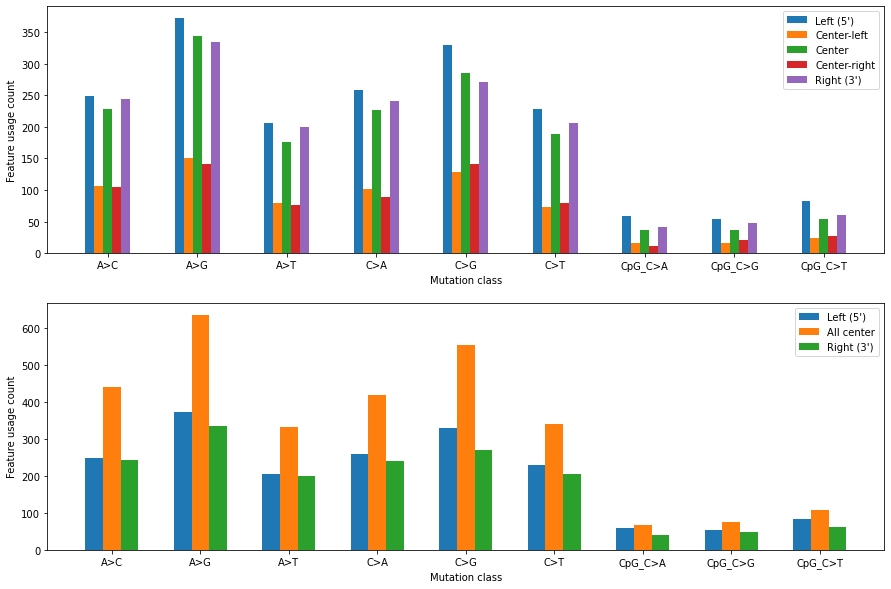

In [33]:
fig_out = plt.figure(figsize=[15, 10])
plt.subplot(211)
for i in range(5):
    plt.bar(x=np.arange(9)+(0.1*i-0.2), height=np.array(Feature_loc_count_df.iloc[i]), width=0.1)
plt.xlabel("Mutation class")
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylabel("Feature usage count")
plt.legend(["Left (5')", "Center-left", "Center", "Center-right", "Right (3')"])

plt.subplot(212)
for i in [0, 2, 4]:
    if i == 2:
        tmp_height = np.array( np.sum(Feature_loc_count_df.iloc[1:4], axis=0) )
        plt.bar(x=np.arange(9)+(0.1*i-0.2), height=tmp_height, width=0.2)
    else:
        plt.bar(x=np.arange(9)+(0.1*i-0.2), height=np.array(Feature_loc_count_df.iloc[i]), width=0.2)
plt.xlabel("Mutation class")
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylabel("Feature usage count")
plt.legend(["Left (5')", "All center", "Right (3')"])

fig_out.savefig("manuscript/figures/pltout_x_featurecount_location.pdf", dpi=300)
plt.show()

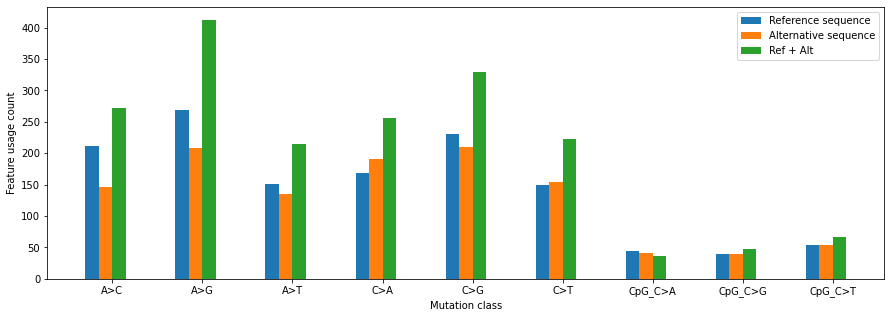

In [35]:
fig_out = fig_out = plt.figure(figsize=[15, 5])
for i in range(3):
    plt.bar(x=np.arange(9)+(0.15*i-0.225), height=np.array(Feature_seq_count_df.iloc[i]), width=0.15)
plt.xlabel("Mutation class")
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylabel("Feature usage count")
plt.legend(["Reference sequence", "Alternative sequence", "Ref + Alt"])

fig_out.savefig("manuscript/figures/pltout_x_featurecount_sequence.pdf", dpi=300)
plt.show()

Next, look at enrichments in top N% as before. 

In [100]:
Feature_loc_count_n, Feature_seq_count_n = dict(), dict()

for n in [0.05, 0.1, 0.25, 0.5, 0.75]:
    Feature_loc_count_n[n], Feature_seq_count_n[n] = dict(), dict()
    for select in range(9):
        index_counter_c, index_counter_s = dict(), dict()
        for obj in ['L', 'CL', 'C', 'CR', 'R']:
            index_counter_c[obj] = 0
        for obj in ['ref', 'alt', 'ref|alt']:
            index_counter_s[obj] = 0
        for i in range(int(np.sum(DF_final_topcoefs_reorganize[:, select] != 0) * n)):
            item1, item2 = Sorted_index_scoring_loc[select][i], Sorted_index_scoring_seq[select][i]
            if type(item1) == list:
                for obj1 in item1:
                    index_counter_c[obj1] += 1
            else:
                index_counter_c[item1] += 1
            index_counter_s[item2] += 1
        Feature_loc_count_n[n][select], Feature_seq_count_n[n][select] = index_counter_c, index_counter_s
    Feature_loc_count_n[n], Feature_seq_count_n[n] = pd.DataFrame(Feature_loc_count_n[n], dtype=float).fillna(0), \
                                                     pd.DataFrame(Feature_seq_count_n[n], dtype=float).fillna(0)
    display(Feature_loc_count_n[n])
    display(Feature_seq_count_n[n])

,0,1,2,3,4,5,6,7,8
L,11.0,27.0,9.0,11.0,23.0,11.0,1.0,1.0,3.0
CL,8.0,8.0,2.0,7.0,8.0,3.0,2.0,0.0,0.0
C,12.0,8.0,14.0,14.0,9.0,13.0,0.0,2.0,0.0
CR,6.0,11.0,3.0,4.0,7.0,5.0,1.0,1.0,0.0
R,9.0,7.0,13.0,10.0,5.0,6.0,4.0,5.0,5.0


,0,1,2,3,4,5,6,7,8
ref,10.0,8.0,4.0,6.0,11.0,9.0,4.0,2.0,3.0
alt,4.0,13.0,7.0,5.0,13.0,3.0,0.0,3.0,2.0
ref|alt,17.0,23.0,14.0,19.0,14.0,14.0,2.0,1.0,3.0


,0,1,2,3,4,5,6,7,8
L,23.0,45.0,20.0,25.0,44.0,22.0,3.0,3.0,6.0
CL,11.0,16.0,8.0,15.0,15.0,7.0,3.0,2.0,2.0
C,29.0,25.0,25.0,26.0,22.0,26.0,2.0,3.0,3.0
CR,13.0,21.0,8.0,8.0,16.0,9.0,1.0,2.0,2.0
R,19.0,26.0,21.0,19.0,13.0,15.0,7.0,8.0,9.0


,0,1,2,3,4,5,6,7,8
ref,23.0,17.0,9.0,14.0,24.0,18.0,4.0,5.0,6.0
alt,12.0,20.0,13.0,16.0,19.0,8.0,3.0,5.0,4.0
ref|alt,27.0,51.0,28.0,31.0,34.0,26.0,5.0,2.0,7.0


,0,1,2,3,4,5,6,7,8
L,59.0,104.0,52.0,69.0,107.0,49.0,14.0,15.0,18.0
CL,29.0,37.0,19.0,35.0,30.0,19.0,7.0,5.0,6.0
C,67.0,81.0,61.0,64.0,71.0,57.0,6.0,9.0,13.0
CR,27.0,44.0,12.0,18.0,31.0,24.0,3.0,4.0,6.0
R,53.0,69.0,51.0,49.0,40.0,50.0,11.0,11.0,19.0


,0,1,2,3,4,5,6,7,8
ref,52.0,50.0,32.0,39.0,52.0,37.0,8.0,9.0,12.0
alt,41.0,52.0,32.0,46.0,51.0,29.0,11.0,11.0,17.0
ref|alt,64.0,120.0,61.0,69.0,89.0,65.0,11.0,11.0,14.0


,0,1,2,3,4,5,6,7,8
L,121.0,200.0,101.0,138.0,188.0,112.0,26.0,22.0,41.0
CL,57.0,78.0,46.0,58.0,66.0,29.0,11.0,10.0,12.0
C,117.0,181.0,100.0,120.0,141.0,98.0,17.0,13.0,25.0
CR,53.0,75.0,40.0,44.0,68.0,41.0,7.0,16.0,13.0
R,119.0,147.0,97.0,107.0,105.0,107.0,25.0,31.0,32.0


,0,1,2,3,4,5,6,7,8
ref,100.0,108.0,69.0,78.0,105.0,69.0,20.0,22.0,23.0
alt,76.0,107.0,60.0,94.0,98.0,72.0,19.0,20.0,26.0
ref|alt,138.0,229.0,121.0,136.0,182.0,122.0,22.0,21.0,38.0


,0,1,2,3,4,5,6,7,8
L,184.0,290.0,153.0,200.0,258.0,175.0,45.0,36.0,62.0
CL,82.0,118.0,63.0,82.0,101.0,47.0,13.0,13.0,22.0
C,172.0,262.0,142.0,173.0,211.0,143.0,28.0,25.0,43.0
CR,81.0,101.0,57.0,64.0,109.0,62.0,7.0,19.0,21.0
R,177.0,236.0,145.0,171.0,178.0,154.0,34.0,40.0,46.0


,0,1,2,3,4,5,6,7,8
ref,150.0,188.0,107.0,124.0,163.0,112.0,32.0,28.0,40.0
alt,118.0,162.0,93.0,144.0,160.0,110.0,29.0,32.0,35.0
ref|alt,203.0,316.0,175.0,194.0,254.0,173.0,31.0,34.0,56.0


#### Interaction of shape feature usage and location/sequence

Is there a change in shapes used in different locations and on ref\alt alleles? 

In [36]:
# Feature location and sequence info
Feature_loc_shape_count = dict()
for select in range(9):
    index_counter = dict()
    for obj in ['L', 'CL', 'C', 'CR', 'R']:
        index_counter[obj] = dict()
        for shape in Shapes_name:
            index_counter[obj][shape] = 0

    for i in range(np.sum(DF_final_topcoefs_reorganize[:, select] != 0)):
        item1, item2 = Sorted_index_scoring_shape[select][i], Sorted_index_scoring_loc[select][i]
        if type(item1) == list:
            if type(item2) == list:
                for j in range(len(item1)):
                    index_counter[item2[j]][item1[j]] += 1
            else:
                for j in range(len(item1)):
                    index_counter[item2][item1[j]] += 1                
        else:
            if type(item2) == list:
                for j in range(len(item2)):
                    index_counter[item2[j]][item1] += 1                
            else:
                index_counter[item2][item1] += 1
        Feature_loc_shape_count[select] = pd.DataFrame(index_counter)

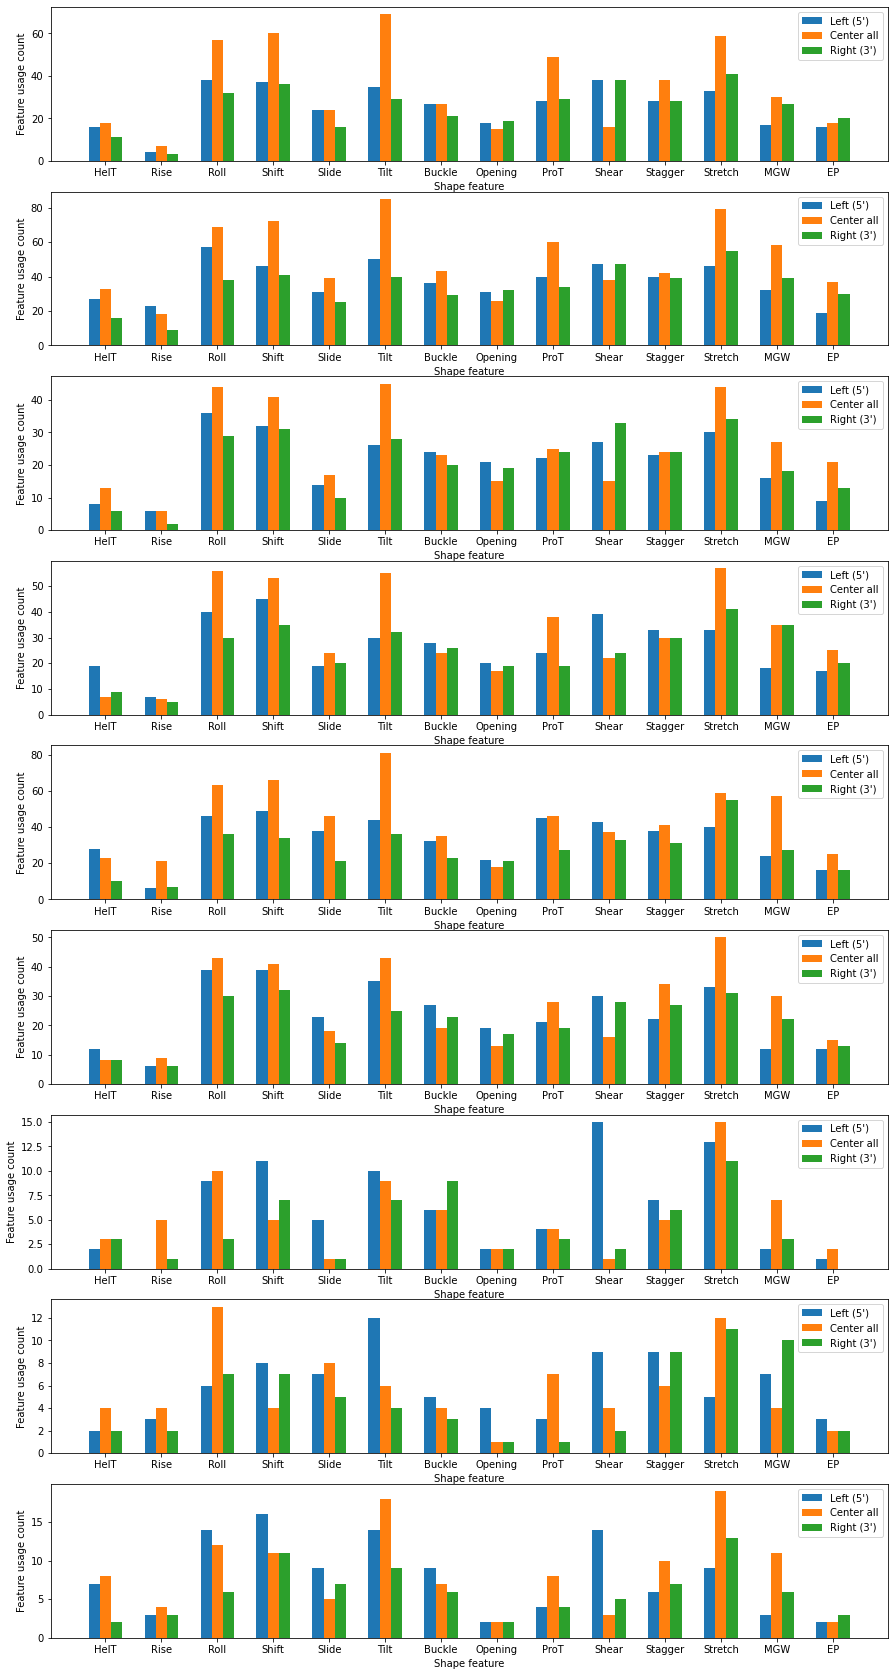

In [57]:
fig_out = fig_out = plt.figure(figsize=[15, 30])
for select in range(9):
    plt.subplot(911+select)
    for i in [0, 2, 4]:
        if i == 2:
            tmp_height = np.array( np.sum(Feature_loc_shape_count[select].iloc[:, 1:4], axis=1) )
            plt.bar(x=np.arange(14)+(0.1*i-0.2), height=tmp_height, width=0.2)
        else:
            tmp_height = np.array(Feature_loc_shape_count[select].iloc[:, i])
            plt.bar(x=np.arange(14)+(0.1*i-0.2), height=tmp_height, width=0.2)
    plt.xlabel("Shape feature")
    plt.xticks(np.arange(0, 14), list(Feature_loc_shape_count[select].index))
    plt.ylabel("Feature usage count")
    plt.legend(["Left (5')", "Center all", "Right (3')"])

fig_out.savefig("manuscript/figures/pltout_x_featurecount_shapexloc.pdf", dpi=300)
plt.show()

In [60]:
# Feature location and sequence info
Feature_seq_shape_count = dict()
for select in range(9):
    index_counter = dict()
    for obj in ['ref', 'alt', 'ref|alt']:
        index_counter[obj] = dict()
        for shape in Shapes_name:
            index_counter[obj][shape] = 0

    for i in range(np.sum(DF_final_topcoefs_reorganize[:, select] != 0)):
        item1, item2 = Sorted_index_scoring_shape[select][i], Sorted_index_scoring_seq[select][i]
        if type(item1) == list:
            if type(item2) == list:
                for j in range(len(item1)):
                    index_counter[item2[j]][item1[j]] += 1
            else:
                for j in range(len(item1)):
                    index_counter[item2][item1[j]] += 1                
        else:
            if type(item2) == list:
                for j in range(len(item2)):
                    index_counter[item2[j]][item1] += 1                
            else:
                index_counter[item2][item1] += 1
        Feature_seq_shape_count[select] = pd.DataFrame(index_counter)

In [61]:
Feature_seq_shape_count[select]

,ref,alt,ref|alt
HelT,10,1,4
Rise,4,3,2
Roll,11,5,14
Shift,12,9,15
Slide,7,8,5
Tilt,6,8,25
Buckle,10,6,6
Opening,0,3,3
ProT,7,3,5
Shear,5,9,8


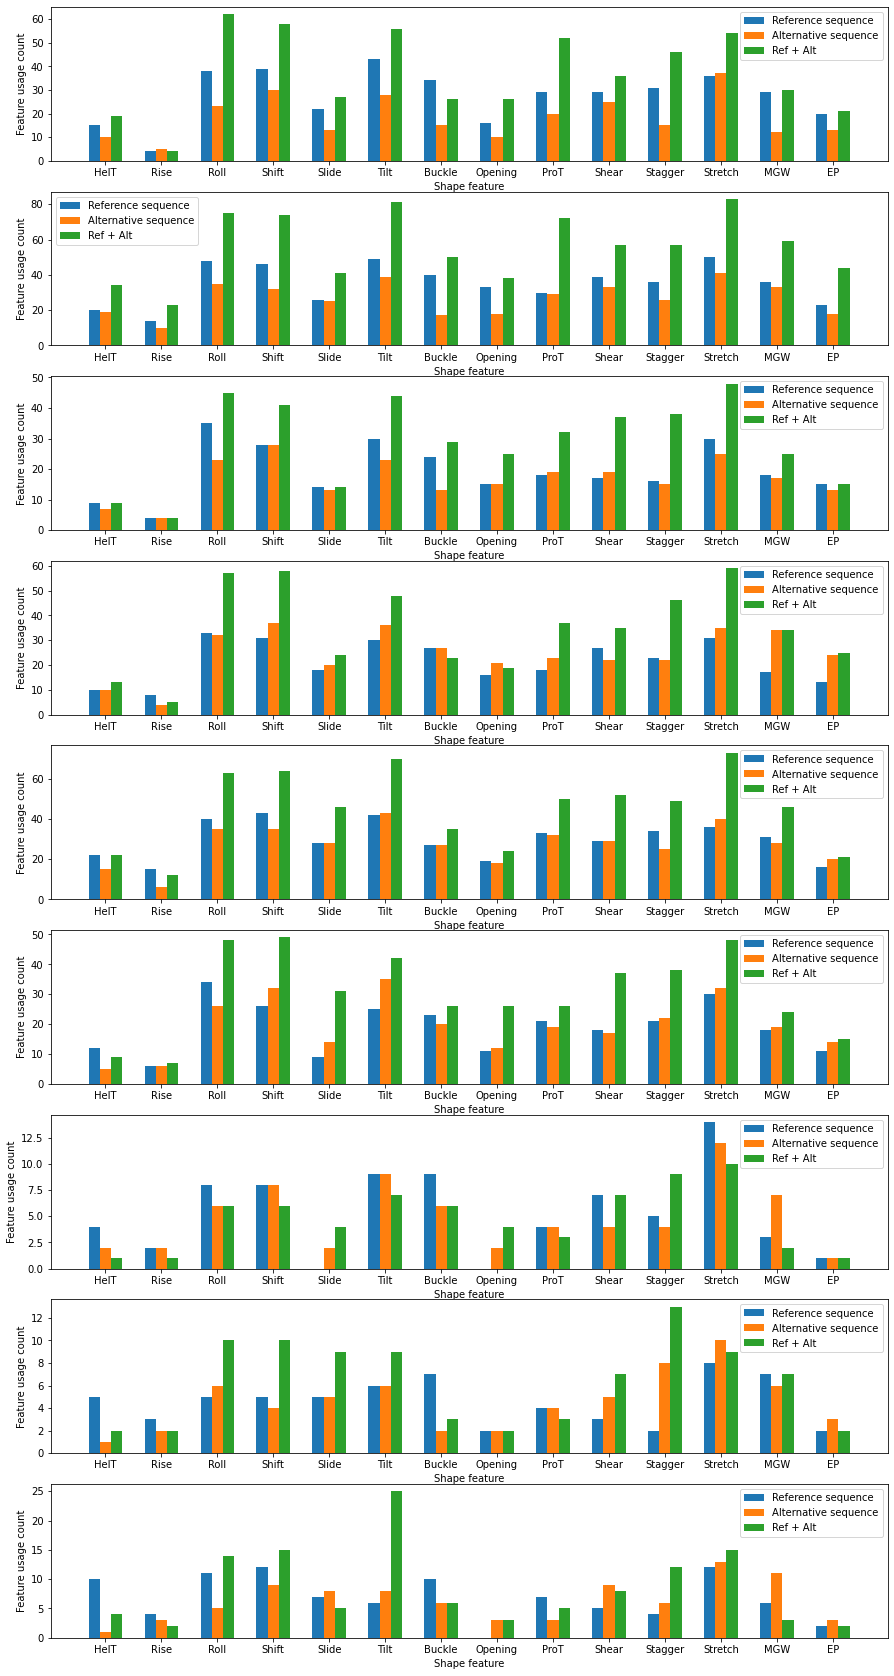

In [65]:
fig_out = fig_out = plt.figure(figsize=[15, 30])
for select in range(9):
    plt.subplot(911+select)
    for i in range(3):
        tmp_height = np.array(Feature_seq_shape_count[select].iloc[:, i])
        plt.bar(x=np.arange(14)+(0.2*i-0.2), height=tmp_height, width=0.2)
    plt.xlabel("Shape feature")
    plt.xticks(np.arange(0, 14), list(Feature_seq_shape_count[select].index))
    plt.ylabel("Feature usage count")
    plt.legend(["Reference sequence", "Alternative sequence", "Ref + Alt"])
    
fig_out.savefig("manuscript/figures/pltout_x_featurecount_shapexsequence.pdf", dpi=300)
plt.show()

Looks like there are not much enrichments in location or sequence usages. However, there seem to be some differences across shape types?

#### Shape interaction enrichment

For our final analysis: are there enrichments of certain shape-interactions?

For shape interactions, we define it as 2nd order features only; there are within-shape interactions, as well as between-shape interactions. 

By random chance, each type of interaction is expected to occur at similar rates.

In [29]:
Feature_occur_intershape = dict()

for select in np.arange(9):
    index_counter = dict()
    for i in range(np.sum(DF_final_topcoefs_reorganize[:, select] != 0)):
        obj = Sorted_index_scoring_shape[select][i]
        if type(obj) == list:
            if obj[0] == obj[1]:
                item = obj[0] + "^2"
            else:
                obj.sort()
                item = obj[0] + "_" + obj[1]
            if item not in index_counter:
                index_counter[item] = 0
            index_counter[item] += 1
    Feature_occur_intershape[select] = pd.DataFrame(index_counter.values(), index=index_counter.keys(), columns=["Count"], dtype=int).fillna(0)

In [34]:
Feature_occur_intershape

{0:                 Count
 HelT_Roll           2
 HelT_Slide          7
 HelT_Shift          3
 EP_ProT             3
 Shear_Slide         5
 ...               ...
 Rise_Stretch        1
 Rise_Shift          1
 Buckle_Stagger      1
 HelT_Shear          1
 HelT_Tilt           1
 
 [84 rows x 1 columns], 1:                 Count
 MGW_ProT           14
 HelT_Roll           7
 MGW_Stretch        13
 Rise_Roll           4
 Rise_Tilt           5
 ...               ...
 Roll_Tilt          18
 Buckle_Opening      3
 Opening_Shift       6
 Shift_Stagger      12
 Buckle_Stagger      1
 
 [90 rows x 1 columns], 2:                 Count
 HelT_Shift          3
 ProT_Stretch        9
 Rise_Shift          1
 EP_ProT             3
 EP_Slide            3
 ...               ...
 HelT_ProT           3
 Buckle_Opening      1
 Shear_Stagger       4
 Buckle_Stagger      1
 Slide_Stretch       1
 
 [76 rows x 1 columns], 3:                  Count
 Rise_Shear           4
 Slide_Stretch        4
 Buckle_EP   

In [32]:
Feature_occur_intershape_bin = dict()

for select in np.arange(9):
    Feature_occur_intershape_bin[select] = dict()
    rangeint = np.sum(DF_final_topcoefs_reorganize[:, select] != 0)
    for j in np.arange(10):
        n_low = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0][j+1]
        n_high = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0][j]
        index_counter = dict()
        for i in np.arange(int(rangeint*n_low), int(rangeint*n_high)):
            obj = Sorted_index_scoring_shape[select][i]
            if type(obj) == list:
                if obj[0] == obj[1]:
                    item = obj[0] + "^2"
                else:
                    obj.sort()
                    item = obj[0] + "_" + obj[1]
                if item not in index_counter:
                    index_counter[item] = 0
                index_counter[item] += 1
        Feature_occur_intershape_bin[select][j] = Counter(index_counter)
    Feature_occur_intershape_bin[select] = pd.DataFrame(Feature_occur_intershape_bin[select], dtype=int).fillna(0)

In [33]:
Feature_occur_intershape_bin

{0:                  0    1    2    3    4    5    6    7    8    9
 Roll_Stretch   1.0  3.0  2.0  0.0  0.0  2.0  2.0  1.0  2.0  0.0
 Shift_Tilt     2.0  2.0  2.0  3.0  3.0  2.0  4.0  1.0  0.0  0.0
 Stagger_Tilt   2.0  0.0  0.0  2.0  2.0  2.0  0.0  1.0  2.0  0.0
 ProT_Stretch   3.0  1.0  2.0  2.0  1.0  1.0  1.0  0.0  0.0  1.0
 Shear_Stagger  2.0  0.0  0.0  0.0  1.0  1.0  2.0  2.0  0.0  0.0
 ...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
 Buckle_EP      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 Slide_Stagger  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0
 HelT_Roll      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0
 HelT_Stretch   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0
 Buckle_Rise    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 
 [84 rows x 10 columns],
 1:                    0    1    2    3    4    5    6    7    8    9
 ProT_Stretch     1.0  0.0  0.0  2.0  2.0  3.0  0.0  3.0  2.0  0.0
 Stagger_Stretch  2.0  2.0  2.0  4.0  1.0  1.0  1.0  

### Decision tree analysis of shapes

Build simple decision-tree based rules that can identify top/bottom 5% of k-mers: basically, top/bottom 52 or 154 or 205 sequences in each class. 

Start from top/bottom halves first.

Note that we will use only 1st degree shapes to do this, since decision tree includes higher dimension interactions automatically. 

#### Top N% vs bottom N%

Can we compare the top and bottom? Save the decision tree outputs.

In [31]:
Trees_topbottom_out = dict()

confusion_matrix_concat_all = np.zeros(shape=(18, 0), dtype=int)
for cutoff in [50, 25, 10, 5]:
    Trees_topbottom_out[cutoff] = dict()
    confusion_matrix_concat = np.zeros(shape=(0, 2), dtype=int)
    for select in range(9):
        sort_temp_eff, sort_temp_eff_t = np.argsort(Eff[Index_class==select]), np.argsort(Eff_test[Index_class==select])
        # Training labels
        temp_label = np.zeros(shape=(len(Eff[Index_class==select]), ), dtype=int)
        temp_label[Eff[Index_class==select] <= np.percentile(Eff[Index_class==select], cutoff)] = -1
        temp_label[Eff[Index_class==select] > np.percentile(Eff[Index_class==select], 100-cutoff)] = 1
        # Testing labels
        temp_label_t = np.zeros(shape=(len(Eff_test[Index_class==select]), ), dtype=int)
        temp_label_t[Eff_test[Index_class==select] <= np.percentile(Eff_test[Index_class==select], cutoff)] = -1
        temp_label_t[Eff_test[Index_class==select] > np.percentile(Eff_test[Index_class==select], 100-cutoff)] = 1
        # Cut off middle values
        temp_pred = DF_val_join.iloc[Index_class==select].iloc[temp_label != 0]
        temp_pred_t = DF_val_join.iloc[Index_class==select].iloc[temp_label_t != 0]
        temp_label = temp_label[temp_label != 0]
        temp_label_t = temp_label_t[temp_label_t != 0]
        # Grid search
        model = DecisionTreeClassifier(splitter='best', class_weight='balanced', random_state=42)
        parameters = {'criterion': ['gini'], 'max_depth': [2], 
                     'min_samples_split': [10, 25, 50, 0.1], 'min_samples_leaf': [1, 10, 0.1], 
                     'max_features': ['auto', 'log2', 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, None]}
        obj_gridsearch = GridSearchCV(estimator=model, param_grid=parameters, 
                                      scoring='balanced_accuracy', 
                                      cv=8, return_train_score=True, n_jobs=6)
        obj_gridsearch.fit(temp_pred, temp_label)
        Trees_topbottom_out[cutoff][select] = obj_gridsearch
        
        tmp_out = obj_gridsearch.predict(temp_pred_t)
        df_test = confusion_matrix(temp_label_t, tmp_out, normalize=None, labels=[-1,1])
        confusion_matrix_concat = np.concatenate((confusion_matrix_concat, df_test), axis=0)
    confusion_matrix_concat_all = np.concatenate((confusion_matrix_concat_all, confusion_matrix_concat), axis=1)
confusion_matrix_concat_all = pd.DataFrame(confusion_matrix_concat_all)
confusion_matrix_concat_all.columns = np.array([["pred_low_"+str(N), "pred_high_"+str(N)] for N in [50, 25, 10, 5]]).flatten()
confusion_matrix_concat_all.index = np.array([[select+"_low", select+"_high"] for select in Index_class_name]).flatten()

display(confusion_matrix_concat_all)
dump(Trees_topbottom_out, "data_out/tree_topbottomN_object.joblib")
confusion_matrix_concat_all.to_csv("data_out/tree_topbottomN_results.csv")

,pred_low_50,pred_high_50,pred_low_25,pred_high_25,pred_low_10,pred_high_10,pred_low_5,pred_high_5
A>C_low,1643,405,795,229,333,77,176,29
A>C_high,948,1100,289,735,110,300,64,141
A>G_low,1414,634,930,94,393,17,202,3
A>G_high,414,1634,110,914,19,391,2,203
A>T_low,1554,494,909,115,375,35,195,10
A>T_high,346,1702,67,957,14,396,14,191
C>A_low,1089,447,687,81,273,35,143,11
C>A_high,367,1169,159,609,21,287,9,145
C>G_low,1215,321,653,115,285,23,138,16
C>G_high,643,893,197,571,49,259,9,145


Plot out the tree parameters for N in {5, 10}:

In [6]:
Trees_topbottom_out = load("data_out/tree_topbottomN_object.joblib")

C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zianl\Anaconda3\envs\python3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [28]:
dict_tree_expl = dict()
dict_tree_expl[5], dict_tree_expl[10] = dict(), dict()

for select in range(9):
    dict_tree_expl[10][select] = eli5.show_weights(
        Trees_topbottom_out[10][select].best_estimator_, 
        feature_names=list(DF_val_join.columns), target_names=['low', 'high']
    )

for select in range(9):
    dict_tree_expl[5][select] = eli5.show_weights(
        Trees_topbottom_out[5][select].best_estimator_, 
        feature_names=list(DF_val_join.columns), target_names=['low', 'high']
    )

dump(dict_tree_expl, "data_out/tree_interpret_eli5.joblib")

['data_out/tree_interpret_eli5.joblib']

Load results and visualize one

In [6]:
dict_tree_expl = load("data_out/tree_interpret_eli5.joblib")

for select in range(9):
    display(dict_tree_expl[5][select])

Weight,Feature
0.4883,Shear_L_r
0.2972,HelT_R
0.2145,Stagger_L
0,Stagger_C
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L


Weight,Feature
0.8639,Tilt_CR
0.0771,Shear_C_r
0.0590,Opening_L_r
0,Buckle_R
0,Opening_L
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R


Weight,Feature
0.8674,Roll_CR_r
0.0675,Buckle_R
0.0651,Roll_R
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L
0,Shear_C


Weight,Feature
0.8318,Shift_R
0.0842,Roll_L
0.0841,Buckle_C_r
0,Opening_L
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L


Weight,Feature
0.6934,EP_L_r
0.2526,ProT_L
0.0540,Stagger_L
0,Stagger_C
0,Opening_L
0,Opening_C
0,Opening_R
0,ProT_C
0,ProT_R
0,Shear_L


Weight,Feature
0.6757,Opening_C
0.2279,Shift_CL_r
0.0964,HelT_CL_r
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L
0,Shear_C
0,MGW_L


Weight,Feature
0.6511,Rise_CL
0.3452,ProT_C
0.0037,Roll_L
0,Stagger_C
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_R
0,Shear_L
0,Shear_C


Weight,Feature
0.7997,ProT_C
0.2003,HelT_R_r
0,Stretch_C
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_R
0,Shear_L
0,Shear_C
0,Shear_R


Weight,Feature
0.8909,Slide_L
0.1091,Roll_R
0,Opening_C
0,Opening_R
0,ProT_L
0,ProT_C
0,ProT_R
0,Shear_L
0,Shear_C
0,Stretch_C


Show the AUROC curves:

In [60]:
dict_fpr, dict_tpr, dict_fpr_t, dict_tpr_t = dict(), dict(), dict(), dict()
for cutoff in [50, 25, 10, 5]:
    dict_fpr[cutoff], dict_tpr[cutoff], dict_fpr_t[cutoff], dict_tpr_t[cutoff] = dict(), dict(), dict(), dict()
    for select in range(9):
        # Training labels
        temp_label = np.zeros(shape=(len(Eff[Index_class==select]), ), dtype=int)
        temp_label[Eff[Index_class==select] <= np.percentile(Eff[Index_class==select], cutoff)] = -1
        temp_label[Eff[Index_class==select] > np.percentile(Eff[Index_class==select], 100-cutoff)] = 1
        # Testing labels
        temp_label_t = np.zeros(shape=(len(Eff_test[Index_class==select]), ), dtype=int)
        temp_label_t[Eff_test[Index_class==select] <= np.percentile(Eff_test[Index_class==select], cutoff)] = -1
        temp_label_t[Eff_test[Index_class==select] > np.percentile(Eff_test[Index_class==select], 100-cutoff)] = 1
        # Cut off middle values
        temp_pred = DF_val_join.iloc[Index_class==select].iloc[temp_label != 0]
        temp_pred_t = DF_val_join.iloc[Index_class==select].iloc[temp_label_t != 0]
        temp_label = temp_label[temp_label != 0]
        temp_label_t = temp_label_t[temp_label_t != 0]

        # Predict probabilities and fpr/tpr values
        proba_train, proba_test = Trees_topbottom_out[cutoff][select].best_estimator_.predict_proba(temp_pred)[:, 1], \
                                  Trees_topbottom_out[cutoff][select].best_estimator_.predict_proba(temp_pred_t)[:, 1]
        dict_fpr[cutoff][select], dict_tpr[cutoff][select], _ = roc_curve(temp_label, proba_train)
        dict_fpr_t[cutoff][select], dict_tpr_t[cutoff][select], _ = roc_curve(temp_label_t, proba_test)

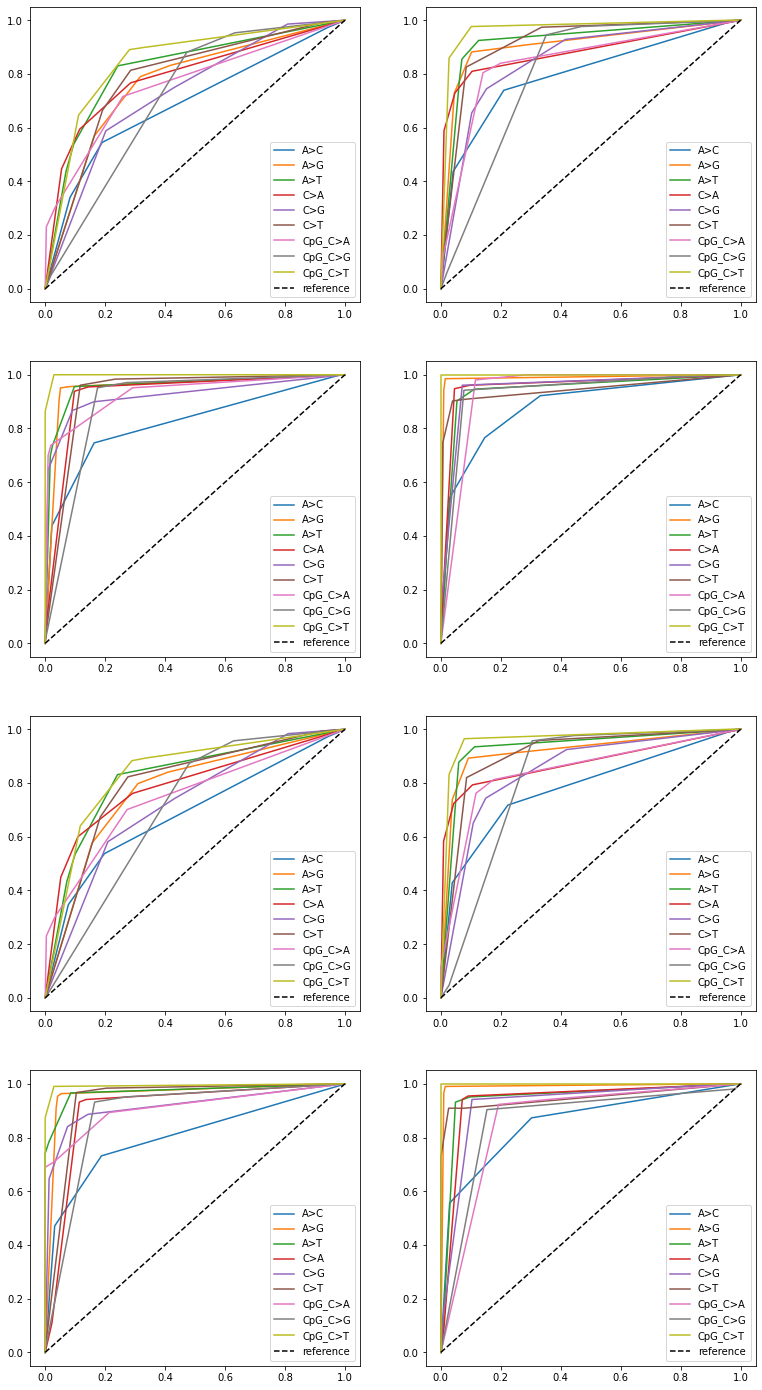

In [76]:
# Figures
fig_out = plt.figure(figsize=[13, 25])
for i in range(4):
    cutoff = [50, 25, 10, 5][i]
    plt.subplot(int(421+i))
    for select in range(9):
        plt.plot(dict_fpr[cutoff][select], dict_tpr[cutoff][select])
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.legend(Index_class_name+["reference"])
for i in range(4):
    cutoff = [50, 25, 10, 5][i]
    plt.subplot(int(425+i))
    for select in range(9):
        plt.plot(dict_fpr_t[cutoff][select], dict_tpr_t[cutoff][select])
    plt.plot([0, 1], [0, 1], color='k', linestyle='--')
    plt.legend(Index_class_name+["reference"])
plt.show()
fig_out.savefig("manuscript/figures/pltout_fig4a_roc.pdf", dpi=300)

Show the AUROC values and line plot:

,50%_train,50%_test,25%_train,25%_test,10%_train,10%_test,5%_train,5%_test
A>C,0.689364,0.685379,0.797568,0.783267,0.820708,0.804209,0.883093,0.856883
A>G,0.765757,0.775539,0.908235,0.917933,0.952674,0.961907,0.987662,0.990089
A>T,0.821756,0.820250,0.921587,0.932665,0.955758,0.972293,0.943093,0.947519
C>A,0.790925,0.789683,0.881856,0.874124,0.928076,0.908316,0.957033,0.938860
C>G,0.730229,0.722989,0.852056,0.847818,0.923137,0.917387,0.949717,0.923322
C>T,0.785251,0.795254,0.917503,0.908447,0.930785,0.937964,0.944341,0.948642
CpG_C>A,0.759179,0.746851,0.846786,0.844337,0.931520,0.912527,0.939534,0.866494
CpG_C>G,0.717014,0.708391,0.804871,0.823997,0.894853,0.888774,0.935466,0.867788
CpG_C>T,0.846268,0.838577,0.968246,0.963356,0.998021,0.993308,1.000000,1.000000


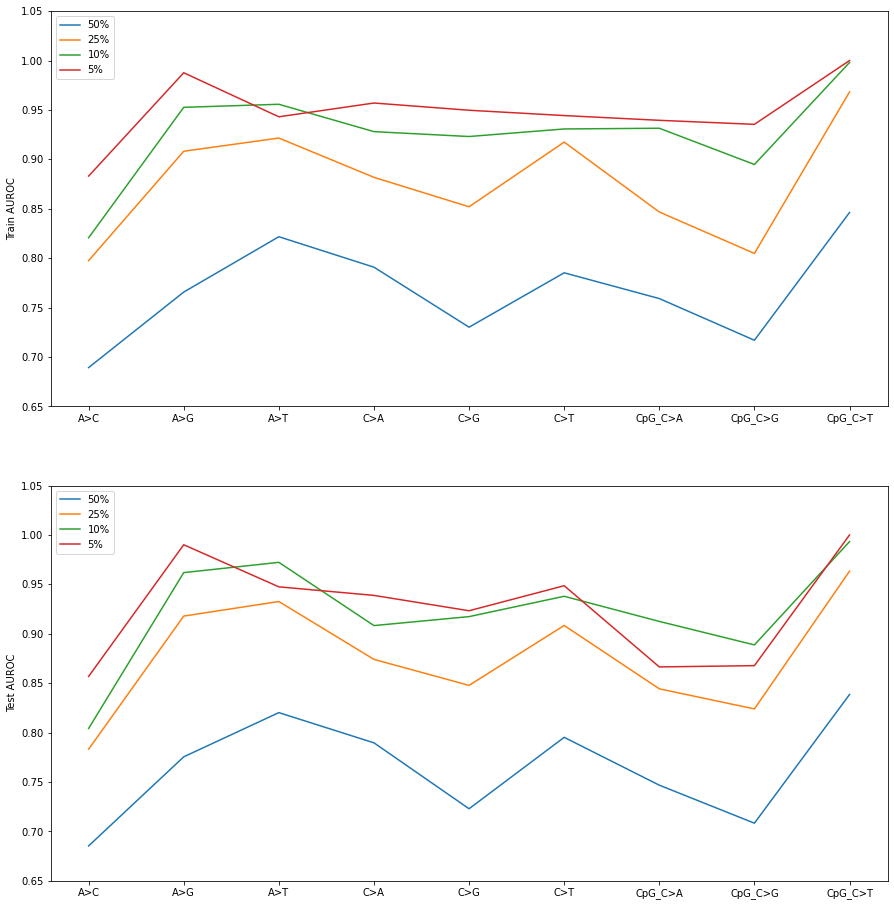

In [75]:
array_auroc = np.zeros(shape=(9, 8), dtype=float)
for i in range(4):
    cutoff = [50, 25, 10, 5][i]
    for select in range(9):
        array_auroc[select, [2*i, 2*i+1]] = auc(dict_fpr[cutoff][select], dict_tpr[cutoff][select]), \
                                            auc(dict_fpr_t[cutoff][select], dict_tpr_t[cutoff][select])
DF_auroc = pd.DataFrame(array_auroc)
DF_auroc.index = Index_class_name
DF_auroc.columns = ['50%_train', '50%_test', '25%_train', '25%_test', '10%_train', '10%_test', '5%_train', '5%_test']

display(DF_auroc)
DF_auroc.to_csv("data_out/tree_topbottomN_auroc.csv")

fig_out = plt.figure(figsize=[15, 16])
plt.subplot(211)
for i in [0, 2, 4, 6]:
    plt.plot(DF_auroc.iloc[:, i])
plt.legend(['50%', '25%', '10%', '5%'])
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylabel("Train AUROC")
plt.ylim(0.65, 1.05)
plt.subplot(212)
for i in [1, 3, 5, 7]:
    plt.plot(DF_auroc.iloc[:, i])
plt.legend(['50%', '25%', '10%', '5%'])
plt.xticks(np.arange(0, 9), Index_class_name)
plt.ylabel("Test AUROC")
plt.ylim(0.65, 1.05)
plt.show()
fig_out.savefig("manuscript/figures/pltout_fig4b_auroc.pdf", dpi=300)

Count the most important shape features:

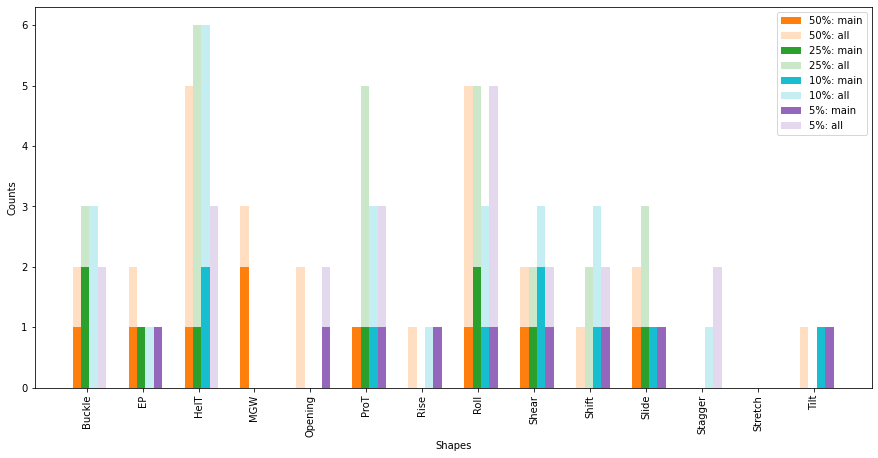

In [155]:
index_shapes = np.array([item.split("_")[0] for item in DF_val_join.columns])

Index_imp_count, Index_imp_count_top = dict(), dict()
for n in [50, 25, 10, 5]:
    Index_important, Index_top = [], []
    for select in range(9):
        temp_index, temp_index_max = index_shapes[Trees_topbottom_out[n][select].best_estimator_.feature_importances_ != 0], \
                                     index_shapes[np.argmax(Trees_topbottom_out[n][select].best_estimator_.feature_importances_)]
        for item in temp_index:
            Index_important.append(item)
        Index_top.append(temp_index_max)
    Index_imp_count[n], Index_imp_count_top[n] = Counter(Index_important), Counter(Index_top)
    Index_imp_count[n] = {key: Index_imp_count[n][key] for key in sorted(set(index_shapes))}
    Index_imp_count_top[n] = {key: Index_imp_count_top[n][key] for key in sorted(set(index_shapes))}
        
fig_out = plt.figure(figsize=[15, 7])
colormap = ['tab:orange', 'tab:green', 'tab:cyan', 'tab:purple']
for i in range(4):
    n = [50, 25, 10, 5][i]
    plt.bar(x=np.arange(1, 15)+(0.15*i-0.375), height=Index_imp_count_top[n].values(), width=0.15, alpha=1, color=colormap[i])
    plt.bar(x=np.arange(1, 15)+(0.15*i-0.375), height=Index_imp_count[n].values(), width=0.15, alpha=0.25, color=colormap[i])
plt.xticks(np.arange(1, 15)-0.2, sorted(set(index_shapes)), rotation=90)
plt.legend(['50%: main', '50%: all', '25%: main', '25%: all', '10%: main', '10%: all', '5%: main', '5%: all'])
plt.ylabel("Counts")
plt.xlabel("Shapes")
plt.show()
fig_out.savefig("manuscript/figures/pltout_fig4c_treecompar.pdf", dpi=300)

Count the weighed count (use coefficients * counts):

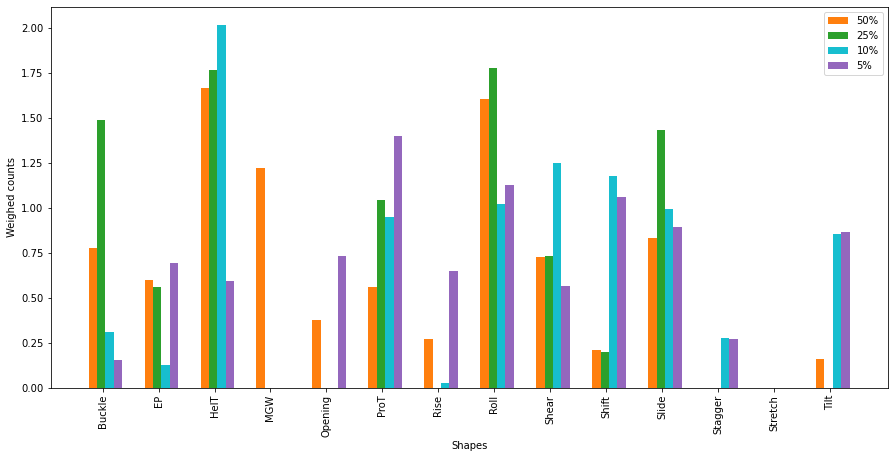

In [156]:
index_shapes = np.array([item.split("_")[0] for item in DF_val_join.columns])

Imp_count_weighed, Imp_count_weighed_byshape = dict(), dict()
for n in [50, 25, 10, 5]:
    Imp_count_weighed[n], Imp_count_weighed_byshape[n] = np.zeros(shape=(len(index_shapes), ), dtype=float), np.zeros(shape=(14, ), dtype=float)
    for select in range(9):
        Imp_count_weighed[n] = Imp_count_weighed[n] + np.array(Trees_topbottom_out[n][select].best_estimator_.feature_importances_)
    for i in range(14):
        item = sorted(set(index_shapes))[i]
        Imp_count_weighed_byshape[n][i] = np.sum(Imp_count_weighed[n][index_shapes == item])
    
fig_out = plt.figure(figsize=[15, 7])
colormap = ['tab:orange', 'tab:green', 'tab:cyan', 'tab:purple']
for i in range(4):
    n = [50, 25, 10, 5][i]
    plt.bar(x=np.arange(1, 15)+(0.15*i-0.375), height=Imp_count_weighed_byshape[n], width=0.15, alpha=1, color=colormap[i])
plt.xticks(np.arange(1, 15)-0.2, sorted(set(index_shapes)), rotation=90)
plt.legend(['50%', '25%', '10%', '5%'])
plt.ylabel("Weighed counts")
plt.xlabel("Shapes")
plt.show()
fig_out.savefig("manuscript/figures/pltout_fig4d_treecompar_weighed.pdf", dpi=300)

## Correlation with variant pathogenicity

Are the high-impact shapes we discovered related to variant pathogenicity? Use the regBase data to find out.

In [9]:
DF_regbase_reg = pd.read_csv("data_input/regBase/kmerseq_REG_dataset_XY.tsv.txt", sep='\t')
DF_regbase_regc = pd.read_csv("data_input/regBase/kmerseq_REG_C_dataset_XY.tsv.txt", sep='\t')
DF_regbase_pat = pd.read_csv("data_input/regBase/kmerseq_PAT_dataset_XY.tsv.txt", sep='\t')
display(DF_regbase_reg)

C:\Users\zianl\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,15,16,20,21,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Ref_7mer,Alt_7mer,#Chromosome,Position,Ref,Alt,CADD,DANN,FATHMM-MKL,FunSeq2,...,Eigen_PC,GenoCanyon,FIRE,ReMM,LINSIGHT,fitCons,FATHMM-XF,CScape,CDTS,label
0,ATGTGCT,ATGCGCT,1,1265154,T,C,-0.156244,0.270643,0.57340,6.479094e-01,...,3.204849136,1.000000,0.796,0.426,0.14873,0.047798,0.178721,0.49501,7.85762,1
1,GTGTGGC,GTGCGGC,1,1265460,T,C,-0.171605,0.147144,0.04468,6.479094e-01,...,3.056649209,1.000000,0.745,0.243,0.0976711,0.079086,0.159995,0.198431,13.0805,1
2,CCCCGGT,CCCGGGT,1,2496649,C,G,-0.803454,0.211137,0.05223,9.973036e-01,...,0.241513319,0.999981,0.654,0.115,0.0595966,0.060736,0.026404,0.439671,-3.71014,1
3,GGCGAGG,GGCAAGG,1,2499254,G,A,0.476192,0.833879,0.10120,3.550000e-31,...,1.593587439,0.638914,0.641,0.399,0.0527663,0.081118,0.030133,0.48724,.,1
4,TCAATTG,TCAGTTG,1,2499810,A,G,-0.054910,0.580000,0.03492,1.852143e-01,...,1.907911062,0.718338,0.741,0.116,0.0700712,0.184705,0.434824,0.322778,.,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61165,GCTAGGA,GCTGGGA,X,122977381,A,G,-0.354808,0.127118,0.03601,4.530000e-33,...,.,0.004900,0.218,0.197,0.0436289,.,.,.,.,0
61166,GTAGTCC,GTAATCC,X,122980789,G,A,-0.090094,0.816832,0.15777,6.024337e-01,...,.,0.999996,0.329,0.313,0.0476157,.,.,.,0.031073,0
61167,AGAAAAA,AGAGAAA,X,122982454,A,G,0.063194,0.363892,0.05738,4.530000e-33,...,.,0.001343,0.248,0.304,0.0414318,.,.,.,-4.52567,0
61168,ATCGTTT,ATCATTT,X,123004256,G,A,-0.044384,0.590059,0.02841,4.172194e-01,...,.,0.996002,0.509,0.211,0.0476178,.,.,.,-5.22364,0


First, do some validation by plotting CADD, FunSeq2, and ReMM scores against variant annotations.

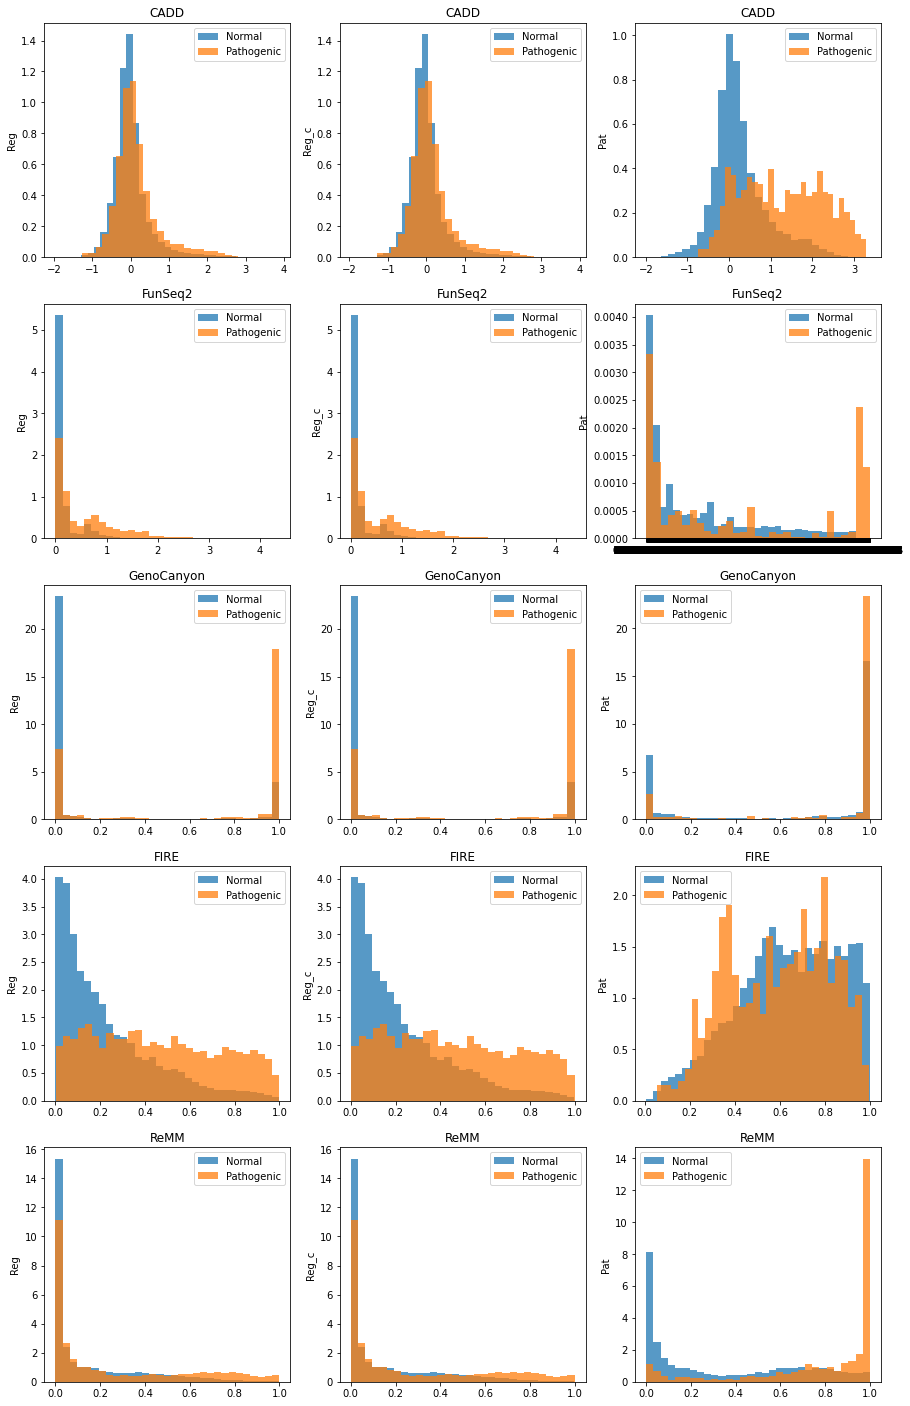

In [133]:
def local_scoresubplot(subplot_val, database, score, ylabel):
    if type(subplot_val) == int:
        plt.subplot(subplot_val)
    else:
        plt.subplot(subplot_val[0], subplot_val[1], subplot_val[2])
    plt.hist(database[score][database['label'] == 0], alpha=0.75, bins=31, density=True)
    plt.hist(database[score][database['label'] == 1], alpha=0.75, bins=31, density=True)
    plt.legend(['Normal', 'Pathogenic'])
    plt.ylabel(ylabel)
    plt.title(str(score))


fig_out = plt.figure(figsize=[15, 25])
for i in range(15):
    temp_df = [DF_regbase_reg, DF_regbase_regc, DF_regbase_pat][i%3]
    scoring = ['CADD', 'FunSeq2', 'GenoCanyon', 'FIRE', 'ReMM'][int(i//3)]
    ylabel = ['Reg', 'Reg_c', 'Pat'][i%3]
    local_scoresubplot([5,3,1+i], temp_df, scoring, ylabel)
plt.show()
fig_out.savefig("manuscript/figures/pltout_misc_patscores.pdf", dpi=300)

As we can see the scores didn't really work in reg and reg_c datasets, but worked alright in the pat dataset.

Next, try DNA shape features:

In [40]:
temp_col = list(DF_strucval.columns) + [str(item) + '_r' for item in list(DF_strucval.columns)]

DF_shape_reg = pd.concat([
    DF_strucval.loc[DF_regbase_reg['Ref_7mer']].reset_index(drop=True), 
    DF_strucval.loc[DF_regbase_reg['Alt_7mer']].reset_index(drop=True)], 
    axis=1, ignore_index=True
)
DF_shape_reg.columns = temp_col
DF_shape_reg['label'] = DF_regbase_reg['label']

DF_shape_regc = pd.concat([
    DF_strucval.loc[DF_regbase_regc['Ref_7mer']].reset_index(drop=True), 
    DF_strucval.loc[DF_regbase_regc['Alt_7mer']].reset_index(drop=True)], 
    axis=1, ignore_index=True
)
DF_shape_regc.columns = temp_col
DF_shape_regc['label'] = DF_regbase_regc['label']

DF_shape_pat = pd.concat([
    DF_strucval.loc[DF_regbase_pat['Ref_7mer']].reset_index(drop=True), 
    DF_strucval.loc[DF_regbase_pat['Alt_7mer']].reset_index(drop=True)], 
    axis=1, ignore_index=True
)
DF_shape_pat.columns = temp_col
DF_shape_pat['label'] = DF_regbase_pat['label']

display(DF_shape_reg)

,HelT_L,HelT_CL,HelT_CR,HelT_R,Rise_L,Rise_CL,Rise_CR,Rise_R,Roll_L,Roll_CL,...,Stretch_L_r,Stretch_C_r,Stretch_R_r,MGW_L_r,MGW_C_r,MGW_R_r,EP_L_r,EP_C_r,EP_R_r,label
0,35.86,33.54,34.52,36.67,3.59,3.33,3.24,3.43,6.57,-2.04,...,-0.04,-0.03,-0.03,5.44,5.62,5.08,-4.96,-4.75,-5.21,1
1,35.12,33.21,34.50,33.11,3.31,3.29,3.23,3.30,5.01,-1.60,...,-0.04,-0.03,-0.04,5.91,5.57,5.40,-4.96,-4.82,-5.10,1
2,33.81,31.66,33.67,32.28,3.38,3.35,3.37,3.40,-1.99,-4.75,...,-0.04,-0.04,-0.04,5.32,5.32,4.68,-5.12,-5.12,-5.59,1
3,34.36,34.05,33.95,31.85,3.39,3.37,3.24,3.30,-4.09,9.85,...,-0.03,-0.03,-0.02,5.30,5.45,4.65,-5.51,-7.19,-7.76,1
4,34.60,35.27,33.37,35.62,3.50,3.18,3.36,3.20,7.05,-2.54,...,-0.03,-0.03,-0.02,5.48,4.49,4.38,-6.81,-5.90,-8.34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61165,31.36,34.42,31.56,34.64,3.23,3.29,3.26,3.50,-2.24,4.47,...,-0.03,-0.04,-0.04,5.53,5.39,4.93,-6.56,-5.02,-5.54,0
61166,34.24,31.61,34.77,35.78,3.28,3.30,3.45,3.28,4.89,-1.31,...,-0.02,-0.02,-0.02,5.44,4.81,4.19,-7.55,-7.95,-8.40,0
61167,36.43,36.17,37.37,38.01,3.45,3.17,3.24,3.25,-0.69,-3.14,...,-0.02,-0.03,-0.04,5.00,4.67,4.74,-7.34,-6.16,-8.05,0
61168,34.80,35.69,34.09,37.27,3.34,3.58,3.41,3.15,-3.85,12.02,...,-0.04,-0.01,-0.01,4.79,4.46,3.84,-6.07,-8.13,-9.42,0


Make index classes:

In [74]:
ind_out = []

for temp_df in [DF_regbase_reg, DF_regbase_regc, DF_regbase_pat]:
    temp_array = np.array(temp_df.loc[:, ['Ref_7mer', 'Alt_7mer']])
    for i in range(len(temp_array)):
        if temp_array[i][0][3] in ['G', 'T']:
            temp_array[i][0] = reverse_complement(temp_array[i][0])
            temp_array[i][1] = reverse_complement(temp_array[i][1])
    ind_out.append(create_class_index(temp_array))
    
Ind_reg, Ind_regc, Ind_pat = ind_out

Test with 10% tree:

In [131]:
def local_treetest(predictor, treeobj, N, index_class):
    predout, results = [], np.zeros(shape=np.shape(index_class))
    for select in range(9):
        predout.append( treeobj[N][select].best_estimator_.predict_proba(predictor)[:, 0] )
        results[index_class == select] = predout[select][index_class == select]
    return results


def local_shapescoresubplot(subplot_val, database, score, ylabel, title):
    if type(subplot_val) == int:
        plt.subplot(subplot_val)
    else:
        plt.subplot(subplot_val[0], subplot_val[1], subplot_val[2])
    plt.hist(score[database['label'] == 0], alpha=0.75, bins=31, density=True)
    plt.hist(score[database['label'] == 1], alpha=0.75, bins=31, density=True)
    plt.legend(['Normal', 'Pathogenic'])
    plt.xlabel("Predict probability")
    plt.ylabel(ylabel)
    plt.title(title)

Do some visualization with the suspected highly contributing features:

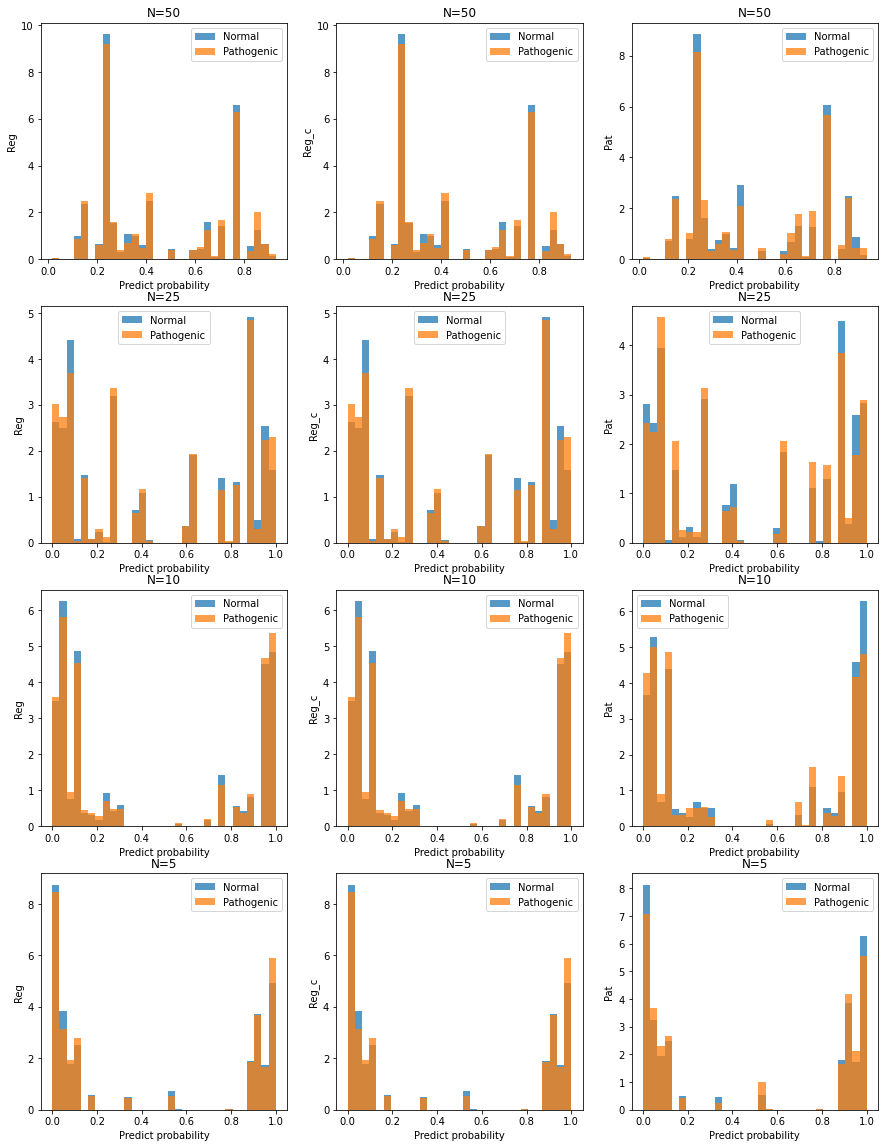

In [134]:
fig_out = plt.figure(figsize=[15, 20])
for i in range(12):
    temp_df = [DF_shape_reg, DF_shape_regc, DF_shape_pat][int(i%3)]
    index_c = [Ind_reg, Ind_regc, Ind_pat][int(i%3)]
    scoring = [Predout_shape_reg, Predout_shape_regc, Predout_shape_pat][int(i%3)]
    ylabel = ['Reg', 'Reg_c', 'Pat'][int(i%3)]
    N = [50, 25, 10, 5][i//3]
    scoring = local_treetest(temp_df.iloc[:, 0:96], Trees_topbottom_out, N, index_c)
    local_shapescoresubplot([4,3,1+i], temp_df, scoring, ylabel, "N="+str(N))
plt.show()
fig_out.savefig("manuscript/figures/pltout_misc_shapepatscores.pdf", dpi=300)